<a href="https://colab.research.google.com/github/BDonadelli/Codigos-em-financas/blob/main/estudos_de_python_em_financas.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
codigo  = 'goau4'       #@param {type:"string"}
inicio  = '2007-01-28'  #@param {type:"date"}
termino = '2023-08-08'  #@param {type:"date"}
usar_periodo = True     #@param {type:"boolean"}
if usar_periodo :
  periodo = '5y'        #@param ['1d', '5d', '1mo', '3mo', '6mo', '1y', '2y', '5y', '10y', 'ytd', 'max']
codigo = codigo.upper()

## o #@param é uma funcionalidade do markdown do google colab 

In [2]:
## gráficos
from plotly.subplots import make_subplots
import plotly.graph_objs as go
import cufflinks # para conectar o plotly ao pandas
cufflinks.go_offline()

'''
plotly.graph_objs tem graficos interativos 
que não são renderizados no github
 https://github.com/nicolaskruchten/plotly_img_test/blob/master/Untitled.ipynb
uma opção é usar o plotly.io com svg
'''

import plotly.io as pio
pio.renderers.default = 'svg'    #@param ['svg', 'colab', 'vscode' ]
codigo = codigo.upper()

In [3]:
import warnings
warnings.filterwarnings('ignore')

from datetime import datetime, date
import numpy as np
import pandas as pd

from scipy import stats
import statsmodels.api as sm

from IPython.display import display, HTML, clear_output
clear_output()

In [4]:
import yfinance as yf

tk_info = yf.Ticker(codigo+".sa")
info = tk_info.get_info()
# info, nem sempre dispoíveis 
try: L52 = info['fiftyTwoWeekLow']
except: L52 = None
try : H52 = info['fiftyTwoWeekHigh']
except: H52 = None
try: HP = info['targetHighPrice']
except: HP = None
try: LP = info['targetLowPrice']
except: LP = None
try: MP = info['targetMeanPrice']
except: MP = None
try: mP = info['targetMedianPrice']
except: mP = None
try: nAnal = info['numberOfAnalystOpinions']
except: nAnal = None

ativo = pd.DataFrame()
ibov = pd.DataFrame()
if usar_periodo :
  ativo = yf.download(codigo+'.SA', period = periodo , actions=True , progress = False)
  ibov = yf.download('^BVSP', period = periodo , actions=True , progress = False)
else :
  ativo = yf.download(codigo+'.SA' , start=inicio , end=termino , actions=True ,  progress = False)
  ibov = yf.download('^BVSP', start=inicio , end=termino , actions=True, progress = False)

## Informaçoes da empresa

In [ ]:
# !pip install -q googletrans==4.0.0rc1
from googletrans import Translator
translator = Translator()

rec = translator.translate(info['recommendationKey'], dest='pt').text

message = (
     f"\n\n\n De acordo com o yahoo finance, dentre {nAnal} analistas, "
     f"o menor preço-alvo é {LP}, "
     f"o maior {HP},"
     f"o preço alvo médio é {MP}, a mediana {mP}. "
     f'A recomentação é "{rec}".'
     f'Nas últimas 52 semanas o maior preço foi {H52} e o menor {L52}.'
)

import textwrap

print(codigo)
print("\n".join(textwrap.wrap(translator.translate(info['longBusinessSummary'], dest='pt').text,118)))
print("\n".join(textwrap.wrap(message,118)))

### Indicadores

In [6]:
#@markdown A empresa e Indicadores fundamentalistas dados do fundamentus.com.br

import requests
#pra fingir que é um browser
header = {
  "User-Agent": "Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/50.0.2661.75 Safari/537.36",
  "X-Requested-With": "XMLHttpRequest"
}

url = 'https://www.fundamentus.com.br/resultado.php'


r = requests.get(url, headers=header)
# read_html do pandas põe a tabela num dataframe
funds = pd.read_html(r.text, decimal=',', thousands='.',encoding='ISO-8859-1')
dfunds = pd.DataFrame(funds[0])

(dfunds.loc[dfunds['Papel']==codigo]).set_index('Papel')

,Cotação,P/L,P/VP,PSR,Div.Yield,P/Ativo,P/Cap.Giro,P/EBIT,P/Ativ Circ.Liq,EV/EBIT,EV/EBITDA,Mrg Ebit,Mrg. Líq.,Liq. Corr.,ROIC,ROE,Liq.2meses,Patrim. Líq,Dív.Brut/ Patrim.,Cresc. Rec.5a
Papel,,,,,,,,,,,,,,,,,,,,
GOAU4,10.52,6.25,0.58,0.168,"11,89%",0.131,0.52,1.58,2.12,2.4,1.64,"10,65%","7,96%",2.86,"9,85%","9,25%",60034400.0,1.877090e+10,0.67,"13,99%"


In [7]:
#@markdown A empresa e Indicadores fundamentalistas dados do statusinvest.com.br

url = 'https://raw.githubusercontent.com/BDonadelli/Codigos-em-financas/main/data/SI_Acoes.csv'
pd.set_option('display.max_columns', None)
fundsSI = pd.read_csv(url,sep=';' , decimal=',' ,thousands ='.' )

In [8]:
print('INDICADORES DE VALUATION')
fundsSI[fundsSI['TICKER']==codigo].set_index('TICKER')[[ 'DY', 'P/L', 'P/VP', 'P/ATIVOS', 'P/EBIT', 'EV/EBIT', 'PSR' ,' VPA', ' LPA', ' PEG Ratio',
                                                        'P/CAP. GIRO', 'P. AT CIR. LIQ.']]

INDICADORES DE VALUATION


,DY,P/L,P/VP,P/ATIVOS,P/EBIT,EV/EBIT,PSR,VPA,LPA,PEG Ratio,P/CAP. GIRO,P. AT CIR. LIQ.
TICKER,,,,,,,,,,,,
GOAU4,11.75,6.33,0.59,0.13,1.44,2.19,0.17,18.18,1.68,-0.14,0.53,-0.22


In [9]:
print('INDICADORES DE  EFICIÊNCIA')
fundsSI[fundsSI['TICKER']==codigo].set_index('TICKER')[['MARGEM BRUTA','MARGEM EBIT', 'MARG. LIQUIDA']]

INDICADORES DE  EFICIÊNCIA


,MARGEM BRUTA,MARGEM EBIT,MARG. LIQUIDA
TICKER,,,
GOAU4,13.98,11.82,2.69


In [10]:
print('INDICADORES DE  ENDIVIDAMENTO')
fundsSI[fundsSI['TICKER']==codigo].set_index('TICKER')[['DIVIDA LIQUIDA / EBIT', 'DIV. LIQ. / PATRI.', 'LIQ. CORRENTE','PATRIMONIO / ATIVOS', 'PASSIVOS / ATIVOS']]

INDICADORES DE  ENDIVIDAMENTO


,DIVIDA LIQUIDA / EBIT,DIV. LIQ. / PATRI.,LIQ. CORRENTE,PATRIMONIO / ATIVOS,PASSIVOS / ATIVOS
TICKER,,,,,
GOAU4,0.74,0.3,2.86,0.23,0.33


In [11]:
print('INDICADORES DE RENTABILIDADE')
fundsSI[fundsSI['TICKER']==codigo].set_index('TICKER')[['ROE', 'ROA', 'ROIC','GIRO ATIVOS']]

INDICADORES DE RENTABILIDADE


,ROE,ROA,ROIC,GIRO ATIVOS
TICKER,,,,
GOAU4,9.25,2.1,9.93,0.78


In [12]:
print('INDICADORES DE CRESCIMENTO')
fundsSI[fundsSI['TICKER']==codigo].set_index('TICKER')[['CAGR RECEITAS 5 ANOS', 'CAGR LUCROS 5 ANOS']]

INDICADORES DE CRESCIMENTO


,CAGR RECEITAS 5 ANOS,CAGR LUCROS 5 ANOS
TICKER,,
GOAU4,8.35,16.8


### Informações financeiras  últimos trimestres

**DRE**

In [13]:
def adicionar_espacos(s):
    resultado = [s[0]]

    for char_atual in s[1:]:
        if char_atual.isupper() and resultado[-1].islower():
            resultado.append(' ')
        resultado.append(char_atual)

    return ''.join(resultado)

In [14]:
dre = tk_info.quarterly_financials
dre = dre[dre.columns[::-1]]

k=[]
v=[]
for i in dre.index:
    #print(i)
    j = adicionar_espacos(i)
    k.append(i)
    #print(translator.translate(i, dest='pt').text)
    v.append(translator.translate(j, dest='pt').text)
trad = dict(zip(k, v))
dre_trimestre = dre.rename(index=trad)
dre_trimestre

,2022-12-31,2023-03-31,2023-06-30,2023-09-30,2023-12-31,2024-03-31,2024-06-30
Efeito tributário de itens incomuns,NaN,NaN,-34499643.15934,31970107.782796,-113999671.974573,-29234608.373131,-70432836.498957
Taxa de imposto para calcs,NaN,NaN,0.133565,0.165783,0.203431,0.098438,0.15272
Ebitda normalizada,NaN,NaN,3690126000.0,2738810000.0,2317346000.0,3487349000.0,2441158000.0
Itens totais incomuns,NaN,NaN,-258298000.0,192843000.0,-560385000.0,-296984000.0,-461188000.0
Itens incomuns totais excluindo a boa vontade,NaN,NaN,-258298000.0,192843000.0,-560385000.0,-296984000.0,-461188000.0
Lucro líquido da operação contínua juros minoritários líquidos,NaN,NaN,705125000.0,550676000.0,209707000.0,685765000.0,290987000.0
Depreciação reconciliada,NaN,NaN,752451000.0,789150000.0,790836000.0,725785000.0,771320000.0
Custo reconciliado da receita,NaN,NaN,14987029000.0,14270585000.0,13082750000.0,13790544000.0,14428921000.0
EBITDA,NaN,NaN,3431828000.0,2931653000.0,1756961000.0,3190365000.0,1979970000.0
EBIT,NaN,NaN,2679377000.0,2142503000.0,966125000.0,2464580000.0,1208650000.0


**Balanço**

In [15]:
balanco = tk_info.get_balance_sheet(freq='quarterly')
balanco = balanco[balanco.columns[::-1]]

k=[]
v=[]
for i in balanco.index:
    j = adicionar_espacos(i)
    # print(adicionar_espacos(i))
    k.append(i)
    #print(translator.translate(i, dest='pt').text)
    v.append(translator.translate(j, dest='pt').text)
traducao = dict(zip(k, v))
balanco_trimestre=balanco.rename(index=traducao)
balanco_trimestre

,2022-12-31,2023-03-31,2023-06-30,2023-09-30,2023-12-31,2024-03-31,2024-06-30
Número de ações do Tesouro,NaN,NaN,1135000.0,2270000.0,0.0,0.0,0.0
Número de ações ordinárias,NaN,NaN,1032705804.0,1032705804.0,1032705804.0,1032705804.0,1032705804.0
Ação emitida,NaN,NaN,1033840804.0,1034975804.0,1032705804.0,1032705804.0,1032705804.0
Dívida líquida,NaN,NaN,8164056000.0,8588797000.0,7912612000.0,7322458000.0,7719205000.0
Dívida total,NaN,NaN,11930976000.0,12869454000.0,12195902000.0,12374197000.0,13958020000.0
...,...,...,...,...,...,...,...
Contas brutas a receber,NaN,NaN,5680896000.0,5829315000.0,4965280000.0,5589606000.0,5991227000.0
Equivalentes em dinheiro e investimentos de curto prazo,NaN,NaN,4184642000.0,6979873000.0,5640724000.0,6232661000.0,6937521000.0
Outros investimentos de curto prazo,NaN,NaN,1628600000.0,4065304000.0,2635036000.0,2489496000.0,2047939000.0
Caixa e equivalentes de dinheiro,NaN,NaN,2556042000.0,2914569000.0,3005688000.0,3743165000.0,4889582000.0


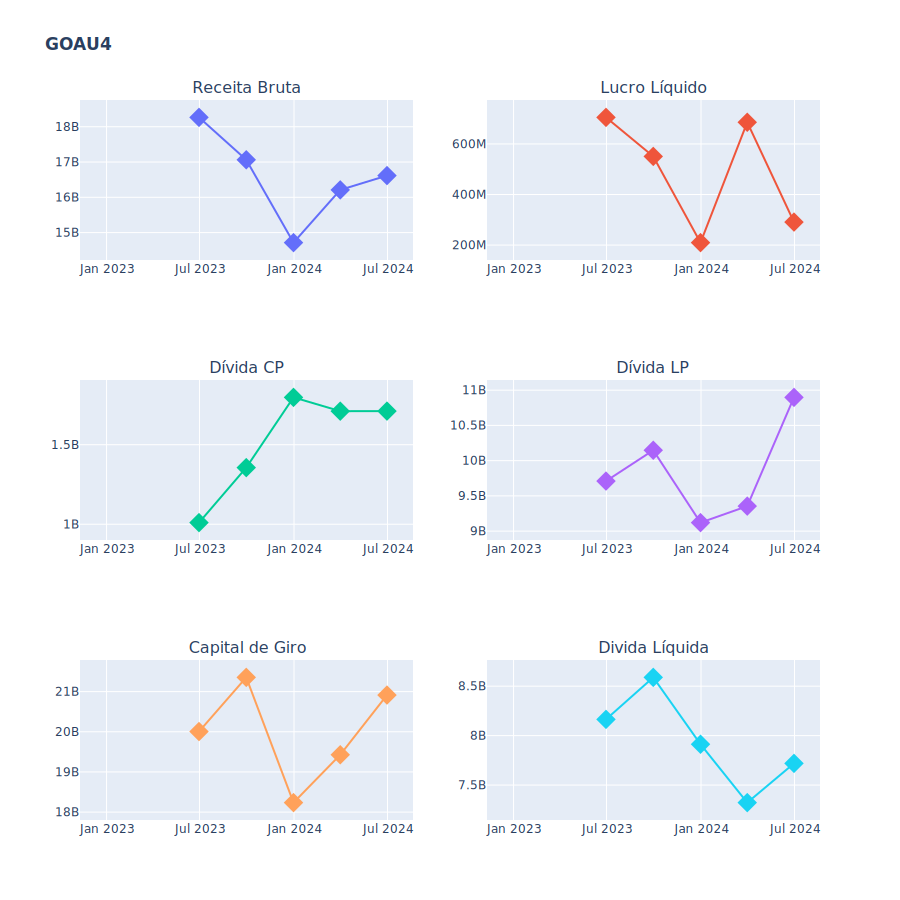

In [16]:
fig = make_subplots(rows=3,
                    cols=2,
                    row_heights=[5,5,5],
                    column_widths=[3,3],
                    subplot_titles=('Receita Bruta', 'Lucro Líquido',
                                    'Dívida CP', 'Dívida LP',
                                    'Capital de Giro','Divida Líquida',
                                    ),
                    shared_xaxes=False)
try:fig.add_trace(go.Scatter(name='Receita_bruta', x=dre.columns, y=dre.loc['Operating Revenue'], mode='lines+markers',marker_size=15,marker_symbol='diamond'), row=1, col=1)
except:pass
try:fig.add_trace(go.Scatter(name='Receita_liquida', x=dre.columns, y=dre.loc['Net Income'],mode='lines+markers',marker_size=15,marker_symbol='diamond'), row=1, col=2)
except:pass

try: fig.add_trace(go.Scatter(name='Divida_CP', x=balanco.columns, y=balanco.loc['CurrentDebt'],mode='lines+markers',marker_size=15,marker_symbol='diamond'), row=2, col=1)
except:pass
try:fig.add_trace(go.Scatter(name='Divida_CP', x=balanco.columns, y=balanco.loc['LongTermDebt'],mode='lines+markers',marker_size=15,marker_symbol='diamond'), row=2, col=2)
except:pass

try:fig.add_trace(go.Scatter(name='WC', x=balanco.columns, y=balanco.loc['WorkingCapital'],mode='lines+markers',marker_size=15,marker_symbol='diamond'), row=3, col=1)
except:pass
try:fig.add_trace(go.Scatter(name='Divida_liquida', x=balanco.columns, y=balanco.loc['NetDebt'],mode='lines+markers',marker_size=15,marker_symbol='diamond'), row=3, col=2)
except:pass

fig.update_layout(title_text=f'<b>{codigo}<b>',
                  showlegend=False, #esconder ou mostrar legenda
                  height=900, #altura
                  width=900) #largura
fig.show()

### Empresas do mesmo setor, subsetor e segmento


In [17]:
url = 'https://raw.githubusercontent.com/BDonadelli/Codigos-em-financas/main/data/setores.csv'
setores = pd.read_csv(url, sep =';')

#  coletar os simbolos das empresas do mesmo segmento
target_symbol = codigo[0:4]
target_index = setores[setores['LISTAGEM'] == target_symbol].index[0]
# Buscan símbolos acima do alvo até o primeiro NaN
symbols = []
for i in range(target_index - 1, -1, -1):
    if pd.isna(setores.loc[i, 'LISTAGEM']):
        break
    symbols.append(i)
symbols.append(target_index)

Setor=setores[setores['LISTAGEM']==target_symbol]['SETOR ECONÔMICO'].values[0]
Subsetor=setores[setores['LISTAGEM']==target_symbol]['SUBSETOR'].values[0]
Segmento=setores.loc[i, 'SEGMENTO']

# Busca símbolos abaixo do alvo até o primeiro NaN
for i in range(target_index + 1, len(setores)):
    if pd.isna(setores.loc[i, 'LISTAGEM']):
        break
    symbols.append(i)

In [18]:
print(f'Setor: {Setor}')
print(f'Subsetor: {Subsetor}')
print(f'Segmento: {Segmento}')

setores[setores['SETOR ECONÔMICO']==Setor][['SUBSETOR','SEGMENTO','LISTAGEM']].fillna(' ')

Setor: Materiais Básicos
Subsetor: Siderurgia e Metalurgia
Segmento: Siderurgia


,SUBSETOR,SEGMENTO,LISTAGEM
14,Mineração,Minerais Metálicos,
15,Mineração,AURA 360,AURA
16,Mineração,BRADESPAR,BRAP
17,Mineração,CBA,CBAV
18,Mineração,CSNMINERACAO,CMIN
19,Mineração,LITEL,LTEL
20,Mineração,LITELA,LTLA
21,Mineração,VALE,VALE
22,Siderurgia e Metalurgia,Siderurgia,
23,Siderurgia e Metalurgia,FERBASA,FESA


In [19]:
'''
    vamos selecionar o ticker das empresas listadas do mesmo segmento
    usamos o índice amplo (IBrA)  composto pelas ações e units exclusivamente 
    de ações de companhias listadas na B3  que representem 99% em ordem 
    decrescente de Índice de Negociabilidade (IN); 95% de presença em pregão; e 
    não ser penny stock.Não estão incluídos nesse universo BDRs e ativos de 
    companhias em recuperação judicial ou extrajudicial, regime especial de 
    administração temporária, intervenção ou que sejam negociados em qualquer 
    outra situação especial de listagem.
'''

segmento = setores.loc[symbols]
segmento = segmento.sort_values(by='LISTAGEM')
# segmento

#pegar o ticker de maior volume da empresa de acordo com o IBrA
url='https://raw.githubusercontent.com/BDonadelli/Codigos-em-financas/main/data/Cart_IBrA.csv'
IBRA = pd.read_csv(url, sep =';' , encoding='latin-1' , decimal=',' , thousands='.' , skiprows=1 , index_col=False)
IBRA = IBRA[:-2].sort_values(by='Part. (%)',ascending=False)
IBRA['LISTAGEM'] = IBRA['Código'].str.slice(0, 4)
IBRA = IBRA.drop_duplicates(subset='LISTAGEM', keep='first')
# IBRA

mesmo_setor_tickers = list(IBRA[IBRA['LISTAGEM'].isin(segmento['LISTAGEM'])]['Código'].values)
mesmo_setor_tickers 


['GGBR4', 'CSNA3', 'GOAU4', 'USIM5', 'FESA4']

In [20]:
segmento

,SETOR ECONÔMICO,SUBSETOR,SEGMENTO,LISTAGEM,SM
26,Materiais Básicos,Siderurgia e Metalurgia,SID NACIONAL,CSNA,NaN
23,Materiais Básicos,Siderurgia e Metalurgia,FERBASA,FESA,N1
24,Materiais Básicos,Siderurgia e Metalurgia,GERDAU,GGBR,N1
25,Materiais Básicos,Siderurgia e Metalurgia,GERDAU MET,GOAU,N1
27,Materiais Básicos,Siderurgia e Metalurgia,USIMINAS,USIM,N1


In [21]:
IBrA=mesmo_setor_tickers
display(dfunds[dfunds['Papel'].isin(IBrA)].set_index('Papel')[['Cotação','P/L', 'P/VP', 'Div.Yield', 'Dív.Brut/ Patrim.', 'Liq. Corr.','EV/EBIT', 'Mrg. Líq.', 'ROE','Cresc. Rec.5a']])

luc = dfunds[dfunds['Papel'].isin(IBrA)].set_index('Papel')[['Mrg. Líq.' , 'Mrg Ebit' , 'ROIC', 'ROE', 'Div.Yield', 'Cresc. Rec.5a']]
end = dfunds[dfunds['Papel'].isin(IBrA)].set_index('Papel')[['Dív.Brut/ Patrim.']]
val = dfunds[dfunds['Papel'].isin(IBrA)].set_index('Papel')[['P/L', 'P/VP', 'EV/EBIT', 'EV/EBITDA']]
liq = dfunds[dfunds['Papel'].isin(IBrA)].set_index('Papel')[['Liq. Corr.']]

,Cotação,P/L,P/VP,Div.Yield,Dív.Brut/ Patrim.,Liq. Corr.,EV/EBIT,Mrg. Líq.,ROE,Cresc. Rec.5a
Papel,,,,,,,,,,
CSNA3,11.93,-22.80,1.13,"12,23%",3.62,1.29,7.95,"0,55%","-4,94%","12,30%"
GOAU4,10.52,6.25,0.58,"11,89%",0.67,2.86,2.40,"7,96%","9,25%","13,99%"
GGBR4,18.47,7.69,0.71,"4,74%",0.23,2.83,6.51,"7,89%","9,18%","13,99%"
FESA4,8.05,12.51,0.87,"6,43%",0.09,3.55,11.08,"10,71%","6,95%","13,61%"
USIM5,6.23,14.55,0.33,"4,54%",0.27,3.59,-104.10,"2,86%","2,26%","14,81%"


In [22]:
def to_float(val):
    return float(val.replace('.', '').replace(',', '.').replace('%', '').strip())
for col in luc.columns:
        luc[col] = luc[col].apply(to_float)

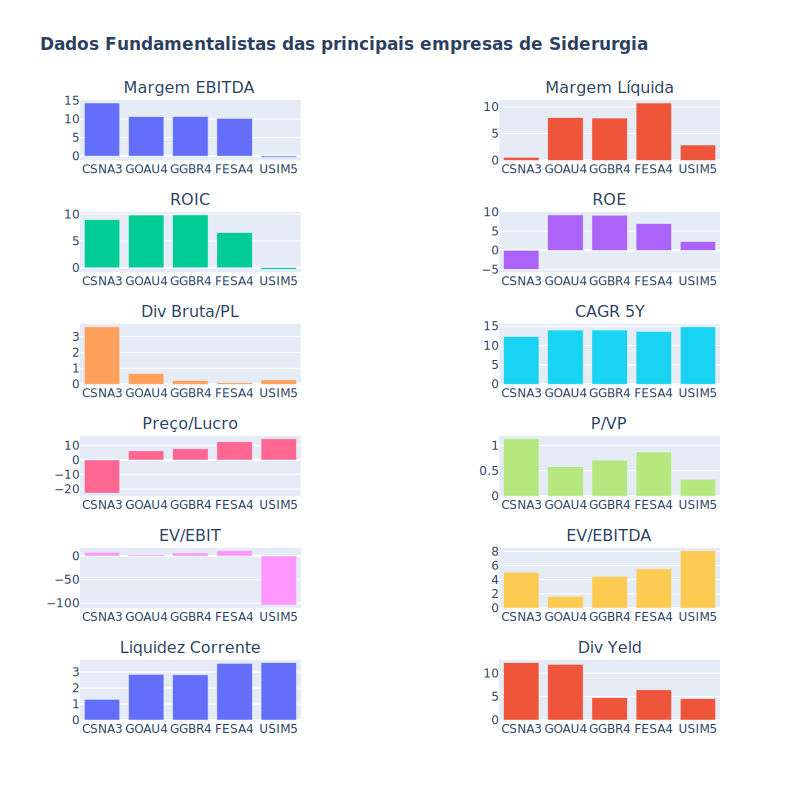

In [23]:
fig = make_subplots(rows=6,
                    cols=2,
                    row_heights=[5,5,5,5,5,5],
                    column_widths=[3,3],
                    subplot_titles=('Margem EBITDA', 'Margem Líquida',
                                    'ROIC', 'ROE',
                                    'Div Bruta/PL', 'CAGR 5Y',
                                    'Preço/Lucro', 'P/VP',
                                    'EV/EBIT', 'EV/EBITDA',
                                    'Liquidez Corrente', 'Div Yeld'),
                    horizontal_spacing=0.31,
                    shared_xaxes=False)

fig.add_trace(go.Bar(name='Margem_Ebtida', x=luc.index, y=luc['Mrg Ebit']), row=1, col=1)
fig.add_trace(go.Bar(name='Margem_Liquida', x=luc.index, y=luc['Mrg. Líq.']), row=1, col=2)

fig.add_trace(go.Bar(name='ROIC', x=luc.index, y=luc['ROIC']), row=2, col=1)
fig.add_trace(go.Bar(name='ROE', x=luc.index, y=luc['ROE']), row=2, col=2)

fig.add_trace(go.Bar(name='div/patr', x=end.index, y=end['Dív.Brut/ Patrim.']), row=3, col=1)
fig.add_trace(go.Bar(name='c5y', x=luc.index, y=luc['Cresc. Rec.5a']), row=3, col=2)

fig.add_trace(go.Bar(name='pl', x=val.index, y=val['P/L']), row=4, col=1)
fig.add_trace(go.Bar(name='pvp', x=val.index,y=val['P/VP']), row=4, col=2)

fig.add_trace(go.Bar(name='evebit', x=val.index, y=val['EV/EBIT']), row=5, col=1)
fig.add_trace(go.Bar(name='evebitda', x=val.index, y=val['EV/EBITDA']), row=5, col=2)

fig.add_trace(go.Bar(name='liq', x=liq.index, y=liq['Liq. Corr.']), row=6, col=1)
fig.add_trace(go.Bar(name='dy', x=luc.index, y=luc['Div.Yield']), row=6, col=2)

fig.update_layout(title_text=f'<b>Dados Fundamentalistas das principais empresas de {Segmento}<b>',
                #   template='plotly_dark',#template pré-definido da plotly
                  showlegend=False, #esconder ou mostrar legenda
                  height=800, #altura
                  width=800) #largura
fig.show()

**Eventos**

In [24]:
ativo[ativo['Stock Splits']!=0]

,Open,High,Low,Close,Adj Close,Volume,Dividends,Stock Splits
Date,,,,,,,,


## Histórico de dividendos

In [25]:
url1 = f'https://www.fundamentus.com.br/proventos.php?papel={codigo}&tipo=2'
header = { "User-Agent": "Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/50.0.2661.75 Safari/537.36", "X-Requested-With": "XMLHttpRequest"}
r1 = requests.get(url1, headers=header)
dy = pd.read_html(r1.text, decimal=',', thousands='.')[0]
dy['Data'] = pd.to_datetime(dy['Data'] , dayfirst=True)
dy['Ano'] = dy['Data'].apply(lambda x : x.year)
# display(HTML(dy.to_html(index=False)))

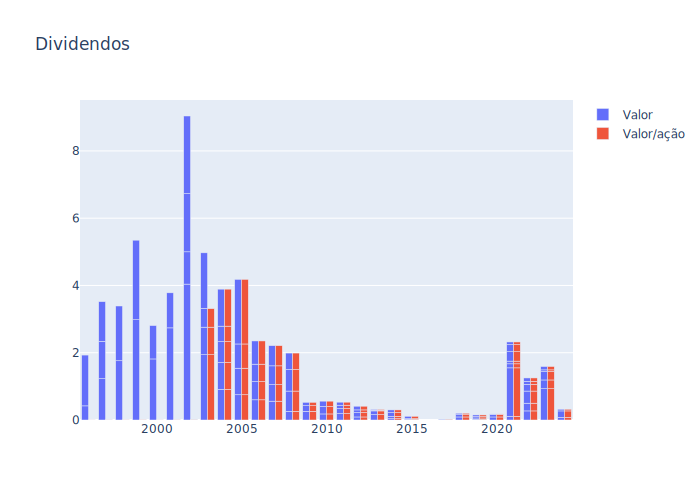

In [26]:
# dy.set_index('Data',inplace =True )
dy['Valor/acao'] = dy['Valor']/dy['Por quantas ações']
fig = go.Figure(
    [ go.Bar(x=dy.Ano , y = dy['Valor'],name='Valor'),
     go.Bar(x=dy.Ano, y = dy['Valor/acao'],name='Valor/ação')],
    layout=dict(title='Dividendos ',height=500, width=700 ))
fig.show()

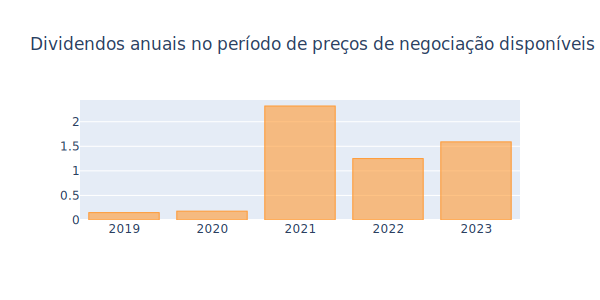

In [27]:
yanual = dy.groupby('Ano')['Valor'].sum()
if len(yanual.index) > 6 :
    yanual[(yanual.index >= ativo.index[0].year) & (yanual.index < ativo.index[-1].year)].iplot(kind='bar',layout=dict(title='Dividendos anuais no período de preços de negociação disponíveis',height=300, width=600))

In [28]:
print(f'Distribuição de {codigo}', end=' ')
print(f'em {( (ativo.index[-1].year -1) - ativo.index[0].year)} anos,', end=' ')
print(f'R$ {round(yanual[(yanual.index >= ativo.index[0].year) & (yanual.index < ativo.index[-1].year)].sum(),2)}')
print(f'provento anual medio R$ {round(yanual[(yanual.index >= ativo.index[0].year) & (yanual.index < ativo.index[-1].year)].mean(),2)}')
print(f"preço fechamento médio R$ {round( np.mean(ativo['Adj Close']),2 )}")
dy12m = yanual[(yanual.index >= ativo.index[0].year) & (yanual.index < ativo.index[-1].year)].mean()/np.mean(ativo['Adj Close'])
print(f"DY por essas médias {round(100*dy12m,2)}%")

Distribuição de GOAU4 em 4 anos, R$ 5.49
provento anual medio R$ 1.1
preço fechamento médio R$ 8.23
DY por essas médias 13.34%


tendência do yield

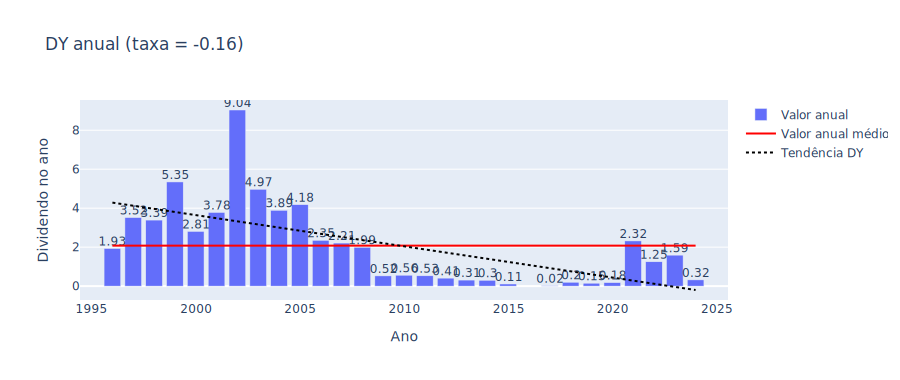

In [29]:
df_m, df_b = np.polyfit(yanual.index, yanual.values, 1)

fig = go.Figure()

fig.add_trace(
    go.Bar(name='Valor anual',
    x=yanual.index,
    y=yanual.values
))

fig.add_trace(
    go.Scatter(
    x=yanual.index,
    y=yanual.values,
    text= yanual.values.round(decimals=2),
    mode='text',
    textposition='top center',
    textfont=dict(size=12),
    showlegend=False
))


fig.add_trace(go.Scatter(name='Valor anual médio',
    x=yanual.index,
    y=[yanual.values.mean()]*len(yanual.index),
    mode='lines',
    line = dict(color = 'red' , width=2)
))

fig.add_trace(
    go.Scatter(name='Tendência DY',
    x=yanual.index,
    y=df_m*yanual.index+df_b,
    mode='lines',
    line = dict(color = 'black', dash='dot')
))

fig.update_layout(title= f"DY anual (taxa = {df_m:.2f})" , width=900, height=380 )
fig.update_xaxes(title_text="Ano")
fig.update_yaxes(title_text="Dividendo no ano")

fig.show()

## preço


In [30]:
ativo[['Open','High','Low','Close','Adj Close','Volume']]

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2019-08-29,5.90,6.14,5.85,6.07,3.699281,17455100
2019-08-30,6.17,6.27,6.09,6.25,3.808979,11179200
2019-09-02,6.28,6.32,6.16,6.16,3.754130,6197800
2019-09-03,6.13,6.20,6.06,6.13,3.735847,7218600
2019-09-04,6.21,6.26,6.09,6.09,3.711469,8645600
...,...,...,...,...,...,...
2024-08-23,10.51,10.67,10.44,10.55,10.550000,5767300
2024-08-26,10.63,10.69,10.52,10.62,10.620000,6005500
2024-08-27,10.62,10.64,10.47,10.47,10.470000,4695400


In [31]:
qual_preco = 'Adj Close' #@param ['Open','High','Close','Low','Adj Close']


In [32]:
preco = pd.DataFrame()
preco = pd.merge(ativo[qual_preco],ibov[qual_preco],left_index = True, right_index = True, how = 'inner')
preco.columns = [codigo,"ibov"]
preco

,GOAU4,ibov
Date,,
2019-08-29,3.699281,100524.0
2019-08-30,3.808979,101135.0
2019-09-02,3.754130,100626.0
2019-09-03,3.735847,99681.0
2019-09-04,3.711469,101201.0
...,...,...
2024-08-23,10.550000,135608.0
2024-08-26,10.620000,136889.0
2024-08-27,10.470000,136776.0


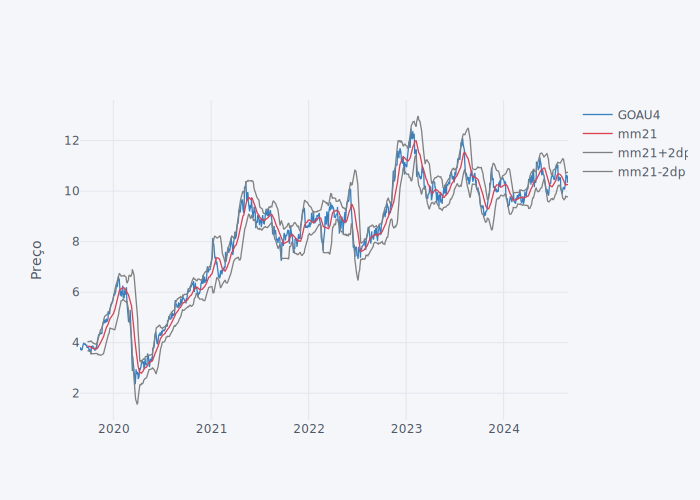

In [33]:
# Bandas com média movel 21 periodos e 2dp
preco['mm21'] = preco[codigo].rolling(21).mean()
Mov_SD = preco[codigo].rolling(21).std(ddof=0)
preco['mm21+2dp'] = preco['mm21'] + 2*Mov_SD
preco['mm21-2dp'] = preco['mm21'] - 2*Mov_SD
preco.loc['2019':].iplot(keys = [codigo,'mm21','mm21+2dp','mm21-2dp'], yTitle='Preço',
                         colors=['blue','red','gray','gray'] )

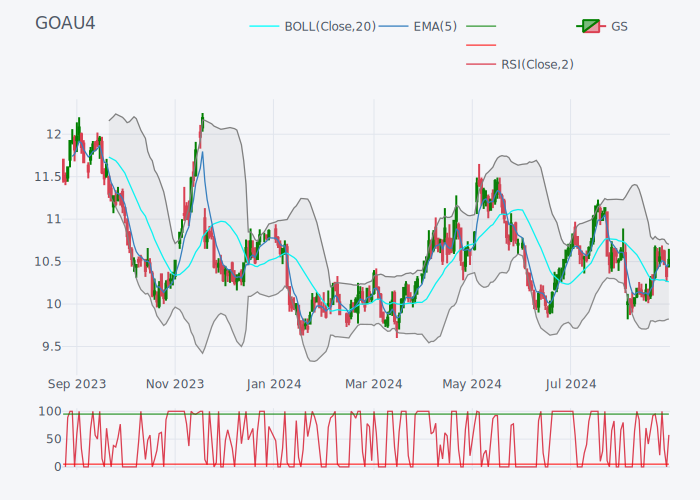

In [34]:
if len(ativo>254) :
  qf=cufflinks.QuantFig(ativo[-254:],title=codigo,legend='top',name='GS',up_color='green', down_color='red' )
  qf.add_bollinger_bands(periods=20, boll_std=2, colors=['cyan','grey'], fill=True)
  qf.add_ema(periods=5)
  qf.add_rsi(periods=2,color='red',rsi_upper=95,rsi_lower=5,showbands=True)
#   qf.add_macd(fast_period=9,slow_period=21,signal_period=3)
#   qf.add_resistance(date='2023-02-17', on='close', color='orange')

  fig = qf.figure()
  fig.update_xaxes(rangebreaks=[dict(bounds=["sat", "mon"])])
  fig.show()

### simulação de preços
 [movimento browniano geométrico](https://pt.wikipedia.org/wiki/Movimento_browniano_geom%C3%A9trico) (GBM):


Esse modelo simula o comportamento de uma ação usando a fórmula

$$
S_t = S_{t-\Delta t}e^{\left( \mu - \frac{\sigma^2}{2} \right) \Delta t + \sigma z_t \sqrt{\Delta t}}
$$

em que $S_0$ e $S_t$ são o preço da ação no início e no instante $t$, respectivamente,  $\mu$ e $\sigma$ são a média e o desvio padrão do retorno esperado de uma ação, e $z_i$ é uma componente aleatória --- um número sorteado a partir de uma [distribuição normal](https://pt.wikipedia.org/wiki/Distribui%C3%A7%C3%A3o_normal) com média 0 e desvio padrão 1 --- e $\Delta t$ é o número de dias das taxa de retorno (como estamos trabalhando com retorno diário $\Delta t=1$)
$$
S_t = S_{0}e^{\left( \mu - \frac{\sigma^2}{2} \right) t + \sigma z_t }
$$
A componente $\exp{\left( \mu - {\sigma^2}/{2} \right)t}$ é conhecida como **deriva** (*drift*) e modela uma tendência determinística do preço da ação: $S_t = S_0 \exp{\left( \mu - {\sigma^2}/{2} \right)t}$.

A componente $\exp {\sigma W_t}$ é conhecida como **difusão** (*diffusion*), e é usado para modelar um conjunto de eventos imprevisíveis que ocorrem durante este movimento.

Obviamente não temos como saber a sequência correta de retornos, mas a título de ilustração,  podemos usar a própria sequência de eventos de retorno.

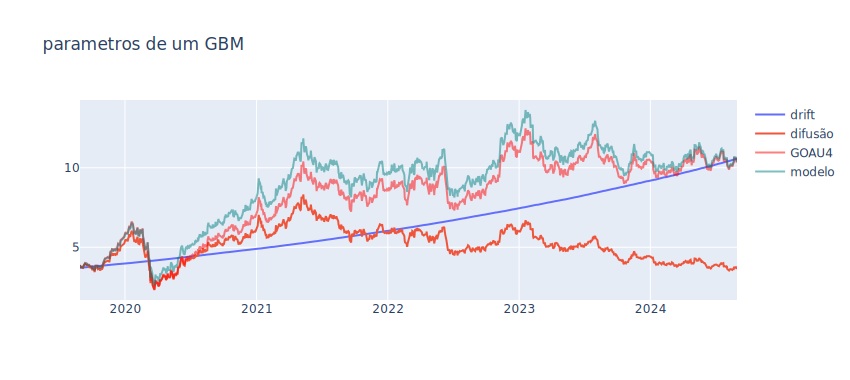

In [35]:
rate = preco[codigo].pct_change().fillna(0)
s_media = rate.mean()
s_devp  = rate.std()
S0 = preco[codigo][0]

drift = pd.Series(s_media - (s_devp**2)/2 , index=preco.index)
St_dri = S0*np.exp(drift.cumsum())

Z = ( rate - s_media) / s_devp
diffusion = Z * s_devp
St_dif = S0*np.exp(diffusion.cumsum())

St = S0 * np.exp((drift+diffusion).cumsum())

trace1 = go.Scatter(x=preco.index , y = St_dri , name='drift')
trace2 = go.Scatter(x=preco.index , y = preco[codigo] , name=codigo, line=dict(color='rgba(1.0 ,0, 0, 0.5)'))
trace3 = go.Scatter(x=preco.index , y = St_dif , name='difusão')
trace4 = go.Scatter(x=preco.index , y = St , name='modelo' , line=dict(color='rgba(0, 0.5, 0.5, 0.5)'))
figdata = [trace1,trace3,trace2,trace4]
fig = go.Figure(data=figdata)
fig.update_layout(title='parametros de um GBM', height=380, width=850 )

fig.show()

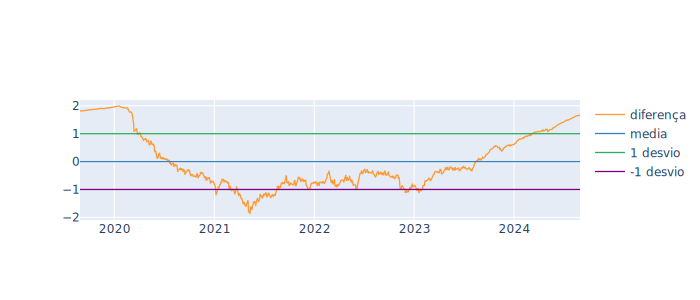

In [36]:
diferenca = pd.DataFrame()
diferenca['diferença'] = (preco[codigo] - St)
diferenca['media'] = diferenca['diferença'].mean()
diferenca['1 desvio'] = diferenca['diferença'].std()
diferenca['diferença'] = (diferenca['diferença'] - diferenca['media'])/diferenca['1 desvio']
diferenca['media'] = 0
diferenca['1 desvio'] = 1
diferenca['-1 desvio'] = -1

diferenca.iplot(layout=dict(height=300, width=700 ))

Na simulação do preço, trocamos a sequência conhecida de eventos por uma sequência de eventos chamada de processo de Wiener ou processo Browniano. No modelo,  W  é sorteado a partir de uma distrinuição normal com média 0 e desvio padrão 1:

In [37]:
# Função para simular o GBM
def simula(S0 , dias , mu , sigma , n_paths, seed=None):
    np.random.seed(seed)
    dt = 1 / dias  # Número de dias de negociação no período de simulação ) :
    S = []
    for i in range(n_paths):
        path = []
        for t in range(dias+1):
            if t == 0 :
                path.append(S0)
            else:
               z = np.random.normal(0.0, 1.0)
               St = path[t - 1] * np.exp((mu - 0.5 * sigma ** 2) * dt + sigma * np.sqrt(dt) * z)
               path.append(St)
        S.append(path)
    return np.array(S)

In [38]:
n_dias = 5#@param {type:"integer"}
n_cenarios = 1000#@param {type:"integer"}
n_grafico = 10*n_dias

In [39]:
simulacao = simula(preco[codigo].iloc[-1] , n_dias , s_media , s_devp , n_cenarios).transpose()
# simulacao

In [40]:
# Criar DataFrame com os preços simulados
dias_simulados = pd.date_range(start=preco.index[-1], periods=n_dias+1 ,freq='B')  # Considerando dias úteis
df_simulado = pd.DataFrame(simulacao , index = dias_simulados )
df_simulado.iloc[:, :10].head()

,0,1,2,3,4,5,6,7,8,9
2024-08-29,10.520000,10.520000,10.520000,10.520000,10.520000,10.520000,10.520000,10.520000,10.520000,10.520000
2024-08-30,10.414807,10.513530,10.633816,10.398530,10.485005,10.410287,10.633731,10.434994,10.431494,10.269956
2024-09-02,10.706164,10.342082,10.746366,10.310196,10.430640,10.419219,10.770979,10.430927,10.658258,10.160053
2024-09-03,10.518972,10.340395,10.684787,10.271721,10.527447,10.307056,10.797230,10.455807,10.759122,10.176479
2024-09-04,10.356001,10.340350,10.712939,10.472629,10.753733,10.360003,10.873284,10.416000,10.702964,10.418603


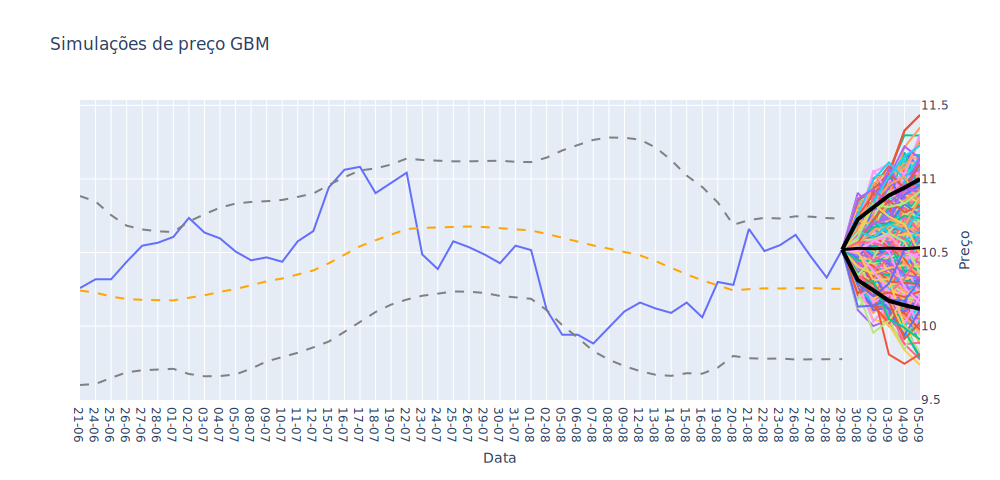

In [41]:
fig = go.Figure()

fig.add_trace(go.Scatter(x=preco[codigo].iloc[-n_grafico:].index , y =preco[codigo].iloc[-n_grafico:]  , mode='lines' , name = 'preço'))

for i in range(n_cenarios):
    fig.add_trace(go.Scatter(x=df_simulado.index , y = df_simulado[i]  , mode='lines' ))
    fig.data[i+1].update(showlegend=False)

fig.add_trace(go.Scatter(x=df_simulado.index , y = df_simulado.quantile(0.05,axis=1) , mode='lines' , line=dict(color='black',width=4), name='percentil 5'))
fig.add_trace(go.Scatter(x=df_simulado.index , y = df_simulado.quantile(0.5,axis=1)  , mode='lines' , line=dict(color='black',width=3), name='mediana'))
fig.add_trace(go.Scatter(x=df_simulado.index , y = df_simulado.quantile(0.95,axis=1) , mode='lines' , line=dict(color='black',width=4), name='percentil 95'))

fig.add_trace(go.Scatter(name='mm21',
                         x=preco[codigo].iloc[-n_grafico:].index ,
                         y= preco['mm21'].iloc[-n_grafico:].values,
                         mode='lines', line=dict(color='orange', dash='dash')))
fig.add_trace(go.Scatter(name='mm21+2dp',
                         x=preco[codigo].iloc[-n_grafico:].index ,
                         y= preco['mm21+2dp'].iloc[-n_grafico:].values,
                         mode='lines', line=dict(color='gray', dash='dash') ))
fig.add_trace(go.Scatter(name='mm21-2dp',
                         x=preco[codigo].iloc[-n_grafico:].index ,
                         y= preco['mm21-2dp'].iloc[-n_grafico:].values,
                         mode='lines',line=dict(color='gray', dash='dash')))

fig.update_layout(
    title='Simulações de preço GBM',
    xaxis=dict(title='Data', dtick='D', tickformat='%d-%m', rangebreaks=[dict(bounds=["sat", "mon"])]),  # Excluir sábado e domingo
    yaxis=dict(title='Preço', side='right'),  # Posicionando os rótulos do eixo y no lado esquerdo
    width=1000,
    height=480,
    showlegend=False
)

# fig.update_xaxes(dtick='D', tickformat='%d-%m' ,
#     rangebreaks=[
#         dict(bounds=["sat", "mon"]),  # Excluir sábado e domingo
#     ]
# )

fig.show()

intervalo de confiança para preços na  simulação


In [42]:
def ic ( m,s, alfa) :
    l, u = stats.norm.interval(confidence=alfa,  loc=m , scale= s)
    return "{:.2f}".format(l), "{:.2f}".format(u)

alfa=.9

for i in range(n_dias):
    m = np.mean(df_simulado.iloc[i+1])
    s = stats.sem(df_simulado.iloc[i+1])

    print(f'dia {str(i+1)}: {str(100*alfa)}% -> ' , end='')
    print(f'({ic(m,s,alfa)[0]} , {ic(m,s,alfa)[1]})' , end='     95% ->')
    print(f'({ic(m,s,alfa+.05)[0]} , {ic(m,s,alfa+.05)[1]})' , end='     99% ->')
    print(f'({ic(m,s,alfa+.09)[0]} , {ic(m,s,alfa+.09)[1]})')

dia 1: 90.0% -> (10.52 , 10.53)     95% ->(10.52 , 10.53)     99% ->(10.52 , 10.54)
dia 2: 90.0% -> (10.52 , 10.54)     95% ->(10.52 , 10.54)     99% ->(10.51 , 10.54)
dia 3: 90.0% -> (10.52 , 10.54)     95% ->(10.52 , 10.54)     99% ->(10.51 , 10.55)
dia 4: 90.0% -> (10.52 , 10.55)     95% ->(10.52 , 10.55)     99% ->(10.51 , 10.55)
dia 5: 90.0% -> (10.53 , 10.56)     95% ->(10.52 , 10.56)     99% ->(10.52 , 10.56)


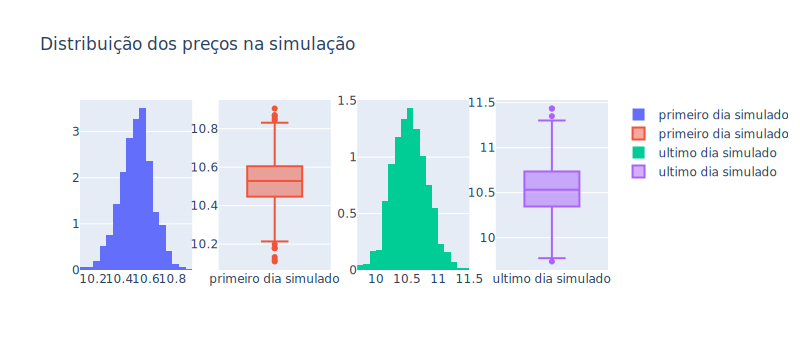

In [43]:
trace1 = go.Histogram(x=df_simulado.iloc[1] , nbinsx= int(2*(df_simulado.shape[1])**(1/3)), histnorm='probability density',name='primeiro dia simulado')
trace3 = go.Histogram(x=df_simulado.iloc[-1], nbinsx= int(2*(df_simulado.shape[-1])**(1/3)), histnorm='probability density',name='ultimo dia simulado')
trace2 = go.Box(y=df_simulado.iloc[1],name='primeiro dia simulado')
trace4 = go.Box(y=df_simulado.iloc[-1],name='ultimo dia simulado')

fig = make_subplots(rows=1, cols=4)

fig.append_trace(trace1,1,1)
fig.append_trace(trace2,1,2)
fig.append_trace(trace3,1,3)
fig.append_trace(trace4,1,4)

fig.update_layout(title='Distribuição dos preços na simulação', height=350, width=800)

fig.show()

#### tendência

Uma série temporal é definida como fortemente estacionária se sua distribuição de probabilidade conjunta for invariante sob translações no tempo ou no espaço. Em particular, a média e a variância do processo não mudam ao longo do tempo ou do espaço e cada uma delas não segue uma tendência. Uma característica crítica das séries de preços estacionárias é que os preços dentro da série se difundem a partir do seu valor inicial a uma taxa mais lenta do que a de um GBM. Medindo a taxa desse comportamento difusivo podemos identificar a natureza da série temporal.

*Expoente de Hurst*: uma medida de autocorrelação de uma série teporal, é uma maneira rápida de clasificar uma série temporal em "tendência", "reversão à média" ou "passeio aleatório".

O cálculo do expoente de Hurst requer a estimativa da [estatística R/S](https://en.wikipedia.org/wiki/Rescaled_range) em vários períodos de tempo diferentes e, em seguida, plotá-la em relação aos períodos de tempo em um gráfico log-log e encontrar a inclinação. A inclinação dessa linha é o expoente de Hurst H.

A ideia é usar a variância de uma série logarítmica de preços para avaliar a taxa de comportamento difusivo. Por um *lag* de tempo arbitrário $\tau$ a variância é dada por: $\mathbb{E}\{\log(t+\tau)-\log(t)\}^2$, e como estamos comparando a taxa de difusão com a de um Movimento Geométrico Browniano, podemos usar o fato de que em geral temos que a variância é proporcional a $\tau$, para $\tau$ grande, no caso de um GBM: $\mathbb{E}\{\log(t+\tau)-\log(t)\}^2 \sim \tau$.  A principal conclusão é que se existirem quaisquer autocorrelações então a relação acima não é válida. Nesse caso, modificamos para incluir um valor de expoente $H$:  $\mathbb{E}\{\log(t+\tau)-\log(t)\}^2 \sim \tau^{2H}$, o que nos dá o valor do Expoente de Hurst $H$.

Os valores do expoente de Hurst variam entre 0 e 1 com os quais podemos classificar qualquer série temporal em uma das três categorias:
* H < 0,5 — uma série de reversão à média. Quanto mais próximo 0, mais força tem o processo de reversão à média.
* H = 0,5 — um passeio aleatório (GBM).
* H > 0,5 — uma série de tendência. Quanto mais próximo de 1, mais forte será a tendência.


Abaixo, um dos modos de calcular o expoente de Hurst.

In [44]:
def get_hurst_exponent(ts, min_lag=2, max_lag=100):

    lags = range(min_lag, max_lag+1)

    tau = [np.std(np.subtract(ts[lag:], ts[:-lag])) for lag in lags]
    poly = np.polyfit(np.log(lags), np.log(tau), 1)

    return poly , lags, tau



Os cálculos do expoente de Hurst podem ser resumidos em duas etapas:
1. Para cada defasagem na *lag* considerada, calculamos o desvio padrão do diferencial da série.
2.Calculamos a inclinação do gráfico do logaritmo do diferencial $\times$ o logaritmo dos desvios padrão.


$D_{\tau} = x_{t+\tau} - x_t \quad (\forall \tau)$

$\sigma_{\tau} = \sqrt{\frac{1}{N} \sum(D_{\tau} - \bar{D}_{\tau})^2} \quad (\forall \tau)$

$\sigma_{\tau} = \tau^H \quad (\forall \tau)$

$\textrm{log}(\sigma_\tau) = H \textrm{log}(\tau)$

Exemplo

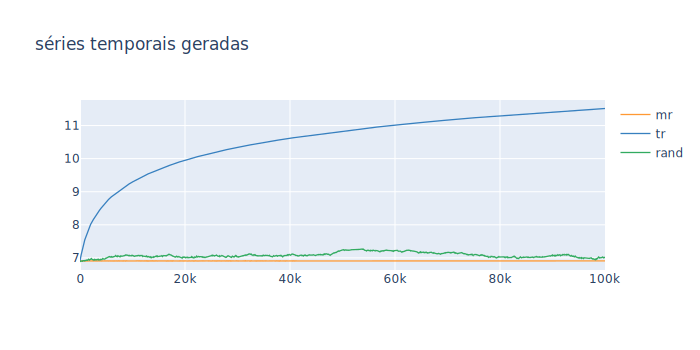

In [45]:
rand = np.log(np.cumsum(np.random.randn(100000))+1000)
mr = np.log(np.random.randn(100000)+1000)
tr = np.log(np.cumsum(np.random.randn(100000)+1)+1000)

dfHus = pd.DataFrame(data={"mr": mr , # + scalar),
                           "tr": tr , #+  scalar),
                           "rand": rand# + scalar),
                        }
                  )
dfHus.iplot(layout=dict(title="séries temporais geradas",height=350, width=700))

In [46]:
for lag in [20, 100, 250, 500 , 1000]:
    print(f"exponetes de Hurst com maxlag {lag}  ----")
    for column in dfHus.columns:
        print(f"{column}: {get_hurst_exponent(dfHus[column].values,2, lag)[0][0]:.4f}")
    print(f"{codigo}: {get_hurst_exponent(preco[codigo].values,2, lag)[0][0]:.4f}")

    print('----')

exponetes de Hurst com maxlag 20  ----
mr: -0.0006
tr: 0.9138
rand: 0.5017
GOAU4: 0.5264
----
exponetes de Hurst com maxlag 100  ----
mr: 0.0001
tr: 0.9549
rand: 0.5081
GOAU4: 0.4621
----
exponetes de Hurst com maxlag 250  ----
mr: 0.0001
tr: 0.9611
rand: 0.4990
GOAU4: 0.3391
----
exponetes de Hurst com maxlag 500  ----
mr: 0.0000
tr: 0.9582
rand: 0.4849
GOAU4: 0.2320
----
exponetes de Hurst com maxlag 1000  ----
mr: 0.0001
tr: 0.9422
rand: 0.4803
GOAU4: 0.1265
----


In [47]:
recent =  preco.iloc[-662:][codigo]
for lag in [20, 100, 250, 500]:
    print(f"lag {lag} : {get_hurst_exponent(recent.values,2, lag)[0][0]:.4f}")

lag 20 : 0.5138
lag 100 : 0.4244
lag 250 : 0.2866
lag 500 : 0.0724


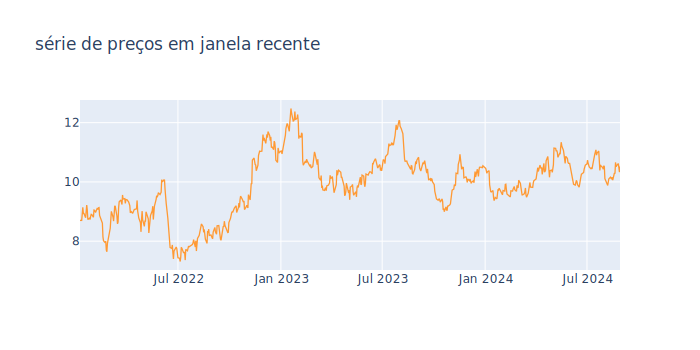

In [48]:
preco.iloc[-662:][codigo].iplot(layout=dict(title="série de preços em janela recente",height=350, width=700))

In [49]:
dfB = yf.download(['CHF=X','BTC-USD'],start='2019-01-01').dropna()  ## franco-suiçoXdolar, bitcoinXdolar
dfB.drop(['Volume', 'Open', 'High', 'Low' , 'Adj Close'], axis=1, inplace=True)
dfB = dfB['Close'].dropna()
# dfB

[*********************100%%**********************]  2 of 2 completed


In [50]:
Hvals = {c: get_hurst_exponent(dfB[c].dropna().values) for c in dfB.columns}


In [51]:
preco['ibov'][dfB.index[0]:]

Date
2019-08-29    100524.0
2019-08-30    101135.0
2019-09-02    100626.0
2019-09-03     99681.0
2019-09-04    101201.0
                ...   
2024-08-23    135608.0
2024-08-26    136889.0
2024-08-27    136776.0
2024-08-28    137344.0
2024-08-29    136041.0
Name: ibov, Length: 1245, dtype: float64

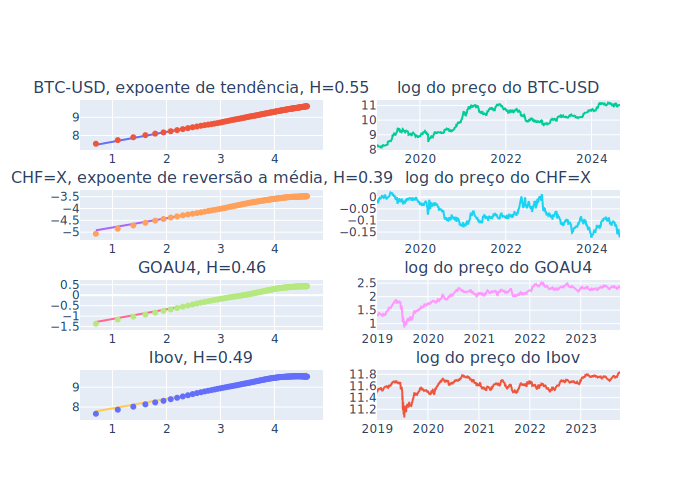

In [52]:
m,x,y = Hvals['BTC-USD']
trace1 = go.Scatter ( x= np.log(x) , y= m[0] * np.log(x) + m[1] )
trace2 = go.Scatter ( x= np.log(x) , y= np.log(y) , mode='markers' )
trace3 = go.Scatter ( x= dfB.index , y= np.log(dfB['BTC-USD'].values) ,mode='lines')

m,x,y = Hvals['CHF=X']
trace4 = go.Scatter ( x= np.log(x) , y= m[0] * np.log(x) + m[1] )
trace5 = go.Scatter ( x= np.log(x) , y= np.log(y) , mode='markers' )
trace6 = go.Scatter ( x= dfB.index , y= np.log(dfB['CHF=X'].values) ,mode='lines')

m1,x,y = get_hurst_exponent(preco[codigo][dfB.index[0]:].dropna().values)
trace7 = go.Scatter ( x= np.log(x) , y= m1[0] * np.log(x) + m1[1] )
trace8 = go.Scatter ( x= np.log(x) , y= np.log(y) , mode='markers' )
trace9 = go.Scatter ( x= dfB.index , y= np.log(preco[codigo][dfB.index[0]:].values) ,mode='lines')

m2,x,y = get_hurst_exponent(preco['ibov'][dfB.index[0]:].dropna().values)
trace10 = go.Scatter ( x= np.log(x) , y= m2[0] * np.log(x) + m2[1] )
trace11 = go.Scatter ( x= np.log(x) , y= np.log(y) , mode='markers' )
trace12 = go.Scatter ( x= dfB.index , y= np.log(preco['ibov'][dfB.index[0]:].values) ,mode='lines')

fig = make_subplots(rows=4, cols=2,#column_widths = [50,20],horizontal_spacing =.15,
                    subplot_titles=(
                        [   f"BTC-USD, expoente de tendência, H={round(Hvals['BTC-USD'][0][0],2)} ",
                            'log do preço do BTC-USD',
                            f'CHF=X, expoente de reversão a média, H={round(Hvals["CHF=X"][0][0],2)}',
                            'log do preço do CHF=X',
                            f"{codigo}, H={round(m1[0],2)} ",
                            f'log do preço do {codigo}',
                            f'Ibov, H={round(m2[0],2)}',
                            'log do preço do Ibov'
                            ]
                        )
                    )



fig.append_trace(trace1, 1, 1)
fig.append_trace(trace2, 1, 1)
fig.append_trace(trace3, 1, 2)

fig.append_trace(trace4, 2, 1)
fig.append_trace(trace5, 2, 1)
fig.append_trace(trace6, 2, 2)

fig.append_trace(trace7, 3, 1)
fig.append_trace(trace8, 3, 1)
fig.append_trace(trace9, 3, 2)

fig.append_trace(trace10, 4, 1)
fig.append_trace(trace11, 4, 1)
fig.append_trace(trace12, 4, 2)

fig.update_layout(showlegend=False)

fig.show()

#### Reversão à média


Uma série temporal contínua com reversão à média pode ser representada por uma equação diferencial estocástica de Ornstein-Uhlenbeck: $dX_t = \theta(\mu-X_t)dt + \sigma dW_t$ onde $\theta$ é a taxa de reversão à média, $\mu$ é o valor  médio do processo, $\sigma$ é a variância do processo e $W_t$ é um Processo de Wiener (Movimento Browniano). Num cenário discreto a equação afirma que a mudança da série de preços no próximo período de tempo é proporcional à diferença entre o preço médio e o preço atual, com a adição de ruído gaussiano.

*Teste Dickey-Fuller Aumentado (ADF)*: testa a presença de uma *raiz unitária* em uma amostra de série temporal autorregressiva. Aproveita o fato de que se uma série de preços possuir reversão à média, então o próximo nível de preços será proporcional ao nível de preços atual. Um modelo linear de *lag* $p$ é usado para a série temporal: $\Delta y_t = \alpha + \beta t + \gamma y_t + \sum_{i=1}^{p-1} \delta_i y_{t-i}$

Onde $\alpha$ é uma constante, $\beta$ representa o coeficiente de uma tendência temporal. O papel do teste de hipótese ADF é considerar a hipótese nula de que $\gamma=0$, o que indicaria (com $\alpha=\beta=0$) que o processo é um passeio aleatório e, portanto, não tem reversão média. Se a hipótese de que $\gamma=0$ pode ser rejeitada, então o movimento seguinte da série de preços é proporcional ao preço atual e, portanto, é improvável que seja um passeio aleatório. A estatística de teste é um número negativo e, portanto, para ser significativo além dos valores críticos, o número deve ser mais negativo que esses valores, ou seja, menor que os valores críticos.

Uma questão prática é que qualquer desvio constante de longo prazo num preço é de uma magnitude muito menor do que qualquer flutuação de curto prazo e, por isso, é frequentemente assumido  $\beta=0$. Além disso, geralmente, é  suficiente definir $p=1$ para nos permitir rejeitar a hipótese nula.

In [53]:
def check_estacionaridade(X, cutoff=0.01):
    '''
    H_0 é nao-estacionário, i.e., admite raiz unitaria (teste adfuller)
  Returns
    test statistic
    pvalue
    used lag
    n obs
    critical values dict at the 1 %, 5 %, and 10 % levels.
    '''

    from statsmodels.tsa.stattools import adfuller

    print(adfuller(X))

    pvalue = adfuller(X)[1]

    if pvalue < cutoff:
        print(f' \n p-value = {pvalue}. A serie é, provavelmente, estacionaria ou estacionaria com tendência com grau de confiança {100*(1-pvalue)}.')
        return True
    else:
        mesg = 'não podemos rejeitar a hipótese nula de que existe uma raiz unitária, e, portanto, é improvável que tenhamos encontrado uma série temporal com reversão à média, o que implica que a série de dados não é estacionária.'
        print("\n".join(textwrap.wrap(mesg,118)))
        return False

In [54]:
check_estacionaridade( preco[codigo])

(-1.849787484919052, 0.356038460363527, 0, 1244, {'1%': -3.4356175602072545, '5%': -2.8638661490437025, '10%': -2.5680084710921105}, -712.830768670492)
não podemos rejeitar a hipótese nula de que existe uma raiz unitária, e, portanto, é improvável que tenhamos
encontrado uma série temporal com reversão à média, o que implica que a série de dados não é estacionária.


False

In [55]:
check_estacionaridade( preco[codigo].pct_change().fillna(0))

(-9.326852738110556, 9.5592956376481e-16, 9, 1235, {'1%': -3.4356560275160835, '5%': -2.8638831211270817, '10%': -2.568017509711682}, -5425.489042006177)
 
 p-value = 9.5592956376481e-16. A serie é, provavelmente, estacionaria ou estacionaria com tendência com grau de confiança 99.9999999999999.


True

#### cointegração

É difícil encontrar um ativo possua um comportamento de reversão à média, a maioria das séries de preços não são estacionárias nem revertem à média, as ações comportam-se geralmente como GBM. Os retornos, e não os preços, são aqueles que geralmente se distribuem aleatoriamente em torno de uma média zero. Infelizmente, não podemos negociar com base na reversão à média dos retornos.

No entanto, podemos fabricar séries de preços com reversão porque muitas vezes podemos combinar duas ou mais séries de preços individuais que não são reversão à média em uma carteira cujo valor líquido de mercado (ou seja, preço) é de reversão à média.

A forma mais simples de estratégias  de reversão à média é a clássica "pair trading", que geralmente envolve um par de ações "long-short" neutro em relação ao mercado. A teoria diz que duas empresas do mesmo setor estarão provavelmente expostas a fatores de mercado semelhantes, que afetam os seus negócios. Ocasionalmente, os preços relativos das suas ações divergirão devido a determinados eventos, mas reverterão para a média de longo prazo. A cointegração é uma relação mais sutil do que a correlação. Se duas séries temporais são cointegradas, existe alguma relação linear entre elas que irá variar em torno de uma média. Em todos os momentos, a combinação entre eles está relacionada à mesma distribuição de probabilidade.


In [56]:
from statsmodels.tsa.stattools import coint

def zscore(series):
    return (series - series.mean()) / np.std(series)

def residuos (x,y)  :
  # slope,intercept, r, pvalue, stderr = stats.linregress(y=y,x=x)
#   from scipy import stats
  return y - stats.linregress(y=y,x=x)[0] * x

In [57]:
IBr=mesmo_setor_tickers

In [58]:
if usar_periodo and len(IBr) > 0:
  IBr_preco = yf.download((pd.Series(IBr)+'.SA').to_list(), period = periodo , progress = False)[qual_preco]
  IBr_preco = IBr_preco.loc[preco.index[0]:]
  IBr_preco.columns=IBr_preco.columns.str.replace(r'\.SA$', '')
elif len(IBr) > 0 :
  IBr_preco = yf.download((pd.Series(IBr)+'.SA').to_list(), start=inicio , end=termino , progress = False)[qual_preco]
  IBr_preco.columns=IBr_preco.columns.str.replace(r'\.SA$', '')

In [59]:
IBr_preco.columns=IBr_preco.columns.str.rstrip('.SA')

In [60]:
pair=pd.DataFrame()
Delta_preco = preco[codigo].diff()[1:]

if check_estacionaridade(Delta_preco) :

  min_score=0.0
  cont=0
  X = pd.Series( preco[codigo])

  print(codigo+' cointegra com ')
  for T in IBr :
      temp = pd.merge(X,IBr_preco[T],left_index=True,right_index=True,how='inner').dropna()
      X= temp.iloc[:,0]
      Y= temp.iloc[:,1]
      t,p,c = coint(X,Y)
      for pvalue in [0.01,0.05, 0.1] :
        if p < pvalue :
          cont+=1
          print(f'{T} no nivel de confiança {(1-pvalue)*100}%', end=" - ")
          if pvalue == 0.01 : vc=c[0]
          elif pvalue == 0.05 : vc=c[1]
          else : vc=c[2]
          print(f'score={t} para o valor crítico {vc} em {len(X)} dias')
          if t < min_score :
            min_score=t
            Min_score=T
            pair = temp
          break


(-34.77074651906579, 0.0, 0, 1243, {'1%': -3.435621806786881, '5%': -2.8638680226791444, '10%': -2.5680094689100477}, -708.5407342191656)
 
 p-value = 0.0. A serie é, provavelmente, estacionaria ou estacionaria com tendência com grau de confiança 100.0.
GOAU4 cointegra com 


/tmp/ipykernel_10056/2254591161.py:15: CollinearityWarning:

y0 and y1 are (almost) perfectly colinear.Cointegration test is not reliable in this case.



GOAU4 no nivel de confiança 99.0% - score=-inf para o valor crítico -3.905265442897613 em 1245 dias


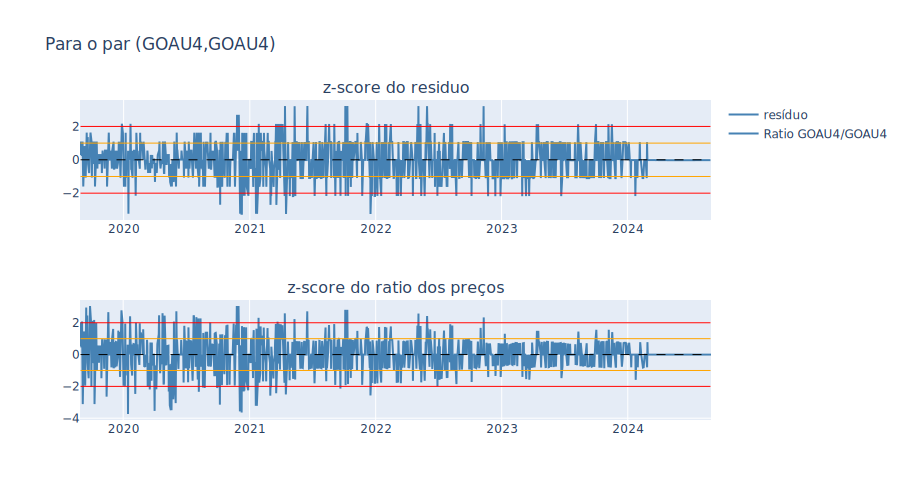

In [61]:
if cont>0 :
  x = pair.iloc[:,0]
  y = pair.iloc[:,1]
  slope,intercept, r, pvalue, stderr = stats.linregress(y=y,x=x)
  residuos =  y - slope * x

  trace1 = go.Scatter( x = residuos.index,  y = zscore(residuos) ,
                      name = 'resíduo',
                      line=dict(color='steelblue'))

  trace2 = go.Scatter( x = y.index,  y = zscore(y/x) ,
                      name = 'Ratio '+Min_score+'/'+codigo,
                      line=dict(color='steelblue'))

  fig = make_subplots(rows=2, cols=1,subplot_titles=(['z-score do residuo','z-score do ratio dos preços']))

  fig.append_trace(trace1, 1, 1)
  fig.append_trace(trace2, 2, 1)

  fig['layout'].update(shapes=[{'type': 'line','y0':1,'y1': 1,'x0':min(residuos.index),'x1':max(residuos.index),
                                'yref':'y1','line': {'color': 'orange','width': 1}},
                              {'type': 'line','y0':-1,'y1': -1,'x0':min(residuos.index),'x1':max(residuos.index),
                                'yref':'y1','line': {'color': 'orange','width': 1}},
                              {'type': 'line','y0':2,'y1': 2,'x0':min(residuos.index),'x1':max(residuos.index),
                                'yref':'y1','line': {'color': 'red','width': 1}},
                              {'type': 'line','y0':-2,'y1': -2,'x0':min(residuos.index),'x1':max(residuos.index),
                                'yref':'y1','line': {'color': 'red','width': 1}},
                              {'type': 'line','y0':0,'y1': 0,'x0':min(residuos.index),'x1':max(residuos.index),
                                'yref':'y1','line': {'color': 'black','width': 1,'dash':'dash'}},
                              {'type': 'line','y0':0,'y1': 0,'x0':min(residuos.index),'x1':max(residuos.index),
                                'yref':'y2','line': {'color': 'black','width': 1,'dash':'dash'}},
                              {'type': 'line','y0':1,'y1': 1,'x0':min(residuos.index),'x1':max(residuos.index),
                                'yref':'y2','line': {'color': 'orange','width': 1}},
                              {'type': 'line','y0':-1,'y1': -1,'x0':min(residuos.index),'x1':max(residuos.index),
                                'yref':'y2','line': {'color': 'orange','width': 1}},
                              {'type': 'line','y0':2,'y1': 2,'x0':min(residuos.index),'x1':max(residuos.index),
                                'yref':'y2','line': {'color': 'red','width': 1}},
                              {'type': 'line','y0':-2,'y1': -2,'x0':min(residuos.index),'x1':max(residuos.index),
                                'yref':'y2','line': {'color': 'red','width': 1}}
                              ],title='Para o par ('+codigo+','+Min_score+')',
                      width=900,
                      height=500)
  fig.show()

cointegração no setor

In [62]:
def find_cointegrated_pairs(data):
    n = data.shape[1]
    score_matrix = np.zeros((n, n))
    pvalue_matrix = np.ones((n, n))
    keys = data.keys()
    pairs = []
    for i in range(n):
        for j in range(i+1, n):
            S1 = data[keys[i]]
            S2 = data[keys[j]]
            result = coint(S1, S2)
            score = result[0]
            pvalue = result[1]
            score_matrix[i, j] = score
            pvalue_matrix[i, j] = pvalue
            if pvalue < 0.05:
                pairs.append((keys[i], keys[j]))
    return score_matrix, pvalue_matrix, pairs

[]

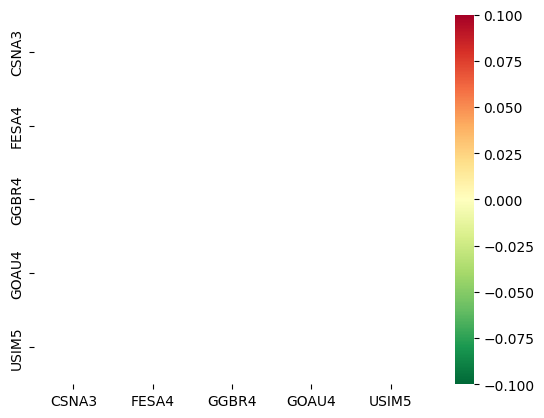

In [63]:
if codigo in IBr_preco.columns: 
    symbol_list = list(IBr_preco.columns)
    scores, pvalues, pairs = find_cointegrated_pairs( IBr_preco.dropna())
else : 
    symbol_list = list(IBr_preco.join(preco[codigo]).columns)
    scores, pvalues, pairs = find_cointegrated_pairs( (IBr_preco.join(preco[codigo])).dropna() )

import seaborn
seaborn.heatmap(pvalues, xticklabels=symbol_list, yticklabels=symbol_list, cmap='RdYlGn_r',
                mask = (pvalues >= 0.05))
pairs

### autocorrelação de preços

A autocorrelação é um conceito estatístico que mede a correlação entre as observações de uma série temporal e seus valores defasados (*lags*). Ajuda a analisar a dependência entre valores passados ​​e presentes e fornece insights sobre a persistência ou reversibilidade dos padrões de dados, o que ajuda a aprender sobre a tendência dos preços das ações.

Por exemplo, com uma série temporal dos preços de fechamento diários, mede a relação entre o preço de fechamento de um determinado dia e os preços de fechamento de dias anteriores. Se o preço de fechamento de hoje estiver positivamente correlacionado com o preço de fechamento do dia anterior, indica autocorrelação positiva, caso contrário, é considerado uma correlação negativa. A autocorrelação positiva sugere impulso de curto prazo ou comportamento de acompanhamento de tendências.

#### Autocorrelação vs Autocorrelação parcial

**Autocorrelação**  (ACF) quantifica a relação linear entre uma observação e suas observações anteriores em diferentes defasagens; mede a correlação global em cada defasagem sem considerar a influência das defasagens intermediárias. Ajuda a identificar a presença de padrões e tendências significativas nos dados. Útil para detectar sazonalidade, identificar a ordem de um modelo autorregressivo (AR) e determinar os valores de defasagem apropriados para previsão.

**Autocorrelação parcial** (PACF) mede a correlação direta entre uma observação e seus valores defasados, ao mesmo tempo que remove a correlação indireta por meio de defasagens intermediárias. Ajuda a identificar as defasagens específicas que influenciam diretamente uma observação sem a influência de outras defasagens; fornece insights sobre a contribuição única de cada defasagem para a observação atual. Útil para determinar a ordem de um modelo de média móvel (MA), identificar a presença de defasagens significativas e construir modelos de média móvel integrada autoregressiva (ARIMA).



In [64]:
from statsmodels.graphics.tsaplots import pacf , acf

def autocorr_plot(series, SIGNIFICANCE_LEVEL = 0.05 , lags=50 , plot_pacf=False):
    corr_array = pacf(series.dropna(),  nlags=lags , alpha= SIGNIFICANCE_LEVEL) if plot_pacf else acf(series.dropna(), nlags=lags,alpha=SIGNIFICANCE_LEVEL)
    lower_y = corr_array[1][:,0] - corr_array[0]
    upper_y = corr_array[1][:,1] - corr_array[0]

    fig = go.Figure()
    [fig.add_scatter(x=(x,x), y=(0,corr_array[0][x]), mode='lines',line_color='#3f3f3f')
     for x in range(len(corr_array[0]))]
    fig.add_scatter(x=np.arange(len(corr_array[0])), y=corr_array[0], mode='markers', marker_color='#1f77b4',
                   marker_size=12)
    fig.add_scatter(x=np.arange(len(corr_array[0])), y=upper_y, mode='lines', line_color='rgba(255,255,255,0)')
    fig.add_scatter(x=np.arange(len(corr_array[0])), y=lower_y, mode='lines',fillcolor='rgba(32, 146, 230,0.3)',
            fill='tonexty', line_color='rgba(255,255,255,0)')
    fig.update_traces(showlegend=False)
    fig.update_xaxes(range=[-1.1,lags+2])
    fig.update_yaxes(range=[-1.1,1.1],zerolinecolor='#000000')

    title='Partial Autocorrelation (PACF)' if plot_pacf else 'Autocorrelation (ACF)'
    fig.update_layout(title=title,width=800,height=380)
    fig.show()

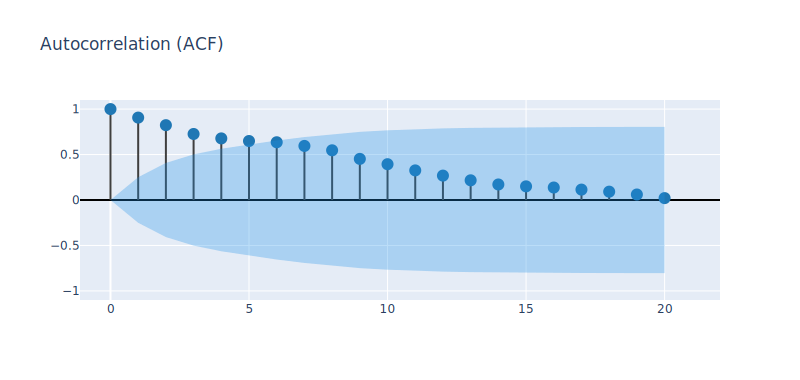

In [65]:
autocorr_plot(preco[codigo].resample('M').last().ffill(),lags=20)

Não analisamos a autocorrelação no *lag* 0, pois o preço atual está perfeitamente correlacionado consigo mesmo. Os valores de *lag* que ficam fora da região azul são estatisticamente significativos. A região azul é o intervalo de confiança, o padrão definido na biblioteca de modelos estatísticos é 95%. Uma lenta deterioração da autocorrelação mostra que os preços estão menos correlacionados com os preços atuais à medida que avançamos mais no passado.


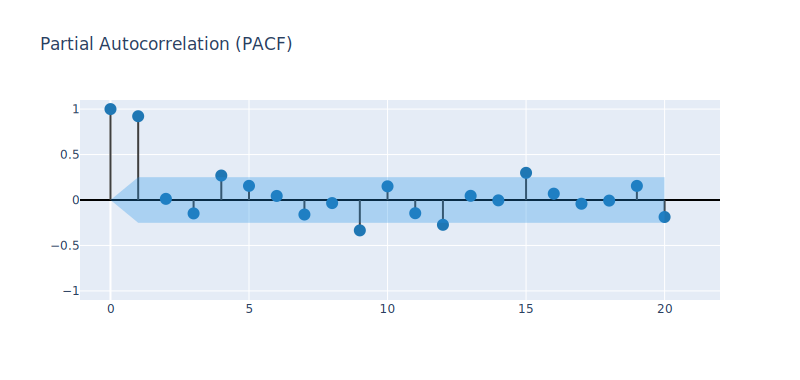

In [66]:
if preco[codigo].resample('M').last().ffill().shape[0] > 40 :
    autocorr_plot(preco[codigo].resample('M').last().ffill(),lags=20,plot_pacf=True)
else:
    autocorr_plot(preco[codigo].resample('M').last().ffill(),lags= int(preco[codigo].resample('M').last().ffill().shape[0]/2),plot_pacf=True)

Na análise técnica, a autocorrelação é normalmente aplicada aos retornos ou alterações no preço, e não aos níveis absolutos de preços. Ao examinar a autocorrelação dos retornos, os analistas podem obter insights sobre a persistência (autocorrelação positiva sugere a presença de uma tendência, indicando que os movimentos de preços passados ​​têm um efeito preditivo sobre os preços futuros) ou a natureza de reversão à média dos movimentos de preços (a autocorrelação negativa indica uma tendência de reversão de preços ou reversão à média).

Alḿe disso,, na análise técnnica, a análise de autocorrelação ajuda a selecionar um período de tempo apropriado para suas estratégias de negociação. Ao observar os padrões de autocorrelação em diferentes *lags* pode-se determinar o horizonte temporal ideal para capturar e explorar os movimentos de preços.

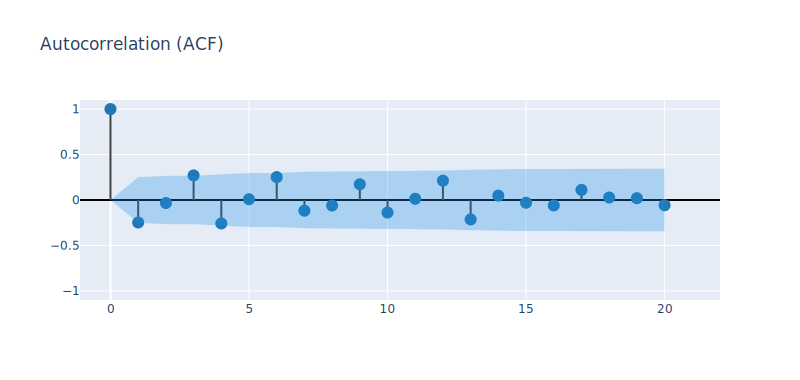

In [67]:
autocorr_plot(Delta_preco.resample('M').last().ffill(),lags=20)

##Drawdown máximo no período


In [68]:
def get_max_drawdown(price):
  data = pd.DataFrame(price)
  column = price.name
  data['max'] = data[column].cummax()
  data['delta'] = data['max'] - data[column]
  data['dd'] = 100 * (data['delta'] / data['max'])
  maxdrawdown = data['dd'].max()
  bottom_day = data['dd'].idxmax()
  bottom_index = data[['dd']].index.get_loc(bottom_day)
  max_value = data.iloc[bottom_index]['max']
  top_day = (data['max'] == max_value).idxmax()
  top_index = data[['max']].index.get_loc(top_day)
  return maxdrawdown, bottom_day, bottom_index, top_day, top_index

In [69]:
dd, bday, bindex, tday, tindex = get_max_drawdown( preco[codigo])
print('max drawdown ', round(dd,2),'% de ', tday.strftime('%d/%m/%Y') , ' até ' , bday.strftime('%d/%m/%Y') )

max drawdown  64.52 % de  20/01/2020  até  23/03/2020


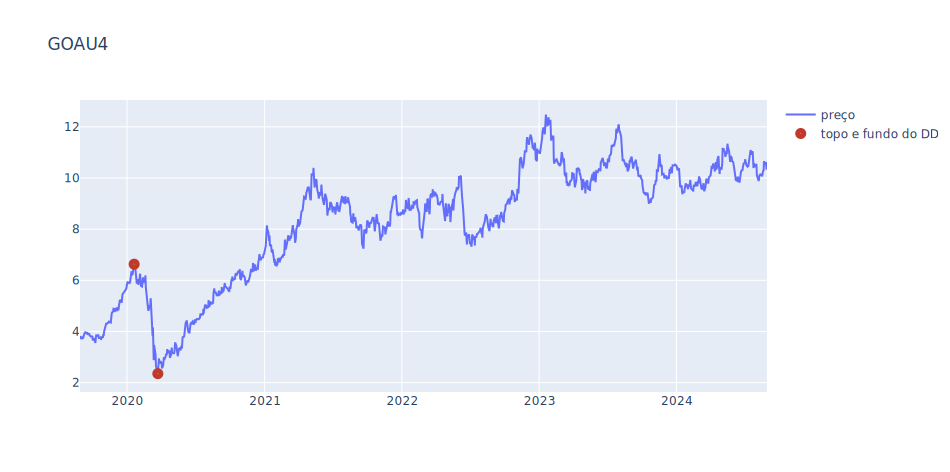

In [70]:
trace1 = go.Scatter(x = preco.index, y = preco[codigo], mode = 'lines' , name = 'preço' )
trace2 = go.Scatter(x = [preco.index[bindex],preco.index[tindex]],
                    y = [ preco[codigo].iloc[bindex] , preco[codigo].iloc[tindex]],
                   mode = 'markers', name = 'topo e fundo do DD',
                   marker =  {'color' : 'orange',
                              'line' : {'width': 5,
                                        'color': '#c0392b'}} )
layout =  dict( title = codigo, height = 472, width = 950, #  font = dict(  size = 10  ),
               )

data_trace = [trace1,trace2]

fig=go.Figure(data=data_trace , layout=layout)
fig.show()

# Retornos


In [71]:
preco['retorno'] = preco[codigo].pct_change()
preco['log_retorno'] = np.log( preco[codigo]) - np.log( preco[codigo].shift(1))
ibov['Preço'] = ibov[qual_preco]
ibov['retorno'] = ibov['Preço'].pct_change()
ibov['log_retorno'] = np.log(ibov['Preço']) - np.log(ibov['Preço'].shift(1))

In [72]:
retornos = pd.merge(ibov['retorno'], preco['retorno'],
                    left_index=True, right_index=True, how='inner')
retornos = retornos.rename(columns={ibov['retorno'].name+'_x':'r_ibov' , preco['retorno'].name+'_y':'r_'+codigo})
retornos['lr_ibov'] = ibov['log_retorno']
retornos['lr_'+codigo] = preco['log_retorno']
retornos.dropna(inplace=True)

print(retornos.shape)
retornos.head(2)

(1244, 4)


,r_ibov,r_GOAU4,lr_ibov,lr_GOAU4
Date,,,,
2019-08-30,0.006078,0.029654,0.006060,0.029223
2019-09-02,-0.005033,-0.014400,-0.005046,-0.014505


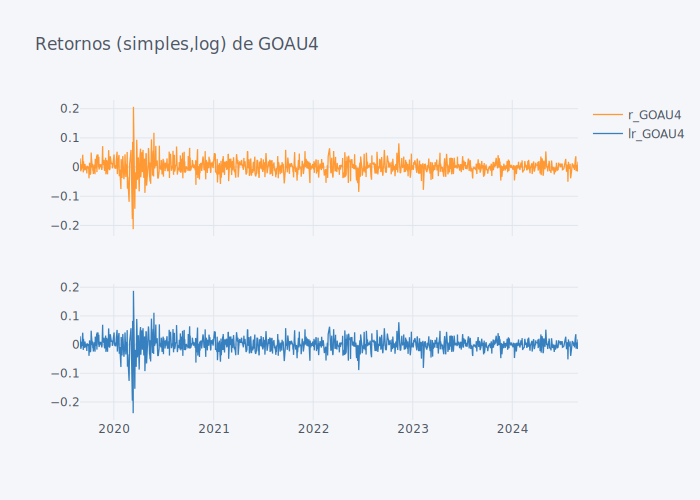

In [73]:
retornos[['r_'+codigo,'lr_'+codigo]].iplot(subplots=True, shape=(2,1), shared_xaxes=True,title='Retornos (simples,log) de '+codigo)

In [74]:
##semanal
weekly_returns = pd.DataFrame()
weekly_returns[codigo] = preco[codigo].resample('W').last().ffill()
weekly_returns['retorno'] =  weekly_returns[codigo].pct_change()
weekly_returns['logretorno'] =  np.log( weekly_returns[codigo]) - np.log(weekly_returns[codigo].shift(1))
weekly_returns.dropna(inplace=True)

##mensal
monthly_returns = pd.DataFrame()
monthly_returns[codigo] = preco[codigo].resample('M').last().ffill()
monthly_returns['retorno'] = monthly_returns[codigo].pct_change()
monthly_returns['logretorno'] = np.log(monthly_returns[codigo]) - np.log(monthly_returns[codigo].shift(1))
monthly_returns.dropna(inplace=True)

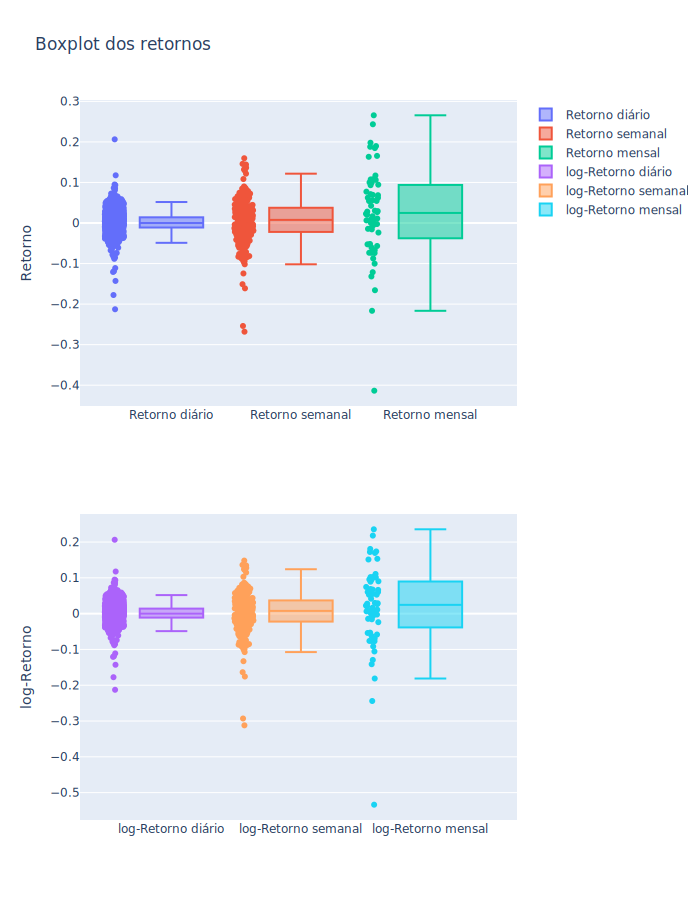

In [75]:
fig = make_subplots(rows=2,cols=1)
fig.add_trace(go.Box(y=retornos['r_'+codigo], name=f'Retorno diário', boxpoints='all', jitter=0.3, pointpos=-1.8),1,1)
fig.add_trace(go.Box(y=weekly_returns['retorno'], name=f'Retorno semanal', boxpoints='all', jitter=0.3, pointpos=-1.8),1,1)
fig.add_trace(go.Box(y=monthly_returns['retorno'], name=f'Retorno mensal', boxpoints='all', jitter=0.3, pointpos=-1.8),1,1)

fig.add_trace(go.Box(y=retornos['r_'+codigo], name=f'log-Retorno diário', boxpoints='all', jitter=0.3, pointpos=-1.8),2,1)
fig.add_trace(go.Box(y=weekly_returns['logretorno'], name=f'log-Retorno semanal', boxpoints='all', jitter=0.3, pointpos=-1.8),2,1)
fig.add_trace(go.Box(y=monthly_returns['logretorno'], name=f'log-Retorno mensal', boxpoints='all', jitter=0.3, pointpos=-1.8),2,1)

fig.update_layout(height=900,title='Boxplot dos retornos',
yaxis1=dict(title='Retorno'),
yaxis2=dict(title='log-Retorno')
)

fig.show()

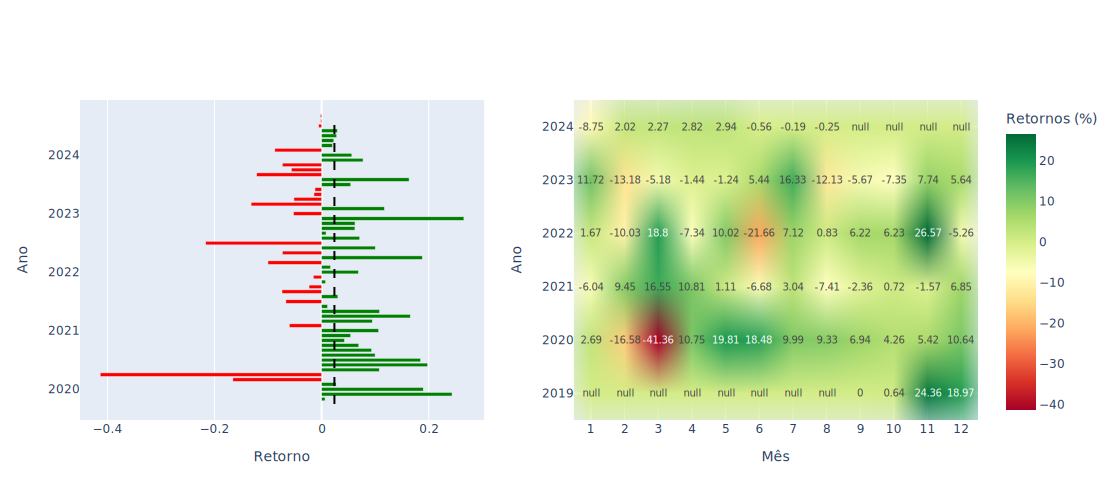

In [76]:
fig = make_subplots(rows=1,cols=2)

# Calcular o retorno médio
mean_return = monthly_returns['retorno'].mean()
neg_returns = monthly_returns[monthly_returns['retorno'] < 0]['retorno']
pos_returns = monthly_returns[monthly_returns['retorno'] >= 0]['retorno']
returns_table = monthly_returns.pivot_table(values='retorno',
                               index=monthly_returns.index.year,
                               columns=monthly_returns.index.month,
                               aggfunc='mean')

fig.add_trace(go.Bar(x=neg_returns, y=neg_returns.index, orientation='h', marker=dict(color='red'), name='Retornos Negativos'),row=1,col=1)
fig.add_trace(go.Bar(x=pos_returns, y=pos_returns.index, orientation='h', marker=dict(color='green'), name='Retornos Positivos'),row=1,col=1)
fig.add_trace(go.Scatter(x=[mean_return, mean_return], y=[monthly_returns.index[0], monthly_returns.index[-1]],
                         mode='lines',
                         line=dict(color='black', dash='dash'),
                         name='Retorno Médio'),row=1,col=1)

# Criar um objeto Heatmap
fig.add_trace(#
go.Heatmap(
    z=returns_table.fillna(0) * 100.0,
    colorscale='RdYlGn',
    colorbar=dict(title='Retornos (%)'),
    hoverongaps=False,
    text= (returns_table* 100.0).round(2),  # Valores dentro das células
    texttemplate="%{text}",
    textfont={"size":10} ),1,2)

fig.update_layout(showlegend=False,width=1111,
    xaxis=dict(title = 'Retorno'),
    xaxis2=dict(title='Mês', tickmode='array', tickvals=list(range(len(returns_table.columns))), ticktext=list(returns_table.columns)),
    yaxis=dict(title='Ano'),
    yaxis2=dict(title='Ano', tickmode='array', tickvals=list(range(len(returns_table.index))), ticktext=list(returns_table.index))
)

# Exibir o gráfico
fig.show()


#### retorno por calendario

todo

In [77]:
retornos.index.dayofweek

Index([4, 0, 1, 2, 3, 4, 0, 1, 2, 3,
       ...
       4, 0, 1, 2, 3, 4, 0, 1, 2, 3],
      dtype='int32', name='Date', length=1244)

In [78]:
# Separando os retornos por dia da semana
retorno_por_dia_da_semana = pd.DataFrame(index=retornos.index)
dias_da_semana = ['segunda', 'terça', 'quarta', 'quinta','sexta']

for i, dia in enumerate(dias_da_semana):
  retorno_por_dia_da_semana[dia] = retornos['r_'+codigo][retornos.index.dayofweek == i]

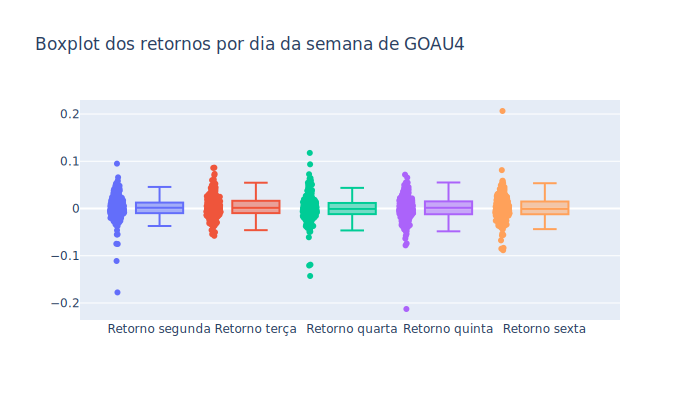

In [79]:
fig = go.Figure()
for dia in dias_da_semana:
    fig.add_trace(go.Box(y=retorno_por_dia_da_semana[dia], name=f'Retorno {dia}', boxpoints='all', jitter=0.3, pointpos=-1.8))


fig.update_layout(height=400,title=f'Boxplot dos retornos por dia da semana de {codigo}',showlegend=False)

# Exibindo o gráfico
fig.show()


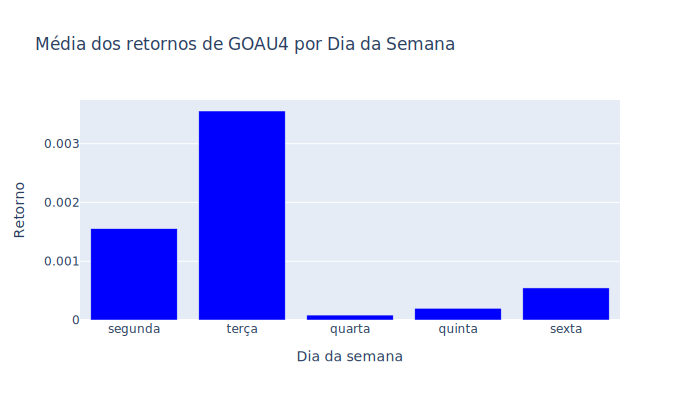

In [80]:
media = retorno_por_dia_da_semana.mean()

trace = go.Bar(
    x=media.index,
    y=media.values,
    marker=dict(color='blue')  # Cor das barras (opcional)
)

# Definindo o layout
layout = go.Layout(height=400,showlegend=False,
    title=f"Média dos retornos de {codigo} por Dia da Semana",
    xaxis=dict(title="Dia da semana"),
    yaxis=dict(title="Retorno")
)

# Criando a figura
fig = go.Figure(data=[trace], layout=layout)

# Exibindo o gráfico
fig.show()

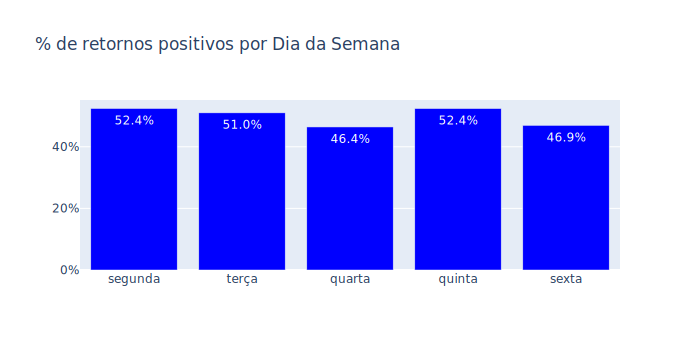

In [81]:
# percuntual de retornos positivos por dia da semana
ret_percentual = retorno_por_dia_da_semana.agg(lambda ret: (ret[ret>0].count() / ret.count()))

fig = go.Figure()

fig.add_trace(go.Bar(
    x=ret_percentual.index,
    y=ret_percentual.values,
    marker=dict(color='blue') , # Cor das barras (opcional)
    text=list(ret_percentual.values),
    textposition='auto',
))

fig.update_traces(texttemplate='%{text:.1%}')
fig.layout.yaxis.tickformat = ".0%"
fig.update_layout(showlegend=False, title = "% de retornos positivos por Dia da Semana " ,height=350)

In [82]:
retorno_por_dia_da_semana.describe()

,segunda,terça,quarta,quinta,sexta
count,248.000000,249.000000,252.000000,250.000000,245.000000
mean,0.001554,0.003556,0.000084,0.000199,0.000545
std,0.025546,0.023005,0.027413,0.027033,0.027541
min,-0.177632,-0.057809,-0.142857,-0.212730,-0.088346
25%,-0.009791,-0.009697,-0.011714,-0.011940,-0.012104
50%,0.001584,0.001406,-0.000846,0.001508,-0.000906
75%,0.012446,0.016084,0.011699,0.015011,0.014807
max,0.094950,0.086400,0.117647,0.071629,0.206383


In [83]:
'''
Testes de Hipóteses
H0 - não há diferença estatística significativa nos retornos entre diferentes dias da semana
Ha - há diferença estatística significativa nos retornos entre diferentes os dias de semana
'''
alpha = 0.05
p_valores = pd.DataFrame(index=dias_da_semana, columns=dias_da_semana)

for dia1 in dias_da_semana:
  for dia2 in dias_da_semana:
    p_valores.at[dia1, dia2] = stats.ttest_ind(retorno_por_dia_da_semana[dia1].dropna(),
                                                 retorno_por_dia_da_semana[dia2].dropna())[1]
p_valores < alpha

,segunda,terça,quarta,quinta,sexta
segunda,False,False,False,False,False
terça,False,False,False,False,False
quarta,False,False,False,False,False
quinta,False,False,False,False,False
sexta,False,False,False,False,False


In [84]:
monthly_returns.index.month

Index([ 9, 10, 11, 12,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12,  1,  2,
        3,  4,  5,  6,  7,  8,  9, 10, 11, 12,  1,  2,  3,  4,  5,  6,  7,  8,
        9, 10, 11, 12,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12,  1,  2,
        3,  4,  5,  6,  7,  8],
      dtype='int32', name='Date')

In [85]:
retorno_por_mes = pd.DataFrame(index=monthly_returns.index)
mes_do_ano = ['jan','fev','mar','abr','mai','jun','jul','ago','set','out','nov','dez']

for i, mes in enumerate(mes_do_ano):
  retorno_por_mes[mes] = monthly_returns['retorno'][monthly_returns.index.month == i]

retorno_por_mes

,jan,fev,mar,abr,mai,jun,jul,ago,set,out,nov,dez
Date,,,,,,,,,,,,
2019-09-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,NaN
2019-10-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.006400,NaN
2019-11-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.243557
2019-12-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-31,NaN,0.026940,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-02-29,NaN,NaN,-0.165792,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-03-31,NaN,NaN,NaN,-0.413619,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-04-30,NaN,NaN,NaN,NaN,0.107527,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-05-31,NaN,NaN,NaN,NaN,NaN,0.198058,NaN,NaN,NaN,NaN,NaN,NaN


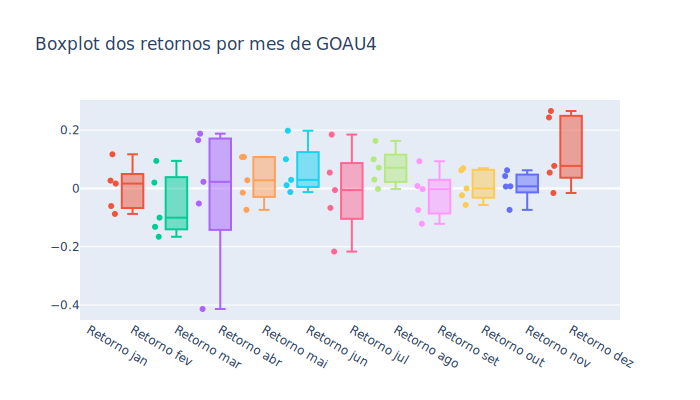

In [86]:
fig = go.Figure()
for mes in mes_do_ano:
    fig.add_trace(go.Box(y=retorno_por_mes[mes], name=f'Retorno {mes}', boxpoints='all', jitter=0.3, pointpos=-1.8))


fig.update_layout(height=400,title=f'Boxplot dos retornos por mes de {codigo}',showlegend=False)

# Exibindo o gráfico
fig.show()


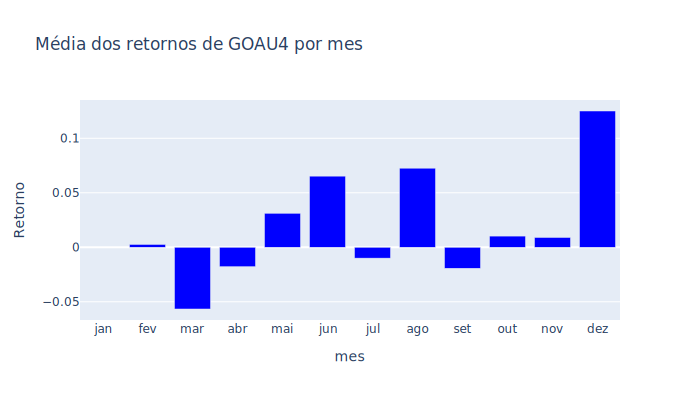

In [87]:
media = retorno_por_mes.mean()

trace = go.Bar(
    x=media.index,
    y=media.values,
    marker=dict(color='blue')  # Cor das barras (opcional)
)

# Definindo o layout
layout = go.Layout(height=400,showlegend=False,
    title=f"Média dos retornos de {codigo} por mes",
    xaxis=dict(title="mes"),
    yaxis=dict(title="Retorno")
)

# Criando a figura
fig = go.Figure(data=[trace], layout=layout)

# Exibindo o gráfico
fig.show()

In [88]:
monthly_returns

,GOAU4,retorno,logretorno
Date,,,
2019-09-30,3.808979,0.000000,0.000000
2019-10-31,3.833357,0.006400,0.006380
2019-11-30,4.766997,0.243557,0.217976
2019-12-31,5.671503,0.189743,0.173738
2020-01-31,5.824292,0.026940,0.026583
2020-02-29,4.858669,-0.165792,-0.181273
2020-03-31,2.849031,-0.413619,-0.533786
2020-04-30,3.155378,0.107527,0.102129
2020-05-31,3.780327,0.198058,0.180702


### normalidade na distribuição dos (log) retornos

---



In [89]:
lr_media = retornos['lr_'+codigo].mean()
lr_variancia = retornos['lr_'+codigo].var()
lr_desviopadrao = retornos['lr_'+codigo].std()

r_media = retornos['r_'+codigo].mean()
r_variancia = retornos['r_'+codigo].var()
r_desviopadrao = retornos['r_'+codigo].std()

In [90]:
jb_test = stats.jarque_bera(retornos['lr_'+codigo].values)

print('---------- Estatisticas Descriptivas ----------')
print('Periodo:', min(retornos.index.date), '-', max(retornos.index.date))
print('Observações:', retornos.shape[0])
print(f'Média: {lr_media:.4f}')
print(f'Mediana: {retornos["lr_"+codigo].median():.4f}')
print(f'Mínimo: {retornos["lr_"+codigo].min():.4f}')
print(f'Máximo: {retornos["lr_"+codigo].max():.4f}')
print(f'Desvio padrão: {lr_desviopadrao:.4f}')
print(f'Assimetria: {retornos["lr_"+codigo].skew():.4f}')
print(f'Curtose: {retornos["lr_"+codigo].kurtosis():.4f}')
print(f'Jarque-Bera teste: {jb_test[0]:.2f} com p-valor {jb_test[1]:.2f}')

---------- Estatisticas Descriptivas ----------
Periodo: 2019-08-30 - 2024-08-29
Observações: 1244
Média: 0.0008
Mediana: 0.0000
Mínimo: -0.2392
Máximo: 0.1876
Desvio padrão: 0.0264
Assimetria: -0.9440
Curtose: 12.0878
Jarque-Bera teste: 7691.18 com p-valor 0.00


 O teste Jarque-Bera utiliza como parâmetros os coeficientes de curtose e assimetria, que na normal são de 3 e 0, respectivamente,  e tem como hipótese nula a normalidade. Assim, se o p-valor for pequeno então rejeita-se a normalidade. O teste, da forma como está formulado, não responde se ela é aproximadamente normal,  o p-valor não diz o quão grande é o desvio em relação à normalidade.

É observado na literatura que os retornos (diários) dos ativos
apresentam o seguinte: *Assimetria negativa* (grandes retornos negativos ocorrem mais frequentemente do que grandes positivos) e *Excesso de curtose* (retornos grandes e pequenos ocorrem com mais frequência
do que o esperado).

Graficamente, podemos comparar a distribuição dos dados com a normal de dois modos: (1) traçar um histograma visualizando a distribuição
de retornos observados sobrepondo uma linha que representa a PDF da distribuição gaussiana com a média e o padrão desvio proveniente da série de retornos observada. Para verificar a existência dos padrões mencionados acima, a *assimetria negativa* resulta na cauda esquerda da  distribuição mais longa, enquanto a massa de a distribuição está concentrada no lado direito da distribuição; o *excesso de curtose* resulta na distribuição de cauda gorda e pontiaguda. (2) traçando seus quantis uns contra os outros (usando o Q-Q plot). Depois de inspecionar o histograma, observamos o gráfico QQ (quantil-quantil). No grafico abaixo, distribuição teórica é Gaussiana (Normal) e a distribuição observada um vem dos retornos. Se a distribuição empírica for gaussiana, então a grande maioria dos pontos ficará na linha vermelha. No entanto,os pontos do lado esquerdo do gráfico são mais negativos do que o esperado no caso da distribuição gaussiana, como indicado pela linha, significa que a cauda esquerda da distribuição de retornos é mais pesada que o da distribuição gaussiana. Conclusões analogas valem par a cauda direita, que é mais pesada do que na normal.


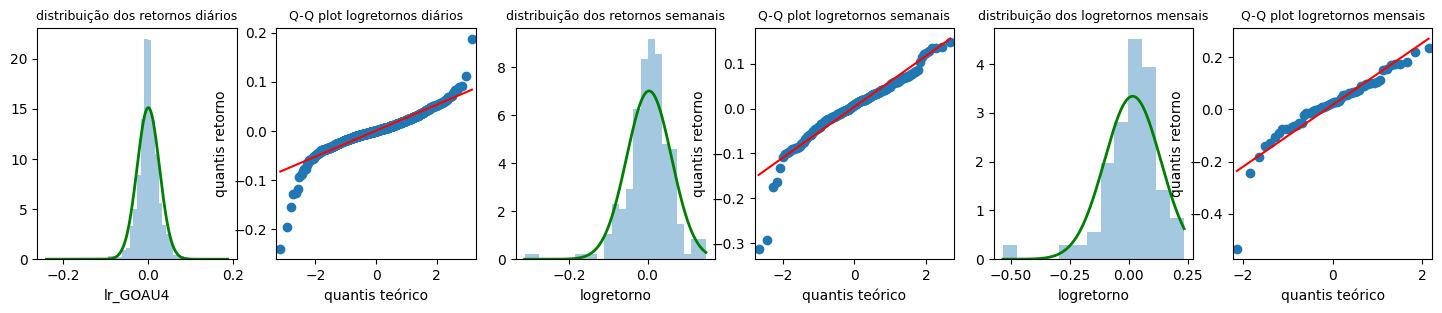

In [91]:
import matplotlib.pyplot as plt
import seaborn as sns

r_fig, ax = plt.subplots(1, 6 , figsize=(18,3))

r_range = np.linspace(min( retornos['lr_'+codigo]), max( retornos['lr_'+codigo]), num=1000)

## histograma diário
sns.distplot( retornos['lr_'+codigo], kde=False, norm_hist=True, ax=ax[0])
ax[0].set_title('distribuição dos retornos diários' , fontsize=9)
ax[0].plot(r_range, stats.norm.pdf(r_range, loc=lr_media, scale=lr_desviopadrao) ,#
           'g', lw=2,label=f'N({lr_media:.2f}, {lr_variancia:.4f})')
# Q-Q plot diário
qq1 = sm.qqplot( retornos['lr_'+codigo].values, line='s', ax=ax[1])
ax[1].set_title('Q-Q plot logretornos diários' , fontsize = 9)
ax[1].set(xlabel = 'quantis teórico', ylabel = 'quantis retorno')

##semanal
r_range = np.linspace(min(weekly_returns['logretorno']), max(weekly_returns['logretorno']), num=1000)
w_m = weekly_returns['logretorno'].mean()
w_s = weekly_returns['logretorno'].std()

# histograma semanal
sns.distplot(weekly_returns['logretorno'] , kde=False, norm_hist=True, ax=ax[2])
ax[2].set_title('distribuição dos retornos semanais' , fontsize=9)
ax[2].plot(r_range, stats.norm.pdf(r_range, loc= w_m, scale= w_s),
           'g', lw=2,label=f'N({w_m:.2f}, {w_s**2:.4f})')
# Q-Q plot semanal
qq2 = sm.qqplot(weekly_returns['logretorno'].values, line='s', ax=ax[3])
ax[3].set_title('Q-Q plot logretornos semanais', fontsize = 9)
ax[3].set(xlabel = 'quantis teórico', ylabel = 'quantis retorno')


##mensal
r_range = np.linspace(min(monthly_returns['logretorno']), max(monthly_returns['logretorno']), num=1000)
w_m = monthly_returns['logretorno'].mean()
w_s = monthly_returns['logretorno'].std()

# histograma mensal
sns.distplot(monthly_returns['logretorno'] , kde=False, norm_hist=True, ax=ax[4])
ax[4].set_title('distribuição dos logretornos mensais' , fontsize=9)
ax[4].plot(r_range, stats.norm.pdf(r_range, loc= w_m, scale= w_s),
           'g', lw=2,label=f'N({w_m:.2f}, {w_s**2:.4f})')
# Q-Q plot mensal
qq2 = sm.qqplot(monthly_returns['logretorno'].values, line='s', ax=ax[5])
ax[5].set_title('Q-Q plot logretornos mensais' , fontsize = 9)
ax[5].set(xlabel = 'quantis teórico', ylabel = 'quantis retorno')

# fig.tight_layout()
r_fig.show()

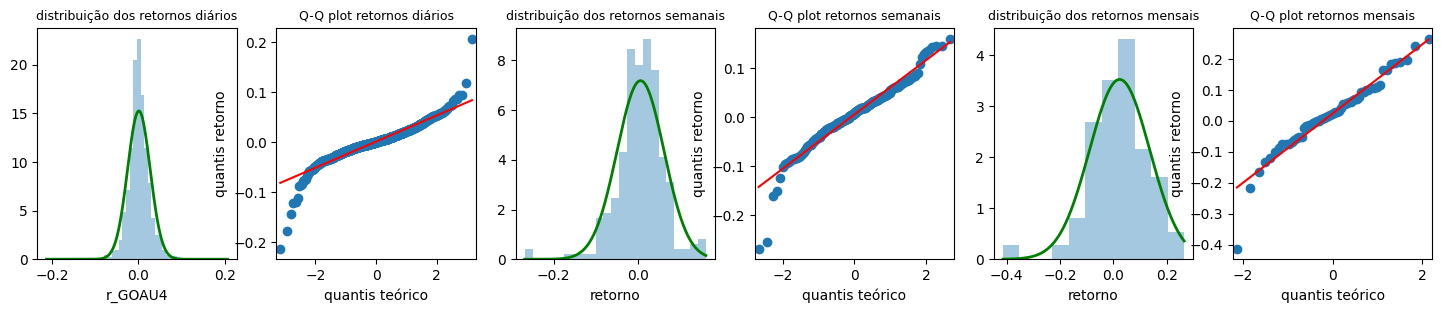

In [92]:
#@markdown para o retorno simples
r_fig, ax = plt.subplots(1, 6 , figsize=(18,3))

r_range = np.linspace(min( retornos['r_'+codigo]), max( retornos['r_'+codigo]), num=1000)

## histograma diário
sns.distplot( retornos['r_'+codigo], kde=False, norm_hist=True, ax=ax[0])
ax[0].set_title('distribuição dos retornos diários' , fontsize=9)
ax[0].plot(r_range, stats.norm.pdf(r_range, loc=r_media, scale=r_desviopadrao) ,#
           'g', lw=2,label=f'N({r_media:.2f}, {r_variancia:.4f})')
# Q-Q plot diário
qq1 = sm.qqplot( retornos['r_'+codigo].values, line='s', ax=ax[1])
ax[1].set_title('Q-Q plot retornos diários' , fontsize = 9)
ax[1].set(xlabel = 'quantis teórico', ylabel = 'quantis retorno')

##semanal
r_range = np.linspace(min(weekly_returns['retorno']), max(weekly_returns['retorno']), num=1000)
w_m = weekly_returns['retorno'].mean()
w_s = weekly_returns['retorno'].std()

# histograma semanal
sns.distplot(weekly_returns['retorno'] , kde=False, norm_hist=True, ax=ax[2])
ax[2].set_title('distribuição dos retornos semanais' , fontsize=9)
ax[2].plot(r_range, stats.norm.pdf(r_range, loc= w_m, scale= w_s),
           'g', lw=2,label=f'N({w_m:.2f}, {w_s**2:.4f})')
# Q-Q plot semanal
qq2 = sm.qqplot(weekly_returns['retorno'].values, line='s', ax=ax[3])
ax[3].set_title('Q-Q plot retornos semanais', fontsize = 9)
ax[3].set(xlabel = 'quantis teórico', ylabel = 'quantis retorno')


##mensal
r_range = np.linspace(min(monthly_returns['retorno']), max(monthly_returns['retorno']), num=1000)
w_m = monthly_returns['retorno'].mean()
w_s = monthly_returns['retorno'].std()

# histograma mensal
sns.distplot(monthly_returns['retorno'] , kde=False, norm_hist=True, ax=ax[4])
ax[4].set_title('distribuição dos retornos mensais' , fontsize=9)
ax[4].plot(r_range, stats.norm.pdf(r_range, loc= w_m, scale= w_s),
           'g', lw=2,label=f'N({w_m:.2f}, {w_s**2:.4f})')
# Q-Q plot mensal
qq2 = sm.qqplot(monthly_returns['retorno'].values, line='s', ax=ax[5])
ax[5].set_title('Q-Q plot retornos mensais' , fontsize = 9)
ax[5].set(xlabel = 'quantis teórico', ylabel = 'quantis retorno')

# fig.tight_layout()
r_fig.show()

In [93]:
from scipy.stats import skew, kurtosis
window=63
curtose_movel =  retornos['r_'+codigo].rolling(window).apply(lambda x: kurtosis(x), raw=False)
assimetria_movel =  retornos['r_'+codigo].rolling(window).apply(lambda x: skew(x), raw=False)

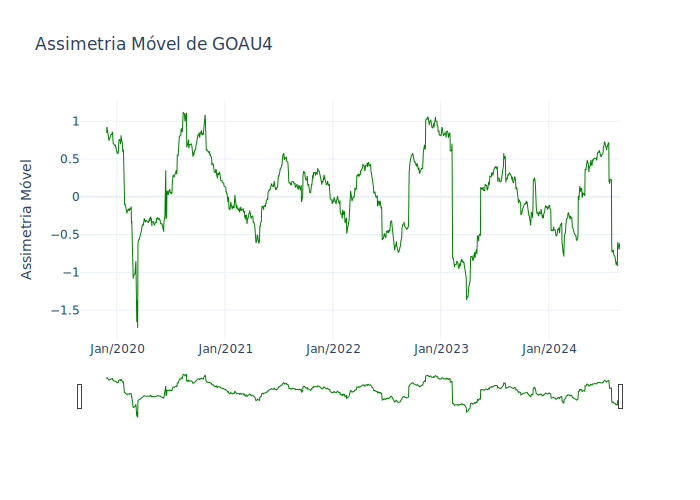

In [94]:
fig = go.Figure(data=[go.Scatter(
    x=assimetria_movel.index,  # Assumindo que 'Date' é o índice do DataFrame
    y=assimetria_movel,
    line=dict(color='green', width=1)
)])

fig.update_layout(
    title=f"Assimetria Móvel de {codigo}",
    xaxis_title="",
    yaxis_title="Assimetria Móvel",
    xaxis_tickformat="%b/%Y",
    xaxis_rangeslider_visible=True,  # Adiciona um slider de zoom no eixo x
    template="plotly_white"
)

fig.show()

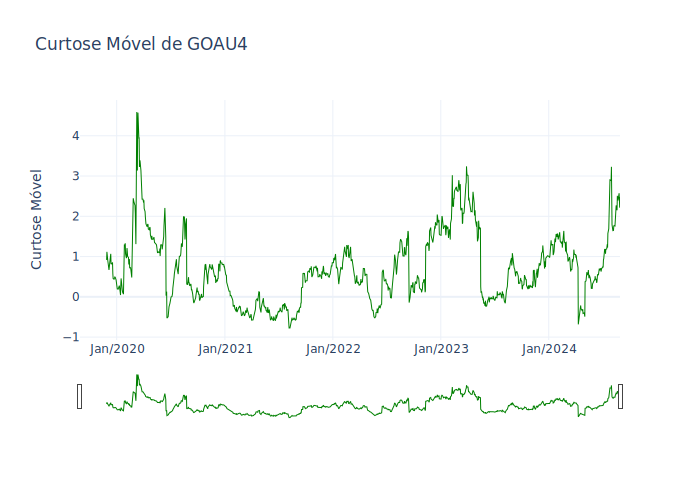

In [95]:
fig = go.Figure(data=[go.Scatter(
    x=curtose_movel.index,  # Assumindo que 'Date' é o índice do DataFrame
    y=curtose_movel,
    line=dict(color='green', width=1)
)])

fig.update_layout(
    title=f"Curtose Móvel de {codigo}",
    xaxis_title="",
    yaxis_title="Curtose Móvel",
    xaxis_tickformat="%b/%Y",
    xaxis_rangeslider_visible=True,  # Adiciona um slider de zoom no eixo x
    template="plotly_white"
)

fig.show()

In [96]:
 #@markdown tentativa de qq plot no plotly

# from statsmodels.graphics.gofplots import qqplot

# qqplot_data_D = qqplot(retornos['r_'+codigo], line='s').gca().lines
# qqplot_data_S = qqplot(weekly_returns['retorno'], line='s').gca().lines
# qqplot_data_M = qqplot(monthly_returns['retorno'], line='s').gca().lines

# fig = make_subplots(rows=3,cols=1)

# fig.add_trace(go.Scatter(x= qqplot_data_D[0].get_xdata(),y= qqplot_data_D[0].get_ydata(),mode='markers', marker= dict(color='#19d3f3')),1,1)
# fig.add_trace(go.Scatter(x= qqplot_data_D[1].get_xdata(),y= qqplot_data_D[1].get_ydata(),mode='lines', line=dict(color='#636efa')),1,1)
# fig.add_trace(go.Scatter(x= qqplot_data_S[0].get_xdata(),y= qqplot_data_D[0].get_ydata(),mode='markers', marker= dict(color='#19d3f3')),2,1)
# fig.add_trace(go.Scatter(x= qqplot_data_S[1].get_xdata(),y= qqplot_data_D[1].get_ydata(),mode='lines', line=dict(color='#636efa')),2,1)
# fig.add_trace(go.Scatter(x= qqplot_data_M[0].get_xdata(),y= qqplot_data_D[0].get_ydata(),mode='markers', marker= dict(color='#19d3f3')),3,1)
# fig.add_trace(go.Scatter(x= qqplot_data_M[1].get_xdata(),y= qqplot_data_D[1].get_ydata(),mode='lines', line=dict(color='#636efa')),3,1)

# fig.update_layout(showlegend=False,width=800,height=70
#     # xaxis=dict(title = 'Retorno'),
#     # xaxis2=dict(title='Mês', tickmode='array', tickvals=list(range(len(returns_table.columns))), ticktext=list(returns_table.columns)),
#     # yaxis=dict(title='Ano'),
#     # yaxis2=dict(title='Ano', tickmode='array', tickvals=list(range(len(returns_table.index))), ticktext=list(returns_table.index))
# )
# # fig.update_layout(title='Q-Q Plot',showlegend=False,width=800,height=700)
# # fig.update_xaxes1(title='Theoritical Quantities',zeroline=False)
# # # fig.update_yaxes(title='Sample Quantities')

# fig.show()

#### Autocorrelação dos retornos

é esperado que nenhuma (ou quase nenhuma) autocorrelação significativa seja observada nos retornos


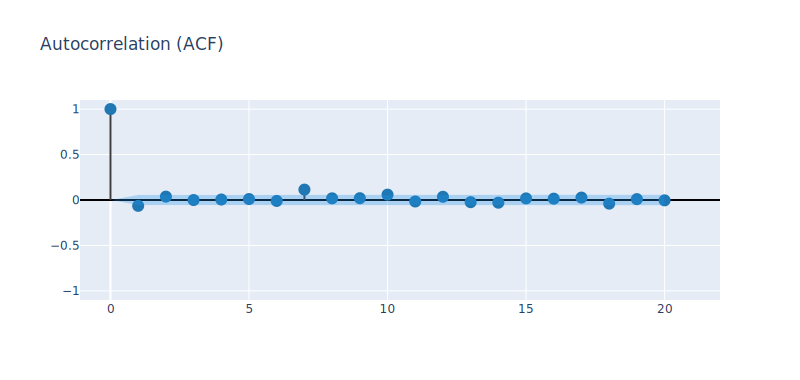

In [97]:
autocorr_plot(retornos['lr_'+codigo],lags=20)

Apenas valores  fora do intervalo de confiança (faixa azul claro, não considera o 0) podem ser considerado estatisticamente significativo; na ausência deles podemos supor que verificamos que não há autocorrelação na série.

A seguir, os gráficos *ACF de retornos quadrados e absolutos*. Valores pequenos e decrescentes são propriedades estatísticas esperada nos retornos empíricos, isto é, autocorrelação pequena e lentamente decrescente lentamente em retornos quadrados e absolutos.

A variância é basicamente a média dos erros quadráticos, enquanto o desvio absoluto é a média dos erros absolutos. No caso de retornos de ativos podemos observar períodos de alta/baixa volatilidade (agrupamento de volatilidade) no gráfico de retornos logarítmicos. Por outro lado, espera-se que a média dos retornos de curto prazo (diários) no longo prazo seja zero. É por isso que, ao observar os retornos quadrados e absolutos, estamos efetivamente medindo o desvio da média esperada, sem olhar para a direção do erro — tanto as funções quadradas como as absolutas anulam a direção do erro.


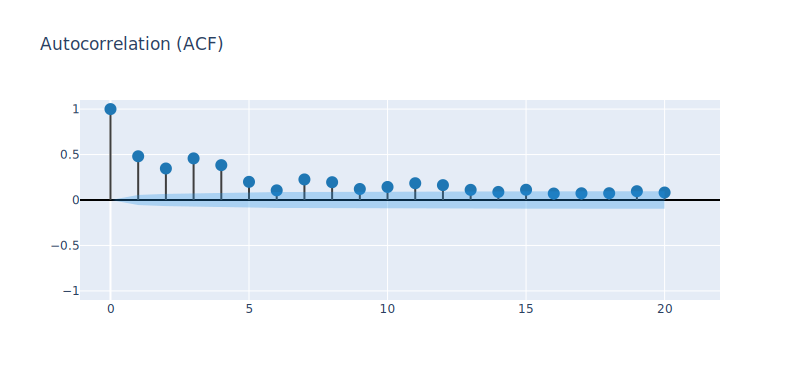

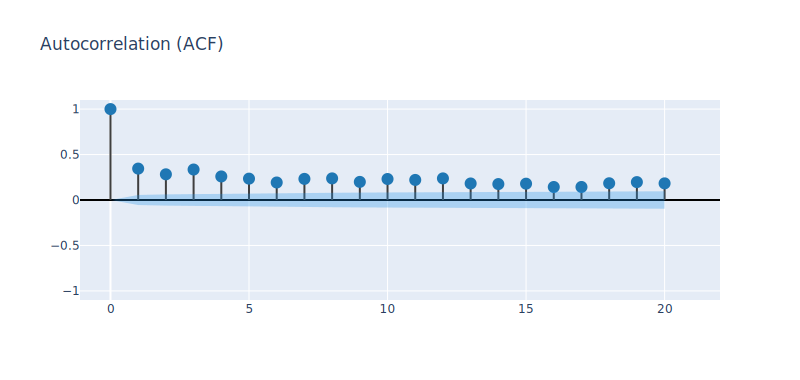

In [98]:
autocorr = pd.DataFrame()
autocorr['quad'] = autocorr_plot(retornos['lr_'+codigo]** 2,lags=20)
autocorr['abs'] = autocorr_plot(np.abs(retornos['lr_'+codigo]),lags=20)

### comparação de retornos com ibov

In [99]:
print('-- Estatísticas do retorno diário')
tmp = [['Intervalo de datas' , str(min(retornos.index.date))+' ~ '+str(max(retornos.index.date)) , str(min(retornos.index.date))+' ~ '+str(max(retornos.index.date))],
       ['no. de observações' , retornos['r_'+codigo].shape[0] , retornos['r_ibov'].shape[0]],
       ['min', str(round( retornos['r_'+codigo].min()*100,3))+'%', str(round( retornos['r_ibov'].min()*100,3))+'%'],
       ['max', str(round( retornos['r_'+codigo].max()*100,3))+'%', str(round( retornos['r_ibov'].max()*100,3))+'%'],
       ['média', str(round( retornos['r_'+codigo].mean()*100,3))+'%', str(round( retornos['r_ibov'].mean()*100,3))+'%'],
       ['mediana', str(round( retornos['r_'+codigo].median()*100,3))+'%', str(round( retornos['r_ibov'].median()*100,3))+'%'],
       ['desvio padrão', str(round( retornos['r_'+codigo].std()*100,3))+'%', str(round( retornos['r_ibov'].std()*100,3))+'%'],
       ['assimetria', round( retornos['r_'+codigo].skew(),3), round( retornos['r_ibov'].skew(),3)],
       ['curtose', round( retornos['r_'+codigo].kurtosis(),3), round( retornos['r_ibov'].kurtosis(),3)],
       ['retorno anualizado',str(round( retornos['r_'+codigo].mean()*252*100,2))+'%' , str(round( retornos['r_ibov'].mean()*252*100,2))+'%'],
       ['dp anualizado',str(round( retornos['r_'+codigo].std()*np.sqrt(252)*100,2))+'%' , str(round( retornos['r_ibov'].std()*np.sqrt(252)*100,2))+'%'],
      ]
vol = pd.DataFrame(tmp , columns=['tmp' , 'r_'+codigo , 'r_ibov'], index=[i[0] for i in tmp])
vol.drop('tmp',axis=1, inplace=True)
vol
# data_table.DataTable(vol , include_index=True ,num_rows_per_page=15)

-- Estatísticas do retorno diário


,r_GOAU4,r_ibov
Intervalo de datas,2019-08-30 ~ 2024-08-29,2019-08-30 ~ 2024-08-29
no. de observações,1244,1244
min,-21.273%,-14.78%
max,20.638%,13.908%
média,0.119%,0.038%
mediana,0.0%,0.057%
desvio padrão,2.615%,1.622%
assimetria,-0.446,-1.049
curtose,10.236,19.674
retorno anualizado,29.89%,9.49%


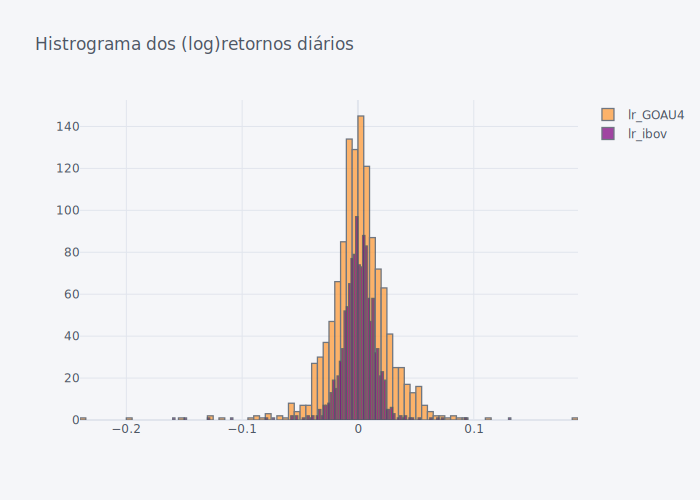

In [100]:
#@markdown histogramas dos (log)retornos diários

retornos.iplot(kind='histogram',
                  #subplots=True,
                  keys = ['lr_'+codigo,'lr_ibov'],
                  colors=['orange','purple'],
                  title='Histrograma dos (log)retornos diários',
                  #theme="henanigans"
                  )

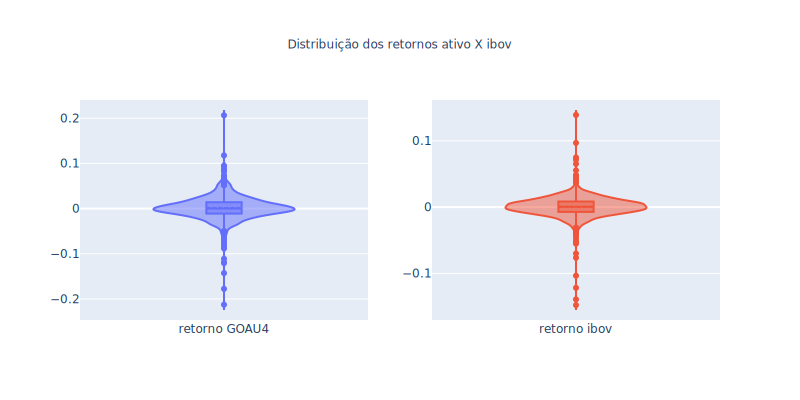

In [101]:
title = "Distribuição dos retornos ativo X ibov"

fig = make_subplots(rows=1, cols=2)

fig.add_trace(
    go.Violin(meanline_visible=True, box_visible = True, y= retornos['r_'+codigo].values, name='retorno '+codigo)
    ,row=1, col=1)
fig.add_trace(
    go.Violin(meanline_visible=True, box_visible = True, y= retornos['r_ibov'], name='retorno ibov')
    ,row=1, col=2)
fig.update_layout(title_font_size=12 , width=800 , height=400 , showlegend=False,
               title={'text': title,'y':0.9,'x':0.5,'xanchor': 'center','yanchor': 'top'},   )

fig.show()

In [102]:
stats.norm.interval(confidence=0.98,
              loc= retornos['r_ibov'].mean(),
              scale=retornos['r_ibov'].std())

(-0.03736747956746739, 0.03812068040350454)

Dados mensais

In [103]:
url_bcb_ipca= f"http://api.bcb.gov.br/dados/serie/bcdata.sgs.433/dados?formato=csv"
ipca = pd.read_csv(url_bcb_ipca, sep=';' , decimal=',')
ipca['data'] = pd.to_datetime(ipca['data'], dayfirst=True)
ipca.set_index('data', inplace=True)
ipca.rename(columns={'valor': 'ipca (% m)'}, inplace=True)
ipca.head(3)

,ipca (% m)
data,
1980-02-01,4.62
1980-03-01,6.04
1980-04-01,5.29


In [106]:
url_bcb_cdi= f"http://api.bcb.gov.br/dados/serie/bcdata.sgs.4391/dados?formato=csv"
cdi = pd.read_csv(url_bcb_cdi, sep=';', decimal=',')
cdi['data'] = pd.to_datetime(cdi['data'], dayfirst=True)
cdi.set_index('data', inplace=True)
cdi.rename(columns={'valor': 'cdi (% m)'}, inplace=True)
cdi

,cdi (% m)
data,
1986-08-01,2.90
1986-09-01,3.30
1986-10-01,3.45
1986-11-01,5.22
1986-12-01,10.50
...,...
2024-04-01,0.89
2024-05-01,0.83
2024-06-01,0.79


In [108]:
url_bcb = f"http://api.bcb.gov.br/dados/serie/bcdata.sgs.12466/dados?formato=csv"
ima = pd.read_csv(url_bcb, sep=';', decimal=',' )
ima['data'] = pd.to_datetime(ima['data'], dayfirst=True)
ima.set_index('data', inplace=True)
ima.rename(columns={'valor': 'ima-b'}, inplace=True)

In [111]:
imaB = ima.resample('MS').first()
imaB['ima-b (% m)'] = imaB['ima-b'].pct_change()*100
imaB.dropna(inplace=True)
imaB.drop('ima-b', axis='columns', inplace=True)
imaB.head(3)

,ima-b (% m)
data,
2004-05-01,0.014357
2004-06-01,-0.320618
2004-07-01,1.390098


In [112]:
indexes = pd.merge(pd.merge(ipca,cdi,left_index=True, right_index=True,how='inner'),imaB,left_index=True, right_index=True,how='inner')
indexes.tail()

,ipca (% m),cdi (% m),ima-b (% m)
data,,,
2023-01-01,0.53,1.12,-0.578634
2023-02-01,0.84,0.92,0.757020
2023-03-01,0.71,1.17,1.159763
2023-04-01,0.61,0.92,2.921565
2023-05-01,0.23,1.12,1.760319


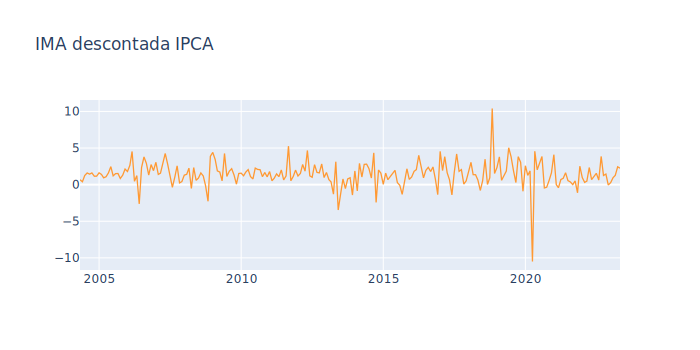

In [114]:
((indexes['ima-b (% m)'] +1)/(indexes['ipca (% m)'] +1)).iplot(layout=dict(title="IMA descontada IPCA",height=350, width=700))

In [115]:
REmonthly_returns = pd.DataFrame()
REmonthly_returns[codigo+'(% m)'] = (preco[codigo].resample('MS').first().ffill()).pct_change()*100
REmonthly_returns['ibov (% m)'] = (preco['ibov'].resample('MS').first().ffill()).pct_change()*100
REmonthly_returns.dropna(inplace=True)
REmonthly_returns.tail(3)

,GOAU4(% m),ibov (% m)
Date,,
2024-06-01,-2.064922,-4.004028
2024-07-01,2.394637,2.201062
2024-08-01,-0.841897,2.146442


In [116]:
allreturns = pd.merge(indexes,REmonthly_returns[['ibov (% m)',codigo+'(% m)']],left_index=True, right_index=True,how='inner')
allreturns.tail(3)

,ipca (% m),cdi (% m),ima-b (% m),ibov (% m),GOAU4(% m)
2023-03-01,0.71,1.17,1.159763,-7.050569,-8.866999
2023-04-01,0.61,0.92,2.921565,-2.758059,-7.184034
2023-05-01,0.23,1.12,1.760319,0.414754,-5.453026


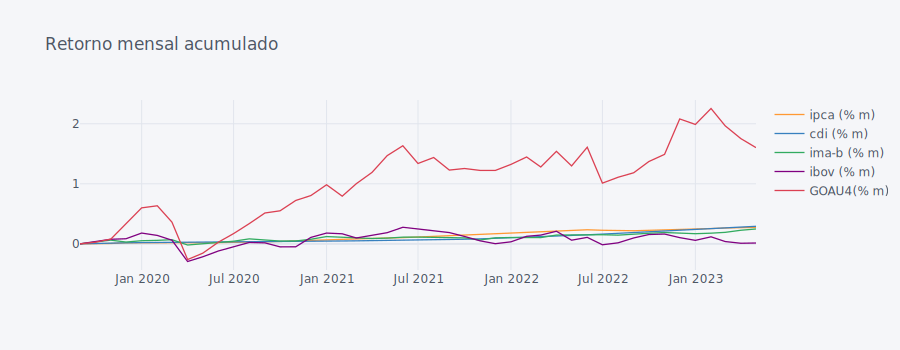

In [117]:
cumulative_allreturns = (1 + allreturns/100).cumprod()  - 1
cumulative_allreturns.iloc[0]=0
cumulative_allreturns.iplot(title= 'Retorno mensal acumulado',dimensions=(900,350))

### Beta

Beta pode ser interpretado como o nível de sensibilidade do retorno do ativo, em comparação com o mercado em geral.  Se o preço da ação sofrer movimentos maiores (mais voláteis) do que os do mercado de ações, o valor $\beta$ será maior que 1. Se os movimentos ou oscilações do preço de uma ação forem menores que os do mercado, o valor $\beta$ será ser menor que 1. Como o aumento da volatilidade do preço das ações significa mais riscos para o investidor, é razoável esperar maiores retornos das ações com $\beta$ acima de 1. O inverso é verdadeiro se o $\beta$ de uma ação for menor que 1, esperamos menos volatilidade, menor risco e, portanto, menores retornos gerais.


|             | Interpretação                                              |
| ----------- | ------------------------------------------------------------ |
| $\beta>1$   | *Risco alto*. Ações mais voláteis, mais agressivas, retorno esperado acima do mercado. |
| $\beta<1$   | *Risco baixo*. Ações menos voláteis, mais defensivas, retorno esperado abaixo do mercado. |
| $\beta=1$   | *Risco do mercado*. Retorno esperado igual ao retorno do mercado |
| $\beta = 0$ | Nesse caso não há risco, o retorno esperado será igual ao ativo livre de risco |
| $\beta < 0$ | O ativo caminha em direção oposta ao do mercado. |


Se $r_a$ é o retorno do ativo e $r_m$ o retorno do *benchmark* (mercado aqui) então
$$
\beta = \frac{\text{Cov}(r_a,r_m)}{\text{Var}(r_m)}
$$
De outro ponto de vista, o $\beta$  é o coeficiente angular de uma regressão linear dos excessos de retornos do ativo contra do mercado
$$
r_a - r_f = \alpha + \beta ( r_m - r_f)
$$
$r_f$ é a taxa livre de risco (usamos a selic).

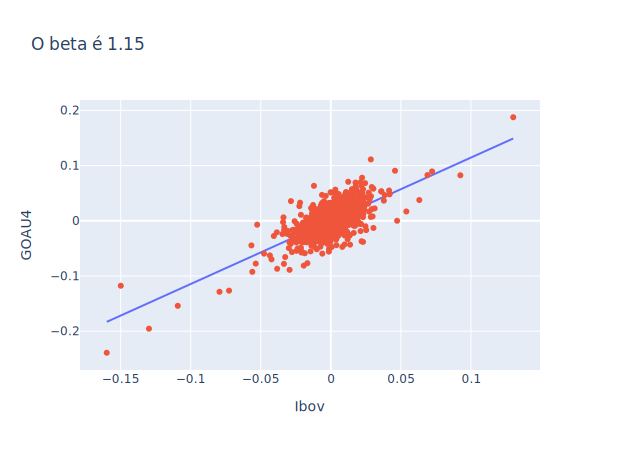

In [118]:
X = retornos['lr_ibov']
y = retornos['lr_'+codigo]
x = sm.add_constant(X)
beta_model = sm.OLS(y, x)
result = beta_model.fit()

intercept,slope = result.params

line_x = np.linspace(retornos['lr_ibov'].min(), retornos['lr_ibov'].max(),100)
line_y = slope*line_x + intercept



trace1 = go.Scatter(x = line_x,y =slope*line_x, mode = 'lines' )

trace2 = go.Scatter(x = retornos['lr_ibov'], y=retornos['lr_'+codigo] , mode ='markers')

layout = dict(title = f'O beta é {slope:.2f}',
              xaxis_title="Ibov",
              yaxis_title=codigo,
              height = 450,width = 620,
              showlegend=False,
              font = dict(size = 12),    )

data_trace = [trace1,trace2]

fig = go.Figure(data=data_trace , layout=layout)

fig.show()

In [119]:
url_bcb_selic= f"http://api.bcb.gov.br/dados/serie/bcdata.sgs.432/dados?formato=csv"
selic = pd.read_csv(url_bcb_selic, sep=';', decimal=',')
selic['data'] = pd.to_datetime(selic['data'], dayfirst=True)
selic.set_index('data', inplace=True)
selic.rename(columns={'valor': 'selic'}, inplace=True)
# print("selic atual (%): ",selic.tail(1).values[0][0])

In [120]:
expected_return = selic.tail(1).values[0][0]/100 + slope * (retornos['lr_ibov'].mean()*12 -selic.tail(1).values[0][0]/100 )
print("Retorno esperado anualizado: ", expected_return)

Retorno esperado anualizado:  -0.011915004045609079


In [121]:
X.cov(y) /  X.var() ## beta pela covariancia

1.145311339394248

In [122]:

data = {'valor': [10.5, 15.2, 20.7, 25.3, 30.1]}
dates = pd.date_range(start='2022-01-01', periods=len(data['valor']), freq='D')

df = pd.DataFrame(data, index=dates)
print(df)
# Data a partir da qual você deseja somar o valor constante
data_inicial = '2022-01-03'

# Valor constante a ser adicionado
valor_constante = 5.0

# Condição para as datas a partir da data_inicial
condicao = df.index >= pd.to_datetime(data_inicial)

# Atualizar a coluna 'valor' somando o valor constante apenas para as datas após data_inicial
df.loc[condicao, 'valor'] += valor_constante

# Exibir o DataFrame resultante
print(df)

            valor
2022-01-01   10.5
2022-01-02   15.2
2022-01-03   20.7
2022-01-04   25.3
2022-01-05   30.1
            valor
2022-01-01   10.5
2022-01-02   15.2
2022-01-03   25.7
2022-01-04   30.3
2022-01-05   35.1


In [123]:
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:               lr_GOAU4   R-squared:                       0.507
Model:                            OLS   Adj. R-squared:                  0.506
Method:                 Least Squares   F-statistic:                     1277.
Date:                Fri, 30 Aug 2024   Prob (F-statistic):          6.89e-193
Time:                        09:44:26   Log-Likelihood:                 3196.9
No. Observations:                1244   AIC:                            -6390.
Df Residuals:                    1242   BIC:                            -6380.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0006      0.001      1.068      0.2

Na primeira coluna do topo da tabela, a variável dependente é 'y', usamos OLS (Mínimos Quadrados Ordinários) e a Data e Hora em que criamos o Modelo. A seguir, o número de observações no conjunto de dados. 'Df Residuals' é outro nome para grau de liberdade: número de observações - número de variáveis ​​de previsão - 1. O 'Df model' numera as variáveis ​​​​de previsão. O tipo de covariância está listado como não robusto, uma covariância robusta é aquela que é calculada de forma a minimizar ou eliminar variáveis.

O 'R-squared' é a medida de quanto da variável independente é explicada por mudanças em nossas variáveis dependentes, em termos percentuais,o 'ajustado' é importante para analisar a eficácia de múltiplas variáveis dependentes (o R-quadrado nunca diminuirá com variáveis adicionais, portanto seu modelo pode parecer mais preciso com múltiplas variáveis, mesmo que elas contribuam pouco) penalizando a fórmula do R-quadrado com base no número de variáveis, portanto, uma pontuação ajustada mais baixa pode indicar que algumas variáveis não estão contribuindo adequadamente para o R-quadrado do seu modelo.

A 'F-statistic' compara seu modelo com um modelo que substitui o efeito de suas variáveis por 0, para descobrir se seu grupo de variáveis ​​é estatisticamente significativo.'Prob(F-statistic')' usa esse número para informar a precisão da hipótese nula ou se é preciso que o efeito de suas variáveis seja 0. A 'log-likelyhood' é um significante numérico da probabilidade de que seu modelo produzido tenha produzido os dados fornecidos. É usado para comparar valores de coeficientes para cada variável no processo de criação do modelo. AIC e BIC são ambos utilizados para comparar a eficácia de modelos no processo de regressão linear, utilizando um sistema de penalidade para medição de múltiplas variáveis.

Na segunda parte da tabela.

'const' e 'r_ibov' na coluna 'coef' são, respectivamente o m e o b na fórmula linear clássica 'y = mx+b'. 'std err' é o erro padrão, uma estimativa do desvio padrão do coeficiente. O 't'  é uma medida da precisão com que o coeficiente foi medido. Um erro padrão baixo comparado a um coeficiente alto produz uma estatística t alta, o que significa uma significância alta para o seu coeficiente.

'P>|t|' é uma das estatísticas mais importantes do resumo, usa a estatística t para produzir o *valor p* (uma medida da chance do coeficiente ser medido por acaso por meio de nosso modelo). Um valor p de 0,378 indica que há 37,8% de chance da variável não afetar a variável dependente  nossos resultados serem produzidos ao acaso. A análise adequada do modelo comparará o valor p com um limite com o qual podemos aplicar significância ao nosso coeficiente, o "comum" é 0,05.

[0,025 e 0,975] são medidas de valores dos coeficientes dentro de 95% dos dados, ou dentro de dois desvios padrão. Fora desses valores geralmente podem ser considerados valores discrepantes.

'Omnibus' descreve a normalidade da distribuição de nossos resíduos. Um 0 indicaria normalidade perfeita. Prob(Omnibus) é um teste estatístico que mede a probabilidade de os resíduos serem normalmente distribuídos. Um 1 indicaria uma distribuição perfeitamente normal. 'Skew' é uma medida de simetria em nossos dados, sendo 0 uma simetria perfeita. 'Kurtosis' mede o pico de nossos dados, ou sua concentração em torno de 0 em uma curva normal. Uma curtose mais alta implica menos valores discrepantes.

'Durbin-Watson' é uma medida de homocedasticidade, ou uma distribuição uniforme de erros em nossos dados. A heterocedasticidade implicaria uma distribuição desigual, por exemplo, à medida que o ponto de dados aumenta, o erro relativo aumenta. A homocedasticidade ideal ficará entre 1 e 2. 'Jarque-Bera' (JB) e 'Prob(JB)' são métodos alternativos de medir o mesmo valor que 'Omnibus' e 'Prob(Omnibus)' usando assimetria e curtose. Usamos esses valores para confirmar um ao outro.

Essas definições mal arranham a superfície de qualquer um desses tópicos. [[fórmulas](https://www.adrian.idv.hk/2021-07-16-statsmodels/)]

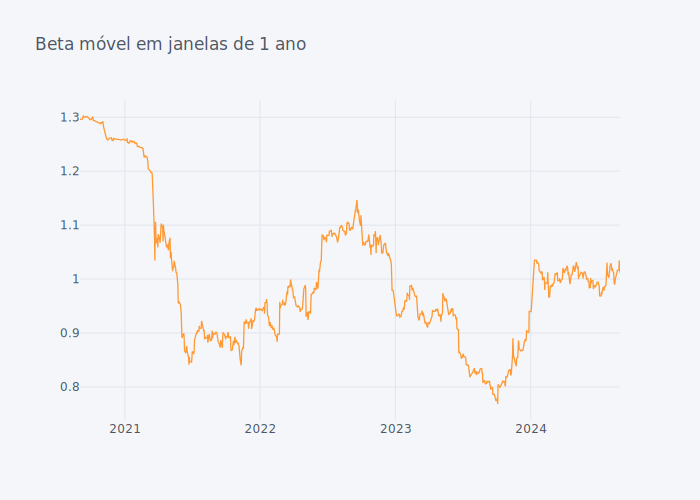

In [124]:
from statsmodels.regression.rolling import RollingOLS

modelo = RollingOLS(y,x,window=252)
resultado = modelo.fit()
betas = pd.DataFrame(resultado.params.lr_ibov.dropna())
betas.iplot(title='Beta móvel em janelas de 1 ano')

### CAPM

O famoso [Capital Asset Pricing Model](https://onlinelibrary.wiley.com/doi/full/10.1111/j.1540-6261.1964.tb02865.x) (CAPM) representa a relação entre o retorno esperado de um ativo de risco e o risco de mercado (também conhecido como sistemático ou não diversificável).

O CAPM é representado pela seguinte equação:
$$E(r_a) = r_f +\beta(E(r_m)-r_f)$$
onde $E(\ )$ denota o retorno esperado e $\beta$ é o coeficiente beta que pode ser interpretado como o nível de sensibilidade do retorno do ativo, em comparação com o mercado em geral.

In [125]:
capm_data =  pd.merge(cdi,REmonthly_returns[['ibov (% m)',codigo+'(% m)']],left_index=True, right_index=True,how='inner').copy()
capm_data.rename(columns={"cdi (% m)":"cdi","ibov (% m)":"mercado",codigo+'(% m)':"ativo"},inplace=True)
capm_data

,cdi,mercado,ativo
2019-09-01,0.46,0.101468,1.482685
2019-10-01,0.48,3.405680,1.136387
2019-11-01,0.38,3.981625,5.136416
2019-12-01,0.37,0.799475,23.246940
2020-01-01,0.38,8.721725,20.248490
2020-02-01,0.29,-3.326221,2.169404
2020-03-01,0.34,-6.982526,-16.676114
2020-04-01,0.28,-33.442438,-45.742088
2020-05-01,0.24,11.144617,14.349764
2020-06-01,0.21,12.353568,21.764717


In [126]:
X = capm_data['mercado'] - capm_data['cdi']     # excesso retorno ativo
y = capm_data['ativo']   - capm_data['cdi']  # excesso retorno indice
x = sm.add_constant(X)
capm_model = sm.OLS(y, x)
result = capm_model.fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.515
Model:                            OLS   Adj. R-squared:                  0.507
Method:                 Least Squares   F-statistic:                     61.65
Date:                Fri, 30 Aug 2024   Prob (F-statistic):           1.08e-10
Time:                        09:44:27   Log-Likelihood:                -209.83
No. Observations:                  60   AIC:                             423.7
Df Residuals:                      58   BIC:                             427.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.7936      1.049      1.709      0.0

O intercepto ([Jensen alfa](https://www.investopedia.com/terms/j/jensensmeasure.asp)) positivo e significativo, significa que – assumindo que o modelo CAPM é verdadeiro – o ativo ou carteira gera retornos ajustados ao risco anormalmente elevados. Existem duas possíveis
implicações – ou o mercado é ineficiente ou há algum outro fator de risco que deve ser incluído no modelo. Esta questão é conhecida como joint hypothesis problem.

O CAPM pode ser considerado um modelo unifatorial.
[Fama e French expandiram o modelo CAPM](https://www.sciencedirect.com/science/article/abs/pii/0304405X93900235) adicionando dois fatores adicionais que explicam os retornos excessivos de um ativo ou carteira. Os fatores são: **O fator de mercado** (*MKT*) --- mede o excesso de retorno do mercado, analogo do CAPM; **O fator tamanho**, *SMB* (Small Minus Big)--- mede o excesso de retorno das ações com uma pequena capitalização de mercado sobre aqueles com uma grande capitalização de mercad; **O fator de valor**, *HML* (High Minus Low) --- mede o excesso
de retorno de ações de valor em relação às ações de crescimento.

 As ações de valor têm uma alta razão [book-to-market](https://maisretorno.com/portal/termos/b/book-to-market), enquanto as ações de crescimento são caracterizadas por uma baixa razão.

 O modelo pode ser escrito como

$$
E(r_a) -r_f = \alpha + \beta_{\text{MKT}}\text{MKT} + \beta_{\text{SMB}}{\text{SMB}} + \beta_{\text{HML}}\text{HML}.
$$

Esses fatores tornaram-se conhecidos coletivamente como Fatores Fama-French ou Modelo de Três Fatores. Eles foram amplamente aceitos em  ambos academia e a indústria como referência do mercado de ações e são
frequentemente usados para avaliar desempenho do investimento.

In [127]:
url1 = 'https://nefin.com.br/data/risk_factors.html'
#ptra fingir que é um browser
header = {
  "User-Agent": "Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/50.0.2661.75 Safari/537.36",
  "X-Requested-With": "XMLHttpRequest"
}
#junta com a requests
r1 = requests.get(url1, headers=header)
# read_html do pandas põe a tabela num dataframe
dfs = pd.read_html(r1.text, decimal=',', thousands='.' , index_col=0)[0]

dfs

,6 months,1 year,5 years,Full sample
Risk Factors*,,,,
Rm-Rf,-2.77%,-2.02%,-1.72%,1.24%
SMB,-1.33%,-12.58%,-1.07%,-0.71%
HML,-3.80%,22.94%,19.32%,3.63%
WML,5.33%,28.36%,30.25%,10.15%
IML,-10.27%,-11.94%,2.20%,-0.20%
Risk-Free,1051,11.33%,8.15%,11.71%


O NEFIN (Núcleo de Pesquisa em Economia Financeira) disponibiliza séries históricas dos fatores de risco da bolsa brasileira, sendo eles:

Rm_minus_Rf -> Fator de mercado

SMB -> Tamanho

HML -> Valor

WML -> Momentum

IML -> Liquidez

In [128]:
url = 'https://nefin.com.br/resources/risk_factors/nefin_factors.csv'
fff = pd.read_csv(url, index_col = [0], parse_dates = ['Date'])
# fff.index = pd.to_datetime(fff.index , format="%Y-%m-%d")

In [129]:
fff

,Date,RM,Risk_Free,Rm_minus_Rf,SMB,HML,WML,IML
1,2001-01-02,0.007179,0.000579,0.006601,0.176477,0.015225,0.010002,0.003199
2,2001-01-03,0.063005,0.000577,0.062427,0.013144,0.034089,-0.059469,0.018638
3,2001-01-04,0.000264,0.000574,-0.000310,-0.009516,-0.018572,-0.000032,-0.005971
4,2001-01-05,-0.012267,0.000573,-0.012839,0.013002,-0.009581,0.010626,0.023871
5,2001-01-08,0.004554,0.000573,0.003982,-0.002692,0.021409,-0.006673,0.005605
...,...,...,...,...,...,...,...,...
5840,2024-07-29,-0.006189,0.000394,-0.006582,-0.023065,-0.000352,0.008922,-0.000329
5841,2024-07-30,-0.006519,0.000393,-0.006912,0.007824,0.005373,0.010000,0.008452
5842,2024-07-31,0.011628,0.000393,0.011235,-0.003265,-0.014463,0.000159,-0.007304
5843,2024-08-01,-0.002406,0.000393,-0.002800,0.011868,-0.014325,-0.000200,-0.000681


In [130]:
fff_data = pd.merge(fff, retornos[['r_'+codigo]],
                    left_on='Date', right_index=True,how='inner')
fff_data['excess_rtn'] = fff_data['r_'+codigo] - fff_data['Risk_Free']
# fff_data.set_index('Date',inplace=True)
fff_data

,Date,RM,Risk_Free,Rm_minus_Rf,SMB,HML,WML,IML,r_GOAU4,excess_rtn
4619,2019-08-30,0.008204,0.000222,0.007982,0.010717,0.008558,0.004872,0.019224,0.029654,0.029432
4620,2019-09-02,-0.004250,0.000221,-0.004471,0.006632,0.001321,-0.000615,0.002779,-0.014400,-0.014621
4621,2019-09-03,-0.008461,0.000220,-0.008681,0.001825,0.000711,-0.015230,-0.000010,-0.004870,-0.005090
4622,2019-09-04,0.013409,0.000219,0.013190,-0.021313,0.002553,-0.003126,-0.018208,-0.006525,-0.006745
4623,2019-09-05,0.008606,0.000218,0.008388,-0.007906,0.010807,0.014338,-0.009952,0.009852,0.009634
...,...,...,...,...,...,...,...,...,...,...
5840,2024-07-29,-0.006189,0.000394,-0.006582,-0.023065,-0.000352,0.008922,-0.000329,-0.004708,-0.005102
5841,2024-07-30,-0.006519,0.000393,-0.006912,0.007824,0.005373,0.010000,0.008452,-0.005676,-0.006070
5842,2024-07-31,0.011628,0.000393,0.011235,-0.003265,-0.014463,0.000159,-0.007304,0.011418,0.011024
5843,2024-08-01,-0.002406,0.000393,-0.002800,0.011868,-0.014325,-0.000200,-0.000681,-0.002822,-0.003216


In [131]:
import statsmodels.formula.api as smf
fff_model = smf.ols(formula='excess_rtn ~ RM + SMB + HML',data=fff_data).fit()
print(fff_model.summary())

                            OLS Regression Results                            
Dep. Variable:             excess_rtn   R-squared:                       0.502
Model:                            OLS   Adj. R-squared:                  0.501
Method:                 Least Squares   F-statistic:                     411.0
Date:                Fri, 30 Aug 2024   Prob (F-statistic):          1.66e-184
Time:                        09:44:29   Log-Likelihood:                 3146.3
No. Observations:                1225   AIC:                            -6285.
Df Residuals:                    1221   BIC:                            -6264.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0003      0.001      0.597      0.5

Devemos prestar atenção a dois problemas: (1) Se o intercepto é positivo
 e estatisticamente significativo; (2) Quais fatores são estatisticamente significativos e se sua direção corresponde aos
resultados passados (por exemplo, da literatura) ou as nossas suposições.
Também podemos olhar para a estatística F apresentada no resumo da regressão (Prob (F-statistic)), que testa a significância conjunta da regressão. A hipótese nula afirma que os coeficientes de todos os fatores, exceto o intercepto, possuem valores iguais a 0.


###previsão

In [132]:
# Calcula o retorno mensal dos fatores para todas as colunas, exceto a coluna "Date"
fff_m = (fff_data
            .assign(month = lambda x : pd.PeriodIndex(x['Date'], freq = 'M'))
            .groupby('month')
            .agg(**{col: (col, lambda x: (x + 1).prod() - 1) for col in fff_data.columns if col != 'Date'})
            )

fff_m

,RM,Risk_Free,Rm_minus_Rf,SMB,HML,WML,IML,r_GOAU4,excess_rtn
month,,,,,,,,,
2019-08,0.008204,0.000222,0.007982,0.010717,0.008558,0.004872,0.019224,2.965369e-02,0.029432
2019-09,0.030661,0.004474,0.026077,-0.038981,-0.015089,-0.039942,-0.041783,4.440892e-16,-0.004455
2019-10,0.016928,0.004593,0.012281,0.021161,0.052664,0.049235,0.030199,6.400220e-03,0.001798
2019-11,0.013866,0.003522,0.010310,0.077145,-0.039857,0.000307,0.050207,2.435568e-01,0.239241
2019-12,0.082867,0.003297,0.079323,0.089779,-0.023022,-0.027510,0.129425,1.897434e-01,0.185867
...,...,...,...,...,...,...,...,...,...
2024-04,-0.021671,0.008794,-0.030212,-0.069056,0.071948,0.042616,-0.013948,2.818260e-02,0.019226
2024-05,-0.020444,0.008273,-0.028492,-0.004746,0.011710,-0.001969,-0.008557,2.936861e-02,0.020930
2024-06,0.026566,0.007891,0.018536,-0.034512,0.003422,0.029287,-0.041021,-5.602228e-03,-0.013394


In [133]:
fff_m.index = fff_m.index.to_timestamp()
fff_m = fff_m.drop(["RM", "Risk_Free", "r_"+codigo], axis = 1)
fff_m

,Rm_minus_Rf,SMB,HML,WML,IML,excess_rtn
month,,,,,,
2019-08-01,0.007982,0.010717,0.008558,0.004872,0.019224,0.029432
2019-09-01,0.026077,-0.038981,-0.015089,-0.039942,-0.041783,-0.004455
2019-10-01,0.012281,0.021161,0.052664,0.049235,0.030199,0.001798
2019-11-01,0.010310,0.077145,-0.039857,0.000307,0.050207,0.239241
2019-12-01,0.079323,0.089779,-0.023022,-0.027510,0.129425,0.185867
...,...,...,...,...,...,...
2024-04-01,-0.030212,-0.069056,0.071948,0.042616,-0.013948,0.019226
2024-05-01,-0.028492,-0.004746,0.011710,-0.001969,-0.008557,0.020930
2024-06-01,0.018536,-0.034512,0.003422,0.029287,-0.041021,-0.013394


#### regressão de Lasso

In [134]:

from sklearn.pipeline import Pipeline
from sklearn.linear_model import ElasticNet, Lasso, Ridge

In [135]:
# Definindo um modelo de regressão com os parâmetros adequados
lm_model = ElasticNet(
  alpha=0.0053,  # Parâmetro de regularização para controlar a força da penalização
  l1_ratio=1,    # Razão entre a penalização L1 e L2 (Lasso e Ridge, respectivamente)
  max_iter=5000, # Número máximo de iterações permitidas durante a otimização
  fit_intercept=False  # Indica se deve ou não ajustar uma interceptação na regressão
)

# Criando um pipeline para o modelo de regressão
lm_pipeline = Pipeline([
  ("regressor", lm_model)
])

# Definindo a data de treinamento
training_date = "2021-12"

# Selecionando os dados de treinamento até a data especificada
data_training = (fff_m
  .query(f"month<='{training_date}'")
)

# Realiza o ajuste do modelo
lm_fit = lm_pipeline.fit(
  data_training, # X
  data_training.get("excess_rtn") # Y
)

# Criando um DataFrame com os valores previstos e reais
predicted_values = (pd.DataFrame({
    "Ajuste": lm_fit.predict(fff_m),  # Valores previstos pelo modelo
    "Realização": fff_m.get("excess_rtn")  # Valores reais observados
  })
  .assign(month = fff_m.index)  # Adicionando a coluna de meses
  .melt(id_vars="month", var_name="Variable", value_name="return")  # "Derretendo" o DataFrame para facilitar a plotagem
)

predicted_values

,month,Variable,return
0,2019-08-01,Ajuste,0.020038
1,2019-09-01,Ajuste,-0.003033
2,2019-10-01,Ajuste,0.001224
3,2019-11-01,Ajuste,0.162885
4,2019-12-01,Ajuste,0.126546
...,...,...,...
117,2024-04-01,Realização,0.019226
118,2024-05-01,Realização,0.020930
119,2024-06-01,Realização,-0.013394
120,2024-07-01,Realização,-0.010873


In [136]:
import matplotlib.pyplot as plt
from plotnine import *

from mizani.formatters import percent_format, date_format
from mizani.breaks import date_breaks

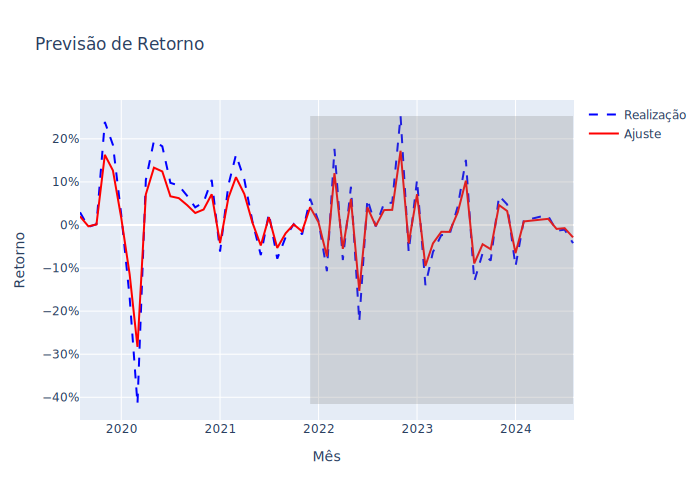

In [137]:
# prompt: gere o grafico da celula acima usando o plotly graph objects

fig = go.Figure()

fig.add_trace(go.Scatter(x=predicted_values['month'], y=predicted_values[predicted_values['Variable']=='Realização']['return'],
                    mode='lines',  line=dict(dash='dash',color ='blue'),
                    name='Realização'))
fig.add_trace(go.Scatter(x=predicted_values['month'], y=predicted_values[predicted_values['Variable']=='Ajuste']['return'],
                    mode='lines',line=dict(color ='red'),
                    name='Ajuste'))

fig.update_layout(
    title="Previsão de Retorno",
    xaxis_title="Mês",
    yaxis_title="Retorno",
    # height=550,
    # width=920,
    showlegend=True,
    font=dict(size=12),
)

fig.update_yaxes(tickformat='.0%')

fig.add_shape(
    type='rect',
    x0 = data_training.index.max(),
    x1 = fff_m.index.max(),
    y0 = predicted_values['return'].min(),
    y1 = predicted_values['return'].max(),
    line_color='rgba(0,0,0,0)',
    fillcolor='rgba(128,128,128,0.25)',# Cor do retângulo com opacidade
)

fig.show()



#### mais fatores

[[five factors model](https://tevgeniou.github.io/EquityRiskFactors/bibliography/FiveFactor.pdf)] o *modelo de Quatro Fatores de Carhart* supõe, subjacentemente, que dentro de um curto período de tempo, uma ação vencedora permanecerá vencedora, enquanto uma ação perdedora permanecerá perdedora. Por exemplo, um critério para classificar vencedores e perdedores poderia ser o retorno total acumulado dos últimos 12 meses. Depois de identificar os dois grupos, compramos os vencedores e vendemos os perdedores dentro de um determinado.
**O fator momentum** (*WML*; Winners Minus Losers) mede os excessos de retorno das ações vencedoras sobre as ações perdedoras nos últimos 12 meses. O modelo de quatro fatores pode ser expresso:

$$
E(r_a) -r_f = \alpha + \beta_{\text{MKT}}\text{MKT} + \beta_{\text{SMB}}{\text{SMB}} + \beta_{\text{HML}}\text{HML}+ \beta_{\text{WML}}\text{WML}.
$$

O *modelo de cinco fatores de Fama-French* adiciona dois fatores aos 3 anteriores: **o fator Robust Minus Weak** (*RMW*) mede os excessos de retorno de empresas com margens de lucro altas (lucratividade robusta) sobre aqueles com lucros mais baixos (fraca lucratividade). **O fator Conservative Minus Aggressive** (*CMA*) mede os excessos de retorno das
 empresas com políticas de baixo investimento (conservadoras) em detrimento daqueles que investem mais (agressivas). O modelo de cinco fatores pode ser expresso da seguinte forma:

$$
E(r_a) -r_f = \alpha + \beta_{\text{MKT}}\text{MKT} + \beta_{\text{SMB}}{\text{SMB}} + \beta_{\text{HML}}\text{HML}+ \beta_{\text{RMW}}\text{RMW} + \beta_{\text{CMA}}\text{CMA}.
$$

obs: O fator SMB no conjunto de dados de cinco fatores é calculado de forma diferente em comparação com como está no conjunto de dados de três fatores. [link](https://mba.tuck.dartmouth.edu/pages/faculty/ken.french/Data_Library/f-f_5_factors_2x3.html)

In [138]:
# !wget http://mba.tuck.dartmouth.edu/pages/faculty/ken.french/ftp/F-F_Research_Data_Factors_CSV.zip
# !unzip -a F-F_Research_Data_Factors_CSV.zip
# !rm F-F_Research_Data_Factors_CSV.zip
# factor_df = pd.read_csv('/content/F-F_Research_Data_Factors.CSV',skiprows=3)
# STR_TO_MATCH = ' Annual Factors: January-December '
# indices = factor_df.iloc[:, 0] == STR_TO_MATCH
# start_of_annual = factor_df[indices].index[0]
# factor_df = factor_df[factor_df.index < start_of_annual]
# factor_df

### DNN
Deep Neural network -- previsão do movimento com base em valores históricos de log-retornos

In [139]:
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier

In [140]:
logrets = pd.DataFrame()
logrets['returns'] = retornos['lr_'+codigo][-252:].copy()
logrets['direção'] = np.sign(logrets['returns']).astype(int)

lags = 5 # lags utilizados para prever o direcionamento
# Cria lags
cols = []
for lag in range(1, lags + 1):
  col = 'lag_{}'.format(lag)
  logrets[col] = logrets['returns'].shift(lag)
  cols.append(col)
logrets.dropna(inplace = True)

'''
    Criar os sinais (valores das variáveis dependentes)
    para avaliar a probabilidade de um movimento ascendente e um
    movimento descendente a partir das observações históricas
'''
cols_bin = []
for col in cols:
  col_bin = col + '_bin'
  logrets[col_bin] = np.digitize(logrets[col], bins=[0])
  cols_bin.append(col_bin)

# treinamento e teste com  50% para cada
train, test = train_test_split(logrets, test_size=0.5, random_state=100)

# Copiando e classificando os conjuntos de treinamento e teste com base nos índices
train = train.copy().sort_index()
test = test.copy().sort_index()

# Definindo o modelo de classificação MLP (DNN) com os parâmetros especificados
model = MLPClassifier(solver='lbfgs', alpha=1e-5, max_iter=500, hidden_layer_sizes=3 * [500], random_state=1)

# Treinando o modelo com os dados de treinamento, utilizando apenas as características binárias (cols_bin) e a direção como rótulo
model.fit(train[cols_bin], train['direção'])



MLPClassifier(alpha=1e-05, hidden_layer_sizes=[500, 500, 500], max_iter=500,
              random_state=1, solver='lbfgs')

In [141]:
# previsões usando o modelo treinado nos dados de teste
test['pos_dnn'] = model.predict(test[cols_bin])

# retornos da estratégia com base nas previsões do modelo e nos retornos históricos
test['dnn'] = test['pos_dnn'] * test['returns']

# Somando os retornos históricos e os retornos da estratégia e aplicando a função exponencial para obter o total acumulado
test[['returns', 'dnn']].sum().apply(np.exp)

returns    1.231461
dnn        1.108308
dtype: float64

In [142]:
# Calculando os retornos acumulados
cumulative_returns = test[['returns', 'dnn']].cumsum().apply(np.exp)
cumulative_returns.reset_index(inplace=True)

# Transforma em formato long
cumulative_returns_long = cumulative_returns.melt(id_vars = 'Date', var_name='strategy', value_name='cumulative_return')


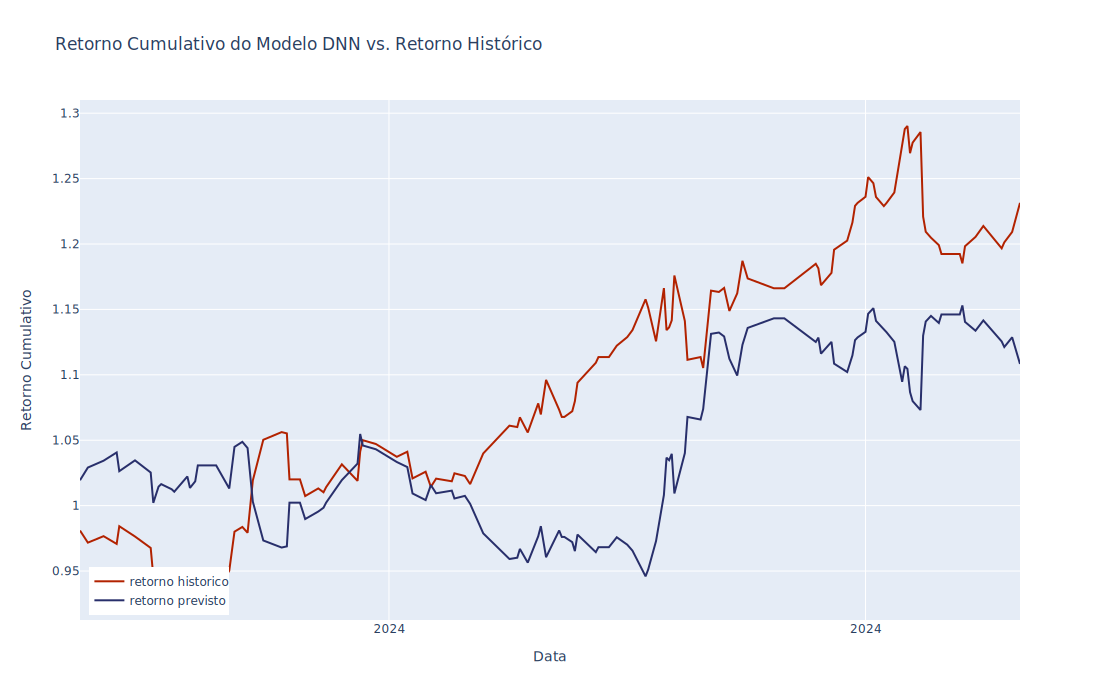

In [143]:
fig = go.Figure()

fig.add_trace(go.Scatter(x=cumulative_returns_long['Date'],
                         y=cumulative_returns_long[cumulative_returns_long['strategy']=='returns']['cumulative_return'],
                         mode='lines', name='retorno historico', line=dict(color='#b22200', width=2)))
fig.add_trace(go.Scatter(x=cumulative_returns_long['Date'],
                         y=cumulative_returns_long[cumulative_returns_long['strategy']=='dnn']['cumulative_return'],
                         mode='lines', name='retorno previsto', line=dict(color='#282f6b', width=2)))

fig.update_layout(title='Retorno Cumulativo do Modelo DNN vs. Retorno Histórico',
                  xaxis_title='Data',
                  yaxis_title='Retorno Cumulativo',
                  xaxis=dict(tickformat="%Y", tickmode="linear", dtick="M6"),
                  legend=dict(yanchor="bottom", y=0.01, xanchor="left", x=0.01),
                  width=1100, height=700)

fig.show()

###Hedge
Os gerentes de carteiras projetam modelos de fatores que lhes dizem como equilibrar um portfólio para obter alfa. Como alfa é como os gerentes são pagos, eles só querem exposição a seus fatores. A cobertura beta (*beta hedge*) remove a parte dos retornos impulsionados pelo mercado e deixa apenas os retornos impulsionados pelos fatores.

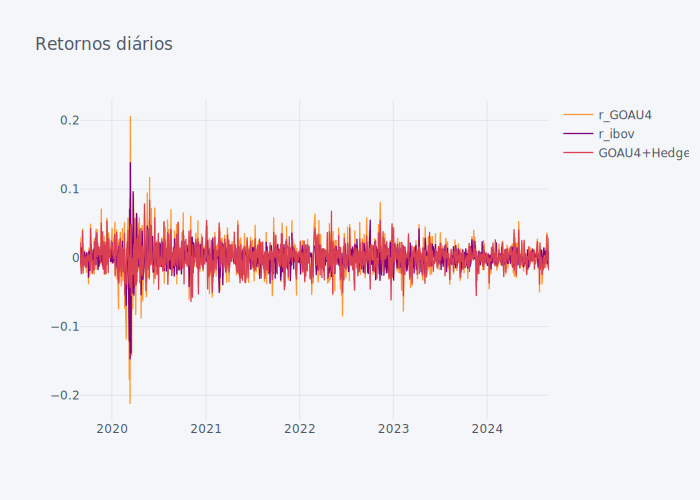

In [144]:
# beta hedge
retornos[codigo+"+Hedge"] = -1 * slope * retornos['r_ibov']+ retornos['r_'+codigo]
retornos.iplot(   keys = ['r_'+codigo,'r_ibov',codigo+"+Hedge"],
                  colors=['orange','purple', 'red'],
                  title='Retornos diários' )


In [145]:
P = retornos[codigo+"+Hedge"].values
X = retornos['r_ibov'].values
alpha,beta,_,_,_ = stats.linregress(X, P)
print(f"Alpha: {alpha}")
print(f"Beta: {beta}")

Alpha: -0.00791048592425194
Beta: 0.0007576775798829793


#### Underwater

In [146]:
# def underW (rtns : pd.Series):

#   df_cum_rtns=(1+rtns).cumprod()
#   max_accum = np.maximum.accumulate(df_cum_rtns)
#   return ( df_cum_rtns /max_accum -1 )

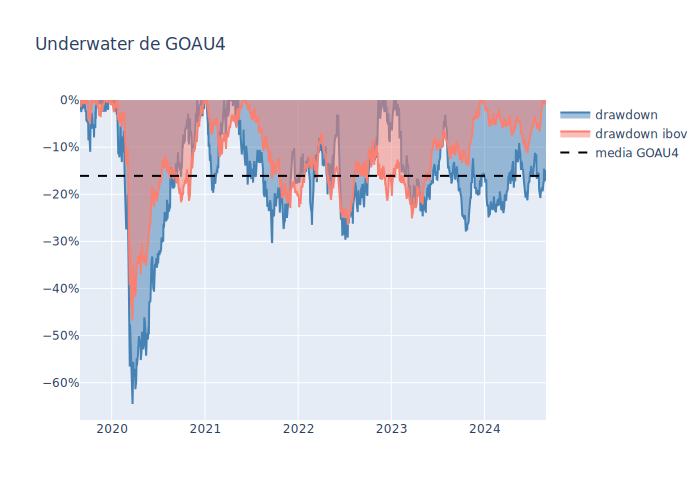

In [147]:
df_cum_rets = (retornos[['r_'+codigo,'r_ibov']]+1).cumprod()
running_max = np.maximum.accumulate(df_cum_rets)
underwater = (df_cum_rets-running_max) / running_max
trace1 = go.Scatter(x=underwater.index,y=underwater['r_'+codigo], name = 'drawdown',line=dict(color='steelblue'), fill='tozeroy')
trace3 = go.Scatter(x=underwater.index,y=underwater['r_ibov'],opacity=.1,  name = 'drawdown ibov',line=dict(color='salmon'), fill='tozeroy')

df_cum_rets_mean = -underwater.mean()
trace2 = go.Scatter(x=[min(underwater.index),max(underwater.index)],y=[-df_cum_rets_mean['r_'+codigo],-df_cum_rets_mean['r_'+codigo]],
                    mode='lines',name = f'media '+codigo,line=dict(color='black', width=2, dash='dash'))

layout = go.Layout(title=f'Underwater de '+codigo ,showlegend=True)
fig = go.Figure(data=[trace1,trace3,trace2], layout=layout)
fig.layout.yaxis.tickformat = '.0%'

fig.show()

### agrupamento do setor por retorno diário

In [148]:
IBr_rtrns = pd.DataFrame()
if codigo in IBr : IBr_rtrns = IBr_preco.pct_change()
else :
  IBr_rtrns = (IBr_preco.pct_change()).join(retornos['r_'+codigo],how='inner')
  IBr_rtrns.rename(columns={'r_'+codigo : codigo+'.SA'}, inplace=True)
IBr_rtrns.dropna(inplace=True)
#m=IBr_rtrns.corr()

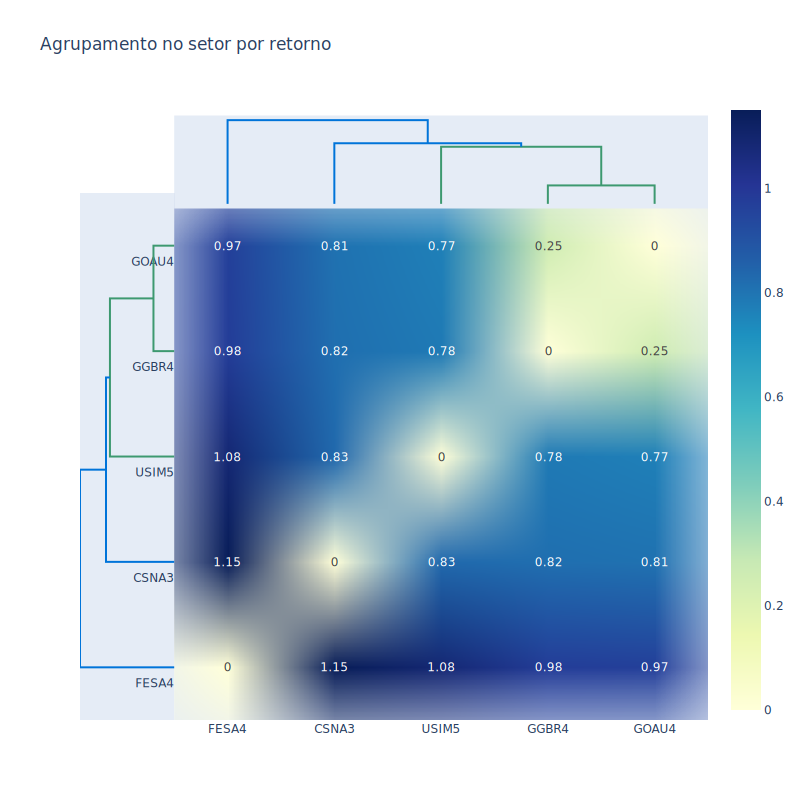

In [149]:
from scipy.spatial.distance import pdist, squareform
import plotly.figure_factory as ff


# Convert DataFrame to a NumPy array
data_array = IBr_rtrns.T.values
labels = IBr_rtrns.columns

# Initialize figure by creating upper dendrogram
fig = ff.create_dendrogram(data_array, orientation='bottom', labels=labels)
for i in range(len(fig['data'])):
    fig['data'][i]['yaxis'] = 'y2'
# Create Side Dendrogram
dendro_side = ff.create_dendrogram(data_array, orientation='right')
for i in range(len(dendro_side['data'])):
    dendro_side['data'][i]['xaxis'] = 'x2'

# Add Side Dendrogram Data to Figure
for data in dendro_side['data']:
    fig.add_trace(data)

# Create Heatmap
dendro_leaves = dendro_side['layout']['yaxis']['ticktext']
dendro_leaves = list(map(int, dendro_leaves))
data_dist = pdist(data_array) #Pairwise (euclidean)) distances between observations in n-dimensional space.
heat_data = squareform(data_dist) #Convert a vector-form distance vector to a square-form distance matrix
heat_data = heat_data[dendro_leaves, :]
heat_data = heat_data[:, dendro_leaves]

heatmap = [
    go.Heatmap(
        x=dendro_leaves,
        y=dendro_leaves,
        z=heat_data,
        # colorscale='Blues',
        colorscale='YlGnBu',
        text= heat_data.round(2),  # Valores dentro das células
        texttemplate="%{text}",
        textfont={"size":12} ,
        hovertemplate= 'heat: %{z:.2f} <br> x: %{x} ',
    )
]

heatmap[0]['x'] = fig['layout']['xaxis']['tickvals']
heatmap[0]['y'] = dendro_side['layout']['yaxis']['tickvals']


# Add Heatmap Data to Figure
for data in heatmap:
    fig.add_trace(data)

# Edit Layout
fig.update_layout({'title':'Agrupamento no setor por retorno','width': 800, 'height': 800,
                   'showlegend': False, 'hovermode': 'closest',
                   })
# Edit xaxis
fig.update_layout(xaxis={'domain': [.15, 1], 'mirror': False, 'showgrid': False, 'showline': False, 'zeroline': False, 'ticks': ""})
# Edit xaxis2
fig.update_layout(xaxis2={'domain': [0, .15],  'mirror': False,'showgrid': False,'showline': False,'zeroline': False,'showticklabels': False,'ticks': ""})
# Edit yaxis
ytics = [ x-1.5 for x in list(heatmap[0]['y'])]
ylabels = [labels[l] for l in dendro_leaves]
fig.update_layout(yaxis={'tickvals': ytics ,'ticktext': ylabels ,'domain': [0, .85],'mirror': False,'showgrid': False,'showline': False,'zeroline': False,'showticklabels': True,'ticks': '' })
# Edit yaxis2
fig.update_layout(yaxis2={'domain': [.825, .975],'mirror': False, 'showgrid': False,'showline': False,'zeroline': False,'showticklabels': False,'ticks': ""})

# Plot!
fig.show()


### correlação dos retornos com ativos do índice amplo

In [150]:
IBr_corr = IBr_rtrns.corr()
data_corr = pd.DataFrame(IBr_corr[codigo])

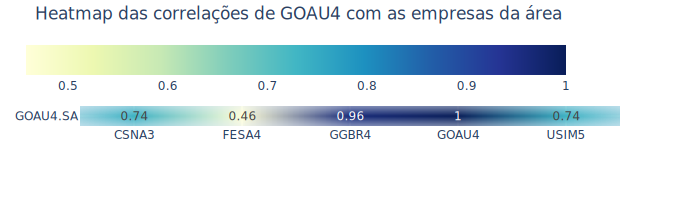

In [151]:
fig = go.Figure(data=go.Heatmap(
    z=data_corr[codigo].values.reshape(1, -1),
    x=data_corr.index,
    y=[codigo+'.SA'],
    colorscale='YlGnBu',
    text= data_corr[codigo].values.reshape(1, -1).round(2),  # Valores dentro das células
    texttemplate="%{text}",
    textfont={"size":12} ,
    colorbar=dict(orientation='h', xpad=0, xanchor='left', x=-0.1, y=1.2)
))

# Configurar o layout
fig.update_layout(height=200,
    title=f'Heatmap das correlações de {codigo} com as empresas da área',
    # xaxis_title='Índice',
    # yaxis_title='Categoria',
)

# Exibir o gráfico
fig.show()


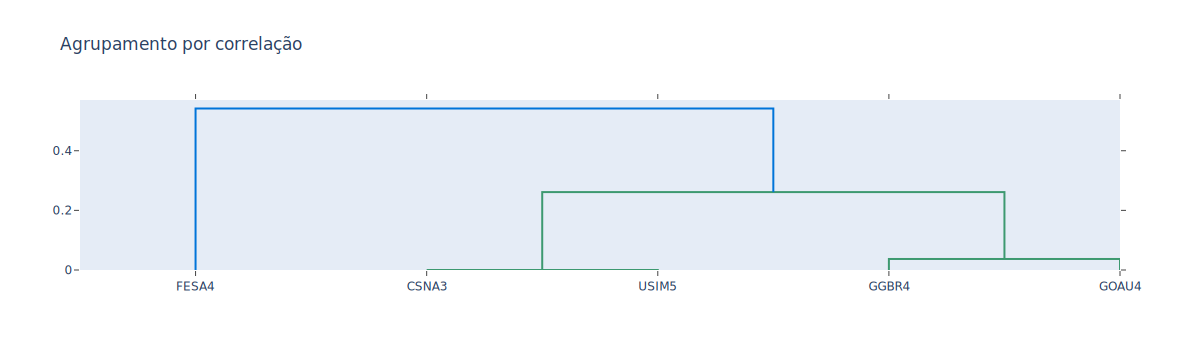

In [152]:
fig3 = ff.create_dendrogram(data_corr)
fig3.update_layout(title='Agrupamento por correlação', width=1200, height=350)
xlabels = [list(data_corr.index)[int(j)] for j in list(fig3['layout']['xaxis']['ticktext'])]
fig3.update_layout(xaxis={'tickvals': list(fig3['layout']['xaxis']['tickvals']) ,'ticktext': xlabels ,})
fig3.show()

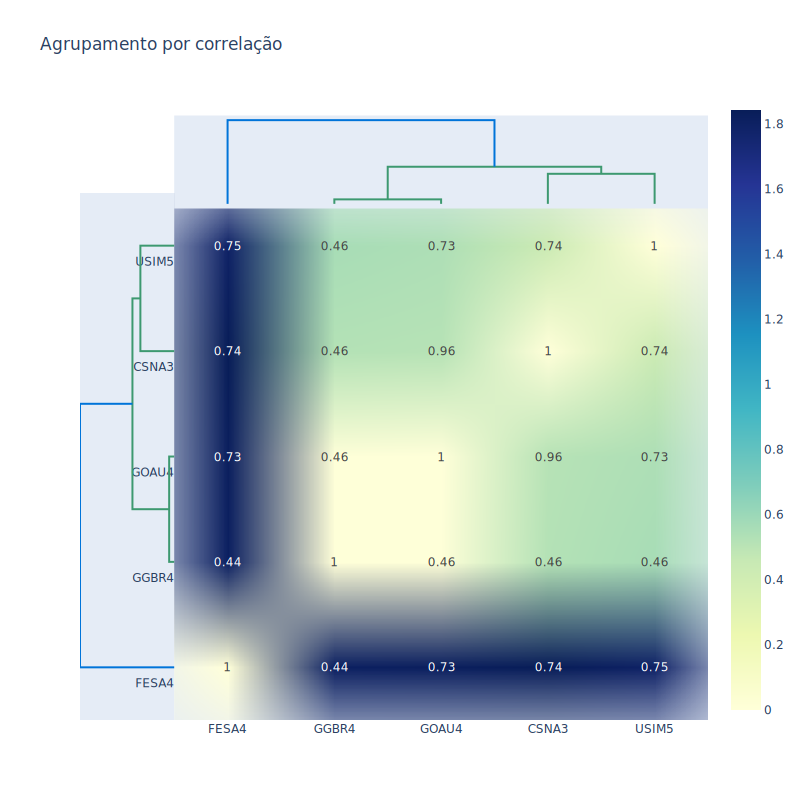

In [153]:
# Convert DataFrame to a NumPy array
data_array = IBr_corr.values
labels = IBr_corr.columns


# Initialize figure by creating upper dendrogram
fig = ff.create_dendrogram(data_array, orientation='bottom', labels=labels)
for i in range(len(fig['data'])):
    fig['data'][i]['yaxis'] = 'y2'
# Create Side Dendrogram
dendro_side = ff.create_dendrogram(data_array, orientation='right')
for i in range(len(dendro_side['data'])):
    dendro_side['data'][i]['xaxis'] = 'x2'

# Add Side Dendrogram Data to Figure
for data in dendro_side['data']:
    fig.add_trace(data)

# Create Heatmap
dendro_leaves = dendro_side['layout']['yaxis']['ticktext']
dendro_leaves = list(map(int, dendro_leaves))
data_dist = pdist(data_array , metric='correlation')
heat_data = squareform(data_dist)
heat_data = heat_data[dendro_leaves, :]
heat_data = heat_data[:, dendro_leaves]

heatmap = [
    go.Heatmap(
        x=dendro_leaves,
        y=dendro_leaves,
        z=heat_data,
        # colorscale='Blues',
        colorscale='YlGnBu',
        text= IBr_corr.values.round(2),  # Valores dentro das células
        texttemplate="%{text}",
        textfont={"size":12} ,
        hovertemplate= 'heat: %{z:.2f} <br> x: %{x} <br> Corr: %{text} ',
    )
]

heatmap[0]['x'] = fig['layout']['xaxis']['tickvals']
heatmap[0]['y'] = dendro_side['layout']['yaxis']['tickvals']


# Add Heatmap Data to Figure
for data in heatmap:
    fig.add_trace(data)

# Edit Layout
fig.update_layout({'title':'Agrupamento por correlação','width': 800, 'height': 800,
                   'showlegend': False, 'hovermode': 'closest',
                   })
# Edit xaxis
fig.update_layout(xaxis={'domain': [.15, 1], 'mirror': False, 'showgrid': False, 'showline': False, 'zeroline': False, 'ticks': ""})
# Edit xaxis2
fig.update_layout(xaxis2={'domain': [0, .15],  'mirror': False,'showgrid': False,'showline': False,'zeroline': False,'showticklabels': False,'ticks': ""})
# Edit yaxis
ytics = [ x-1.5 for x in list(heatmap[0]['y'])]
ylabels = [labels[l] for l in dendro_leaves]
fig.update_layout(yaxis={'tickvals': ytics ,'ticktext': ylabels ,'domain': [0, .85],'mirror': False,'showgrid': False,'showline': False,'zeroline': False,'showticklabels': True,'ticks': '' })
# Edit yaxis2
fig.update_layout(yaxis2={'domain': [.825, .975],'mirror': False, 'showgrid': False,'showline': False,'zeroline': False,'showticklabels': False,'ticks': ""})

# Plot!
fig.show()


### Valor-em-risco (*value-at-risk*)

In [154]:
def calculate_var_n(S , mu, sigma, c= 0.99, n=1): # n days in the future, c confidence level
    var = S * (mu * n - sigma * np.sqrt(n) * stats.norm.ppf(1-c))
    return var

In [155]:
def simulation(S, mu, sigma, c=.99, n=1, iterations=10000):
    stock_data = np.zeros([iterations, 1])
    rand = np.random.normal(0, 1, [1, iterations])

    # equation for the S(t) stock price
    stock_price = S * np.exp(n * (mu - 0.5 * sigma ** 2) + sigma * np.sqrt(n) * rand)

    # we have to sort the stock prices to determine the percentile
    stock_price = np.sort(stock_price)

    # it depends on the confidence level: 95% -> 5 and 99% -> 1
    percentile = np.percentile(stock_price, (1 - c) * 100)

    return S - percentile

In [156]:
# #parametros da simulação
# t = 1
# n_simuls = 10 ** 5
# port = np.array(20* df['pesos'])  # menor carteira possivel em no.de acoes, 1 unidade de carteira Plena

# chol_mat = np.linalg.cholesky(retornos[df['ativos']].cov()) #decomposição matriz cov
# rv = np.random.normal(size=(n_simuls, len(carteira))) #matriz aleatória n_simuls X len(carteira)
# correlated_rv = np.transpose(np.matmul(chol_mat, np.transpose(rv))) #números aleatórios correlacionados da distribuição Normal Padrão:

# r = np.mean(retornos[df['ativos']], axis=0).values      #retorno medio dos ativos
# sigma = np.std(retornos[df['ativos']], axis=0).values   #dp dos ativos
# S_0 = dados[df['ativos']].values[-1, :]                 #ultimo preço dos ativos
# P_0 = np.sum(port * S_0)                                #ultimo preço de 1 Plena
# print(f'O preço inicial de "1 Plena" é {P_0:.2f}')

# S_t = S_0 * np.exp((r - 0.5 * sigma ** 2) * t + sigma * np.sqrt(t) * correlated_rv) #preço final dos ativos
# P_t = np.sum( port * S_t, axis=1)                                                   #preços finais de 1 Plena
# P_t

# #variação dos preços
# Delta_P = P_t/P_0 - 1

# Delta_P_ordenado = np.sort(Delta_P)
# percentis = [0.01 , 0.1 , 1.0 , 3.0 , 5.0]
# var = np.percentile(Delta_P_ordenado , percentis)
# for x, y in zip(percentis, var):
#   print(f'V@R para 1 dia com grau confiança {100-x:.2f}% é {-y*100:.2f}%')

# pd.DataFrame(Delta_P).hist(bins=75, density=False, histtype='stepfilled', alpha=0.4, color='orange')
# plt.axvline(var[2], 0, 10000 , color = 'darkblue')
# plt.title("Distribuição das possíveis mudanças em 1 dia e o 1-dia 99% VaR");

In [157]:
# alpha = 0.05 #  1 - alpha = 0.95 => 95% confidence level
# var =  norm.ppf(alpha, retornos['Plena'].mean(), retornos['Plena'].std())
# print(f'O VaR diário é {var:.2%} com grau de confiança {1-alpha:.2f}')

# retornos['Plena'].hist(bins=25, density=True, histtype='stepfilled', alpha=0.4, color='orange')
# x = np.linspace((retornos['Plena'].mean() - 4*retornos['Plena'].std()), (retornos['Plena'].mean() + 4*retornos['Plena'].std()), 50)
# plt.plot(x, norm.pdf(x, retornos['Plena'].mean(), retornos['Plena'].std()), 'r--', lw=2)
# plt.axvline(x=var, color = 'darkblue')
# plt.text(0.02, 15, 'normal', fontsize=10, color='red')
# plt.text(-0.02, 30, 'Plena', fontsize=10, color='darkgreen')
# plt.text(-0.05, 20, 'V@R', fontsize=11, color='darkblue')
# plt.ylabel('Frequencia')
# plt.show()

# Volatilidade


A maioria das medidas da volatilidade de um ativo estão negativamente correlacionadas com os seus retornos, e podemos observar um padrão de aumento da volatilidade quando os preços descem e de diminuição da volatilidade quando estão a subir.

In [158]:
vol_movel = pd.DataFrame()
vol_movel['mm21'] = retornos['lr_'+codigo].rolling(window=21).std()
vol_movel['mm252'] = retornos['lr_'+codigo].rolling(window=252).std()

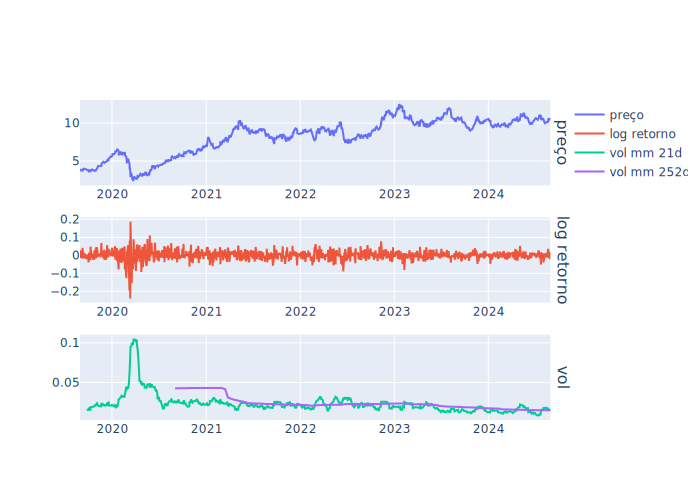

In [159]:
fig=make_subplots(rows=3,cols=1,row_titles=['preço','log retorno','vol'] )
fig.add_trace(go.Scatter(x=vol_movel.index , y = preco[codigo] ,name = 'preço'), row=1,col=1)
fig.add_trace(go.Scatter(x=vol_movel.index , y = retornos['lr_'+codigo],name = 'log retorno'),  row=2,col=1)
fig.add_trace(go.Scatter(x=vol_movel.index , y = vol_movel['mm21'] ,name = 'vol mm 21d'), row=3,col=1)
fig.add_trace(go.Scatter(x=vol_movel.index , y = vol_movel['mm252'],name = 'vol mm 252d' ), row=3,col=1)
fig.show()


## Volatilidade Condicional

Garch(1,1): a variância condicional é $\sigma_n^2 = \omega + \alpha r_{n-1}^2 + \beta\sigma_{n-1}^2 $, as letras gregas são parâmetros estimados (por máx. verossimilhança) do modelo, $r$ é retorno e $\sigma^2$ variância.  Os parâmetros:  $\omega = (1-\alpha-\beta)\cdot(\text{var de longo prazo})$, que é uma "reversão a média": $\sigma_{\infty}^2\to \text{VLP}$ com velocidade $1-\alpha-\beta$; $\alpha$ é o peso dos retornos  mais recentes, desde que $\alpha,\beta,\omega\geq 0$ e $\alpha+\beta<1$; $\beta$ é velocidade do  decaimento para as volatilidades mais recentes.

Quando $\omega=0,\alpha=1-\lambda, \beta=\lambda$ é o ewma: $ (1-\lambda) r_{n-1}^2 + \lambda \sigma_{n-1}^2$


In [160]:
#@title ####   EWMA
#@markdown fator de decaimento para ewma:
Lambda=0.94 #@param {type:"number"}


In [161]:
## ewma a partir da definição
ewma = pd.DataFrame(data = 0, columns=['vol_brute_force'],index=retornos.index)
ewma['vol_brute_force'].iloc[0] = np.sqrt((retornos['lr_'+codigo][0:4]**2).sum())
for t in range(1,len(retornos['r_'+codigo])):
    ewma.iloc[t] = np.sqrt((1-Lambda)*retornos['r_'+codigo].iloc[t-1]**2 + Lambda*ewma.iloc[t-1]**2)
# ewma.tail(3)

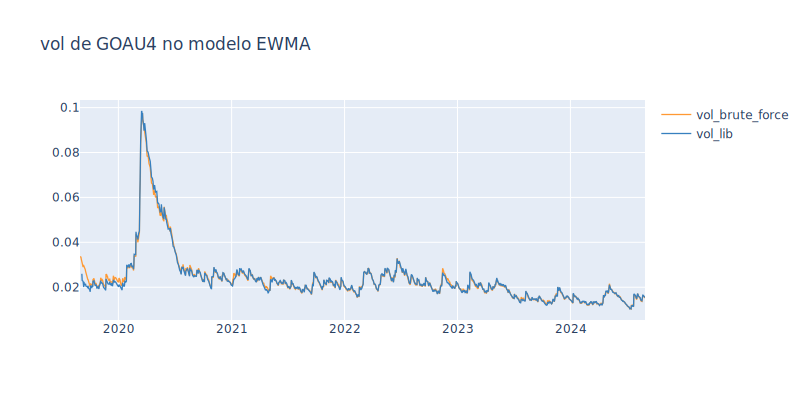

In [162]:
## ewma usando a biblioteca
#########
ewma['vol_lib'] = (retornos['lr_'+codigo].ewm(alpha = 0.06, min_periods=4, adjust=False).std()).shift(1)
ewma.iplot(layout=dict(title=f'vol de {codigo} no modelo EWMA' , height = 400, width=800))
##########

In [163]:
#@title ####   GARCH(1,1)

## da definição
%pip install -q arch
import scipy.optimize as spop

def garch_mle(params):
    mu    = params[0]
    omega = params[1]
    alpha = params[2]
    beta  = params[3]
    #variancia de longo prazo
    long_var =  (omega/(1 - alpha - beta))
    #volatilidade de longo prazo
    long_run = np.sqrt(long_var*252)
    #volatilidade condicional
    resid = retornos['lr_'+codigo] - mu
    realised = abs(resid)
    conditional = np.zeros(len(retornos['r_'+codigo]))
    conditional[0] =  long_run
    # GARCH
    for t in range(1,len(retornos['lr_'+codigo])):
        conditional[t] = (omega + alpha*resid[t-1]**2 + beta*conditional[t-1]**2)**(1/2)
    # np.log-verossimilhança
    likelihood = 1/((2*np.pi)**(1/2)*conditional)*np.exp(-realised**2/(2*conditional**2))
    np.log_likelihood = np.sum(np.log(likelihood))
    return -np.log_likelihood
### grach parametros
# maximização  np.log-verossimilhança
res = spop.minimize(garch_mle , [r_media, r_variancia, 0, 0  ], method='Nelder-Mead')

params = res.x
G_mu     = res.x[0]
G_omega  = res.x[1]
G_alpha  = res.x[2]
G_beta   = res.x[3]
np.log_likelihood = -float(res.fun)
print('np.log-verossim. '+str(round(np.log_likelihood, 4)))
###############################

# print('Parâmetros do GARCH encontrados:')
print('mu '+str(round(G_mu, 6)))
print('omega '+str(round(G_omega, 6)))
print('alpha '+str(round(G_alpha, 6)))
print('beta  '+str(round(G_beta, 6)))

Note: you may need to restart the kernel to use updated packages.
np.log-verossim. 2932.9173
mu 0.001668
omega 9.3e-05
alpha 0.192463
beta  0.63936


In [164]:
long_run = (G_omega/(1 - G_alpha - G_beta))**(1/2)
G_resid = retornos['lr_'+codigo] - G_mu

print('VOLATILIDADE:')
print('volatilidade diária de longo prazo '+str(round(long_run, 3)*100)+'%')
print('volatilidade de longo prazo anualizada '+str(round(long_run*np.sqrt(252), 3)*100)+'%')
print(' ')

VOLATILIDADE:
volatilidade diária de longo prazo 2.3%
volatilidade de longo prazo anualizada 37.3%
 


In [165]:
conditional = pd.DataFrame(data = 0, columns=['vol_brute_force'],index=retornos.index)
conditional['vol_brute_force'].iloc[0] = long_run
for t in range(1,len(retornos['lr_'+codigo])):
    conditional['vol_brute_force'].iloc[t] = (G_omega + G_alpha*G_resid.iloc[t-1]**2 + G_beta*conditional.iloc[t-1]**2)**(1/2)
conditional.head(2)

,vol_brute_force
Date,
2019-08-30,0.023496
2019-09-02,0.024329


In [166]:
##   GARCH(1,1)

## da bilioteca
from arch import arch_model
model = arch_model(retornos['lr_'+codigo],vol='GARCH', p=1, q=1)
model_fitted = model.fit(disp='off')
print(model_fitted.summary())

                     Constant Mean - GARCH Model Results                      
Dep. Variable:               lr_GOAU4   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:                2962.55
Distribution:                  Normal   AIC:                          -5917.10
Method:            Maximum Likelihood   BIC:                          -5896.60
                                        No. Observations:                 1244
Date:                Fri, Aug 30 2024   Df Residuals:                     1243
Time:                        09:45:40   Df Model:                            1
                                  Mean Model                                 
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
mu         1.1596e-03  6.114e-04      1.897  5.788e-02 

In [167]:
model_fitted.params

mu          0.001160
omega       0.000014
alpha[1]    0.099998
beta[1]     0.880003
Name: params, dtype: float64

In [168]:
Omega = model_fitted.params[1]
Alpha = model_fitted.params[2]
Beta = model_fitted.params[3]
long_run2 = (Omega/(1 - Alpha - Beta))**(1/2)

print('VOLATILIDADE:')
print('volatilidade diária de longo prazo '+str(round(long_run2, 3)*100)+'%')
print('volatilidade de longo prazo anualizada '+str(round(long_run2*np.sqrt(252), 3)*100)+'%')
print(' ')

VOLATILIDADE:
volatilidade diária de longo prazo 2.7%
volatilidade de longo prazo anualizada 42.1%
 


In [169]:
## da bilioteca
from arch import arch_model
model = arch_model(retornos['lr_'+codigo],vol='GARCH', p=1, q=1)
model_fitted = model.fit(disp='off')
print(model_fitted.summary())

                     Constant Mean - GARCH Model Results                      
Dep. Variable:               lr_GOAU4   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:                2962.55
Distribution:                  Normal   AIC:                          -5917.10
Method:            Maximum Likelihood   BIC:                          -5896.60
                                        No. Observations:                 1244
Date:                Fri, Aug 30 2024   Df Residuals:                     1243
Time:                        09:45:40   Df Model:                            1
                                  Mean Model                                 
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
mu         1.1596e-03  6.114e-04      1.897  5.788e-02 

In [170]:
conditional['vol_lib']=model_fitted.conditional_volatility
conditional

,vol_brute_force,vol_lib
Date,,
2019-08-30,0.023496,0.018693
2019-09-02,0.024329,0.020008
2019-09-03,0.022839,0.019771
2019-09-04,0.020847,0.019018
2019-09-05,0.019588,0.018392
...,...,...
2024-08-23,0.022032,0.019083
2024-08-26,0.020102,0.018309
2024-08-27,0.018865,0.017664


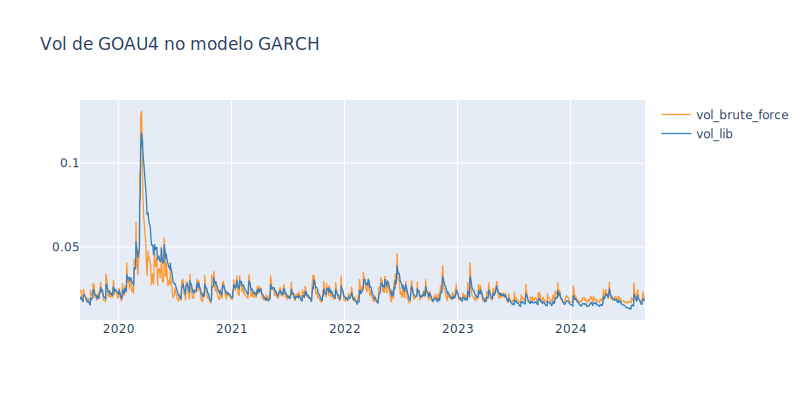

In [171]:
conditional.iplot(layout=dict(title=f'Vol de {codigo} no modelo GARCH', height = 400, width=800))

In [172]:
vols = pd.DataFrame()
vols['ewma1'] = ewma['vol_lib']
vols['ewma2'] = ewma['vol_brute_force']
vols['garch1'] = conditional['vol_lib']
vols['garch2'] = conditional['vol_brute_force']

vols['dp'] = r_desviopadrao
vols['longo prazo1'] = long_run2 # da lib
vols['longo prazo2'] = long_run

vols.round(decimals=3).iloc[::-1].head(3)

,ewma1,ewma2,garch1,garch2,dp,longo prazo1,longo prazo2
Date,,,,,,,
2024-08-29,0.015,0.015,0.018,0.019,0.026,0.027,0.023
2024-08-28,0.016,0.015,0.018,0.019,0.026,0.027,0.023
2024-08-27,0.016,0.015,0.018,0.019,0.026,0.027,0.023


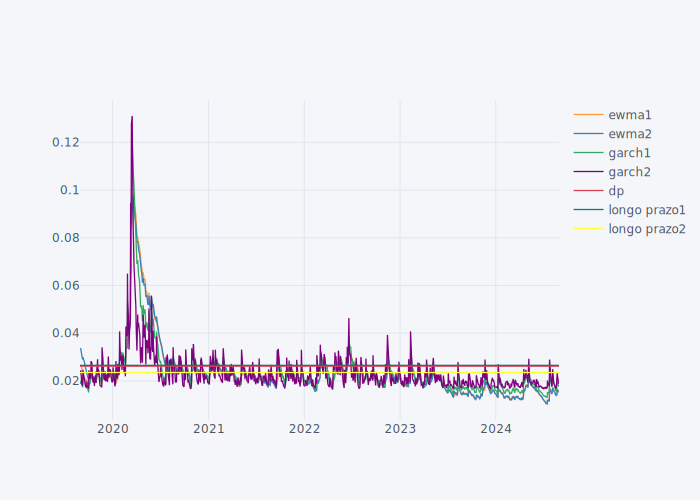

In [173]:
vols.iplot()

usando método de *forecast*

In [174]:
model_forecast = model_fitted.forecast(horizon=5)
model_forecast.mean

,h.1,h.2,h.3,h.4,h.5
Date,,,,,
2024-08-29,0.00116,0.00116,0.00116,0.00116,0.00116


In [175]:
model_forecast.variance

,h.1,h.2,h.3,h.4,h.5
Date,,,,,
2024-08-29,0.000316,0.000324,0.000332,0.000339,0.000346


In [176]:
model_forecast_vol = model_forecast.variance **0.5
model_forecast_vol

,h.1,h.2,h.3,h.4,h.5
Date,,,,,
2024-08-29,0.017783,0.017999,0.018208,0.018411,0.018608


In [177]:
model_forecast_vol_anual =  (model_forecast.variance * 252) **0.5
model_forecast_vol_anual
# model_vol_anual =  (model_forecast.variance[-1:] * 252) **0.5


,h.1,h.2,h.3,h.4,h.5
Date,,,,,
2024-08-29,0.28229,0.285721,0.289044,0.292264,0.295385


*forecast* em janelas móveis

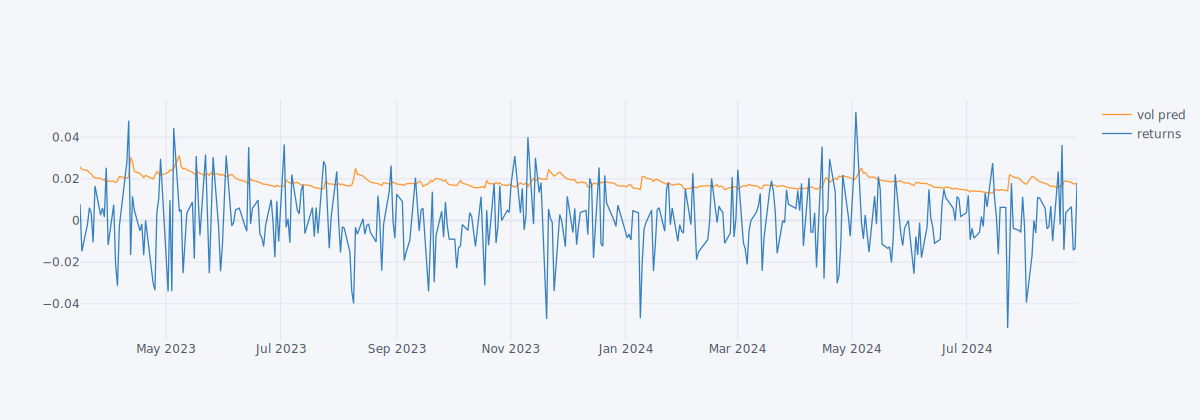

In [178]:
rolling_predictions = []
test_size = 365

for i in range(test_size):
    train = retornos['lr_'+codigo][:-(test_size-i)]
    model = arch_model(train, p=1, q=1)
    model_fit = model.fit(disp='off')
    pred = model_fit.forecast(horizon=1)
    rolling_predictions.append(np.sqrt(pred.variance.values[-1,:][0]))

rolling_pred = pd.DataFrame({'vol pred':rolling_predictions}, index=retornos['lr_'+codigo].index[-365:])
rolling_pred['returns'] = retornos['lr_'+codigo].iloc[-365:]

rolling_pred.iplot(dimensions=(1200,420))

#### Volatilidade histórica

Não existe um cálculo único para a volatilidade histórica. O número de dias para o cálculo da volatilidade histórica altera o cálculo. Não deverá, contudo, haver qualquer diferença entre a volatilidade histórica média diária ou semanal. Abaixo examinamos diferentes métodos de cálculo de volatilidade histórica, incluindo medidas avançadas de volatilidade, como Parkinson, Garman-Klass (incluindo extensão Yang-Zhang), Rogers e Satchell e Yang-Zhang. [MEASURING HISTORICAL VOLATILITY](https://dynamiproject.files.wordpress.com/2016/01/measuring_historic_volatility.pdf)

In [179]:
def standard_deviation(price_data, window=30, trading_periods=252, clean=True):

    log_return = (price_data / price_data.shift(1)).apply(np.log)
    result = log_return.rolling(window=window, center=False).std() * np.sqrt(trading_periods)

    if clean:
        return result.dropna()
    else:
        return result

def parkinson(price_data, window=30, trading_periods=252, clean=True):

    rs = (1.0 / (4.0 * np.log(2.0))) * ((price_data["High"] / price_data["Low"]).apply(np.log) ) ** 2.0

    def f(v):
        return (trading_periods * v.mean()) ** 0.5

    result = rs.rolling(window=window, center=False).apply(func=f)

    if clean:
        return result.dropna()
    else:
        return result

def garman_klass(price_data, window=30, trading_periods=252, clean=True):

    log_hl = (price_data["High"] / price_data["Low"]).apply(np.log)
    log_co = (price_data["Close"] / price_data["Open"]).apply(np.log)

    rs = 0.5 * log_hl ** 2 - (2 * np.log(2) - 1) * log_co ** 2

    def f(v):
        return (trading_periods * v.mean()) ** 0.5

    result = rs.rolling(window=window, center=False).apply(func=f)

    if clean:
        return result.dropna()
    else:
        return result
def hodges_tompkins(price_data, window=30, trading_periods=252, clean=True):

    log_return = (price_data["Close"] / price_data["Close"].shift(1)).apply(np.log)

    vol = log_return.rolling(window=window, center=False).std() * np.sqrt(
        trading_periods
    )

    h = window
    n = (log_return.count() - h) + 1

    adj_factor = 1.0 / (1.0 - (h / n) + ((h ** 2 - 1) / (3 * n ** 2)))

    result = vol * adj_factor

    if clean:
        return result.dropna()
    else:
        return
def rogers_satchell(price_data, window=30, trading_periods=252, clean=True):

    log_ho = (price_data["High"] / price_data["Open"]).apply(np.log)
    log_lo = (price_data["Low"] / price_data["Open"]).apply(np.log)
    log_co = (price_data["Close"] / price_data["Open"]).apply(np.log)

    rs = log_ho * (log_ho - log_co) + log_lo * (log_lo - log_co)

    def f(v):
        return (trading_periods * v.mean()) ** 0.5

    result = rs.rolling(window=window, center=False).apply(func=f)

    if clean:
        return result.dropna()
    else:
        return result

def yang_zhang(price_data, window=30, trading_periods=252, clean=True):

    log_ho = (price_data["High"] / price_data["Open"]).apply(np.log)
    log_lo = (price_data["Low"] / price_data["Open"]).apply(np.log)
    log_co = (price_data["Close"] / price_data["Open"]).apply(np.log)

    log_oc = (price_data["Open"] / price_data["Close"].shift(1)).apply(np.log)
    log_oc_sq = log_oc ** 2

    log_cc = (price_data["Close"] / price_data["Close"].shift(1)).apply(np.log)
    log_cc_sq = log_cc ** 2

    rs = log_ho * (log_ho - log_co) + log_lo * (log_lo - log_co)

    close_vol = log_cc_sq.rolling(window=window, center=False).sum() * (
        1.0 / (window - 1.0)
    )
    open_vol = log_oc_sq.rolling(window=window, center=False).sum() * (
        1.0 / (window - 1.0)
    )
    window_rs = rs.rolling(window=window, center=False).sum() * (1.0 / (window - 1.0))

    k = 0.34 / (1.34 + (window + 1) / (window - 1))
    result = (open_vol + k * close_vol + (1 - k) * window_rs).apply(
        np.sqrt
    ) * np.sqrt(trading_periods)

    if clean:
        return result.dropna()
    else:
        return result


In [180]:
HistVol = pd.DataFrame()

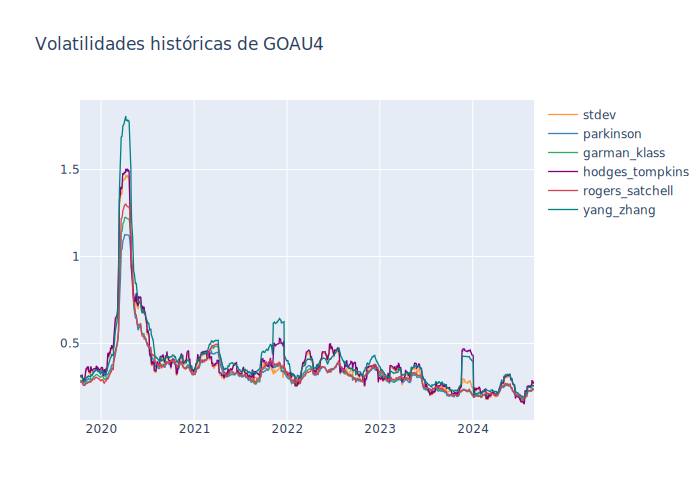

In [181]:
price_data = ativo.copy()

HistVol['stdev']= standard_deviation(price_data['Adj Close'], window=30, trading_periods=252, clean=True)

HistVol['parkinson']= parkinson(price_data, window=30, trading_periods=252, clean=True)

HistVol['garman_klass']= garman_klass(price_data, window=30, trading_periods=252, clean=True)

HistVol['hodges_tompkins']= hodges_tompkins(price_data, window=30, trading_periods=252, clean=True)

HistVol['rogers_satchell']= rogers_satchell(price_data, window=30, trading_periods=252, clean=True)

HistVol['yang_zhang']= yang_zhang(price_data, window=30, trading_periods=252, clean=True)

HistVol.iplot(layout=dict(title=f"Volatilidades históricas de {codigo}"))

# Futuros


In [182]:
symb = codigo[:4]
url1 = f'https://www.tradergrafico.com.br/opcoes/?TG=&opcrt=&opc={symb}'
#ptra fingir que é um browser
header = {
  "User-Agent": "Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/50.0.2661.75 Safari/537.36",
  "X-Requested-With": "XMLHttpRequest"
}
#junta com a requests
r1 = requests.get(url1, headers=header)
dfs = pd.read_html(r1.text, decimal=',', thousands='.')
# dfs = dfs[0]
colunas={dfs[0].columns[i]:dfs[0].iloc[0].values[i] for i in range(len(dfs[0].columns))}
dfs = dfs[0].rename(columns=colunas)
dfs = dfs.drop(labels=0, axis=0)
dfs[dfs['Últ.Cotação']!=0.0]

,Código,Hora,Últ.Cotação,No Negócios,Descrição,Vencimento,Exercício (R$)
1,GOAUI102,00:00:00,"R$ 0,00",0,GOAUE /ED (Call),20/09/2024,"PN 9,91"
2,GOAUU102,00:00:00,"R$ 0,00",0,GOAUE /ED (PUT),20/09/2024,"PN 9,91"
3,GOAUU106,00:00:00,"R$ 0,00",0,GOAUE /ED (PUT),20/09/2024,"PN 10,41"
4,GOAUI106,00:00:00,"R$ 0,00",0,GOAUE /ED (Call),20/09/2024,"PN 10,41"
5,GOAUI126,00:00:00,"R$ 0,00",0,GOAUE /ED (Call),20/09/2024,"PN 12,41"
6,GOAUU126,00:00:00,"R$ 0,00",0,GOAUE /ED (PUT),20/09/2024,"PN 12,41"
7,GOAUI136,00:00:00,"R$ 0,00",0,GOAU /ED (Call),20/09/2024,"PN 13,66"
8,GOAUU136,00:00:00,"R$ 0,00",0,GOAUE /ED (PUT),20/09/2024,"PN 13,66"
9,GOAUV113,00:00:00,"R$ 0,00",0,GOAUE /ED (PUT),18/10/2024,"PN 11,11"
10,GOAUJ113,00:00:00,"R$ 0,00",0,GOAUE /ED (Call),18/10/2024,"PN 11,11"


In [183]:
dfs[dfs['Últ.Cotação']!="R$ 0,00"]

,Código,Hora,Últ.Cotação,No Negócios,Descrição,Vencimento,Exercício (R$)


## Preço das opções por BS


Preço da Call $ = SN(d_1) - K e^{-rt}N(d_2)$ e

Preço da Put $ = Ke^{-rt}N(-d_2)-SN(-d_1)$

$d_1 = \frac{\ln(\frac{S}{K}) + (r + \frac{\sigma^2}{2})t}{\sigma \cdot \sqrt{t}}$
e $d_2 = d_1 - \sigma \cdot \sqrt{t}$

S = preço subjacente (por ação)
K = preço de exercício (por ação)
σ = volatilidade (% a.a.)
rf = taxa de juros sem risco continuamente composta (% a.a.)
q = rendimento de dividendos compostos continuamente (% a.a.)
t = tempo até o vencimento (% do ano)

N(d) = Probabilidade de que uma variável aleatória padronizada e com distribuição normal, seja menor ou igual a d

No caso de considerar dividendos, ajuste em $S$: $S e^{-qt}$ onde $q$ é dy anual (continuously compounded dividend yield )


In [184]:
def call_option_price(S, E, T, rf, sigma, dyield=0.0):
    # d1 and d2 parameters
    d1 = (np.log(S / E) + (rf + sigma * sigma / 2.0) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    return S*stats.norm.cdf(d1)-E*np.exp(-rf*T)*stats.norm.cdf(d2) , d1 , d2


def put_option_price(S, E, T, rf, sigma, dyield=0.0):
    # d1 and d2 parameters
    d1 = (np.log(S / E) + (rf + sigma * sigma / 2.0) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    return -S*stats.norm.cdf(-d1)+E*np.exp(-rf*T)*stats.norm.cdf(-d2) , -d1 , -d2


def gregas(tipo, S, E, T, rf, sigma, dyield=0.0):

    ## https://en.wikipedia.org/wiki/Black%E2%80%93Scholes_model#The_Options_Greeks
    ## https://www.macroption.com/black-scholes-formula/

    if dyield>0.0 and T>0.0: ajuste=np.exp(-dyield*T)
    else: ajuste =1.0

    _ , d1 , d2 =  call_option_price(S, E, T, rf, sigma, dyield)

    ## DELTA

    if tipo == "call": delta = ajuste*stats.norm.cdf(d1)
    elif tipo == "put": delta = ajuste*(stats.norm.cdf(d1)-1.0)

    ## GAMMA

    cdf_d1_prime=np.exp(-0.5*d1*d1)/np.sqrt(2.0*np.pi)

    gamma = ajuste*cdf_d1_prime/(S*sigma*np.sqrt(T))

    ## THETA

    if tipo == "call":
        theta = (1/365)*(-(S*sigma*ajuste*cdf_d1_prime/(2.0*np.sqrt(T))-rf*E*np.exp(-rf*T)*stats.norm.cdf(d2) - dyield*S*ajuste*stats.norm.cdf(d1)))
    elif tipo == "put":
        theta = (1/365)*(-(S*sigma*ajuste*cdf_d1_prime/(2.0*np.sqrt(T))+rf*E*np.exp(-rf*T)*stats.norm.cdf(-d2) + dyield*S*ajuste*stats.norm.cdf(-d1)))

    ## VEGA

    vega = S*cdf_d1_prime*np.sqrt(T)

    ## RHO

    if tipo == "call":
        rho = E*T*np.exp(-rf*T)*stats.norm.cdf(d2)
    elif tipo == "put":
        rho = E*T*np.exp(-rf*T)*stats.norm.cdf(-d2)

    return delta , gamma , theta , vega , rho

def get_third_fridays(n):

    from dateutil.relativedelta import relativedelta,FR

    output= []
    today = datetime.now() #gets current system date
    f_friday = today+ relativedelta(day=1, weekday=FR(3))
    output.append(f_friday.strftime("%Y-%m-%d"))
    for i in range(1,n+1): #value of i varies from 1 to 6 if n=6
        next_month = today + relativedelta(months=+i) #adds i months to current system date

        third_friday = next_month+ relativedelta(day=1, weekday=FR(3))
        #find_mth_friday(next_month,3) #finds third friday of the month using 'find_mth_friday()', the function we defined
        output.append(third_friday.strftime("%Y-%m-%d"))
    return output



In [185]:
print('Próximos vencimentos: ',*get_third_fridays(4))

Próximos vencimentos:  2024-08-16 2024-09-20 2024-10-18 2024-11-15 2024-12-20


In [186]:
T = (datetime.strptime(get_third_fridays(1)[1] , "%Y-%m-%d")-datetime.today()).days/252
r = np.log(1+.1125)/T

In [187]:

print("(delta , gamma , theta , vega , rho) =")
gregas(tipo="call", S=34.55 , E=35.39 , T=T, rf=.1125, sigma= .145 , dyield=0.12)

(delta , gamma , theta , vega , rho) =


(0.36007597170322186,
 0.2634420547135867,
 -0.00120168179947998,
 3.6535478823142564,
 0.9695888326811517)

In [188]:
print("selic atual (%): ",selic.tail(1).values[0][0])

selic atual (%):  10.5


In [189]:
#data
vencimento = get_third_fridays(2)[1]
venc= datetime.strptime(vencimento, '%Y-%m-%d')

hoje= preco.index[-1]
res = np.busday_count(hoje.strftime('%Y-%m-%d'),
                      venc.strftime('%Y-%m-%d'))
t=res/252
# taxa livre risco
r =  np.log((selic.iloc[-1]/100).values[0]+1)
# preço
S = preco[codigo].iloc[-1]
# volatilidade
sigma = vols['ewma1'].iloc[-1]*np.sqrt(252)
# sigma = vols['g-model'].iloc[-1]*np.sqrt(252)

# strikes

mm = ( preco[codigo][-21:-1].dropna()).mean()  #preço médio
ss = ( preco[codigo][-21:-1].dropna()).std()   #dp do preço
Ss= mm-3*ss
Sa= mm-2*ss
Sb= mm-1*ss
Sc= mm+1*ss
Sd= mm+2*ss
Se= mm+3*ss



In [190]:
bs_data = [
    [ '{:0.2f}'.format(Ss) , round(call_option_price(S,Ss, t, r, sigma)[0],2)  ,round(put_option_price(S,Ss, t, r, sigma)[0],2) ] ,
    [ '{:0.2f}'.format(Sa) , round(call_option_price(S,Sa, t, r, sigma)[0],2)  ,round(put_option_price(S,Sa, t, r, sigma)[0],2) ] ,
    [ '{:0.2f}'.format(Sb) , round(call_option_price(S,Sb, t, r, sigma)[0],2)  ,round(put_option_price(S,Sb, t, r, sigma)[0],2) ] ,
    [ '{:0.2f}'.format(mm) , round(call_option_price(S,mm, t, r, sigma)[0],2)  ,round(put_option_price(S,mm, t, r, sigma)[0],2) ] ,
    [ '{:0.2f}'.format(S)  , round(call_option_price(S,S , t, r, sigma)[0],2)  ,round(put_option_price(S ,S, t, r, sigma)[0],2) ] ,
    [ '{:0.2f}'.format(Sc) , round(call_option_price(S,Sc, t, r, sigma)[0],2)  ,round(put_option_price(S,Sc, t, r, sigma)[0],2) ] ,
    [ '{:0.2f}'.format(Sd) , round(call_option_price(S,Sd, t, r, sigma)[0],2)  ,round(put_option_price(S,Sd, t, r, sigma)[0],2) ] ,
    [ '{:0.2f}'.format(Se) , round(call_option_price(S,Se, t, r, sigma)[0],2)  ,round(put_option_price(S,Se, t, r, sigma)[0],2) ]
]


BS = pd.DataFrame(bs_data , columns=['preço '+codigo, 'preço Call' , 'preço Put'] )
BS

,preço GOAU4,preço Call,preço Put
0,9.51,1.08,0.01
1,9.75,0.85,0.03
2,10.00,0.65,0.06
3,10.24,0.46,0.12
4,10.52,0.29,0.23
5,10.48,0.31,0.21
6,10.73,0.20,0.34
7,10.97,0.12,0.50


In [191]:
#@markdown preço teórico a partir de outros parâmetros
#@markdown usando BS e Monte Carlo

# preço
S=34.81 #@param {type:"number"}
print('preço  do ativo',S)

# data
vencimento = "2025-06-20"    #@param {type:"date"}
hoje= preco.index[-1]
venc= datetime.strptime(vencimento, '%Y-%m-%d')
res = np.busday_count(hoje.strftime('%Y-%m-%d'),
                      venc.strftime('%Y-%m-%d'))
t=res/252
print("vencimento em "+str(res)+" dias (",t,"anos)")

# strike
strike=34.67  #@param {type:"number"}

# selic
juros = 10.5 #@param {type:"number"}
r=np.log(juros/100+1)
# vol
volatilidade ='EWMA'  #@param ['GARCH' , 'EWMA' ,'Desvio Padrao' ]

if volatilidade == 'GARCH'  :
	sigma = vols['garch1'].iloc[-1]*np.sqrt(252)
elif volatilidade == 'EWMA' :
	sigma = vols['ewma1'].iloc[-1]*np.sqrt(252)
else : sigma = vols['dp'].iloc[-1]*np.sqrt(252)

print("Preços dos derivativos pelo modelo Black-Scholes")
print("Call: ", round(call_option_price(S, strike, t, r, sigma)[0],2))
print("Put: ", round(put_option_price(S, strike, t, r, sigma)[0],2))


preço  do ativo 34.81
vencimento em 211 dias ( 0.8373015873015873 anos)
Preços dos derivativos pelo modelo Black-Scholes
Call:  4.66
Put:  1.74


In [192]:
# Monte Carlo
def call_option_simulation(S0,E,T,rf,sigma,iterations):
	option_data = np.zeros([iterations, 2])
	rand = np.random.normal(0, 1, [1, iterations])
	#equation for the S(t) stock price
	stock_price = S0*np.exp(T*(r - 0.5*sigma**2)+sigma*np.sqrt(T)*rand)
	#we need S-E because we have to calculate the max(S-E,0)
	option_data[:,1] = stock_price - E
	#average for the Monte-Carlo method
	#np.amax() returns the max(0,S-E) according to the formula
	average = np.sum(np.amax(option_data, axis=1))/float(iterations)
	#have to use the np.exp(-rT) discount factor
	return np.exp(-1.0*rf*T)*average

def put_option_simulation(S0,E,T,rf,sigma,iterations):
 option_data = np.zeros([iterations, 2])
 rand = np.random.normal(0, 1, [1, iterations])
 stock_price = S0*np.exp(T*(rf - 0.5*sigma**2)+sigma*np.sqrt(T)*rand)
 option_data[:,1] = E - stock_price
 average = np.sum(np.amax(option_data, axis=1))/float(iterations)
 return np.exp(-1.0*rf*T)*average


rodadas = 1000	#number of iterations in the Monte-Carlo simulation


print("Preços dos derivativos por simulação Monte Carlo")
print("Call: ", round(call_option_simulation(S,strike,t,r,sigma,rodadas),2))
print("Put: ", round(put_option_simulation(S,strike,t,r,sigma,rodadas),2))

Preços dos derivativos por simulação Monte Carlo
Call:  4.84
Put:  1.76


# Macro

In [193]:
# pd.read_html('https://www.anbima.com.br/informacoes/est-termo/CZ.asp',
#                    encoding='iso-8859-1',thousands='.',decimal=',')[4]
'''
estranho mas o comportamento é dierente pc X colab
'''


pd.read_html('https://www.anbima.com.br/informacoes/est-termo/CZ.asp',
                   encoding='iso-8859-1',thousands='.',decimal=',')[5][1:]

ETTJ / Inflação Implicita (IPCA) (%a.a./252)                       \
                                       Vértices  ETTJ IPCA  ETTJ PRE   
1                                      Vértices  ETTJ IPCA  ETTJ PRE   
2                                           252     6.5524   11.6006   
3                                           378     6.6500   11.7383   
4                                           504     6.6483   11.7842   
5                                           630     6.5987   11.8087   
..                                          ...        ...       ...   
67                                         8442     6.2169       NaN   
68                                         8568     6.2185       NaN   
69                                         8694     6.2201       NaN   
70                                         8820     6.2216       NaN   
71                                         8946     6.2231       NaN   

                        
    Inflação Implícita  
1   Inflação Implícita  
2               4.7377  
3               4.7710  
4               4.8157  
5               4.8874  
..                 ...  
67                 NaN  
68                 NaN  
69                 NaN  
70                 NaN  
71                 NaN  

[71 rows x 4 columns]

In [194]:
web=pd.DataFrame()
web = pd.read_html('https://www.anbima.com.br/informacoes/est-termo/CZ.asp',
                    encoding='iso-8859-1',thousands='.',decimal=',',
                    # converters={'*': lambda x: pd.to_numeric(x, errors='coerce')}
                    )[5].loc[2:]
web.columns = ['Vertices','IPCA','PRE','II']

web['Vertices']=web['Vertices'].astype(int)
web['IPCA']=web['IPCA'].astype(float)
web['PRE']=web['PRE'].astype(float)
web['II']=web['II'].astype(float)



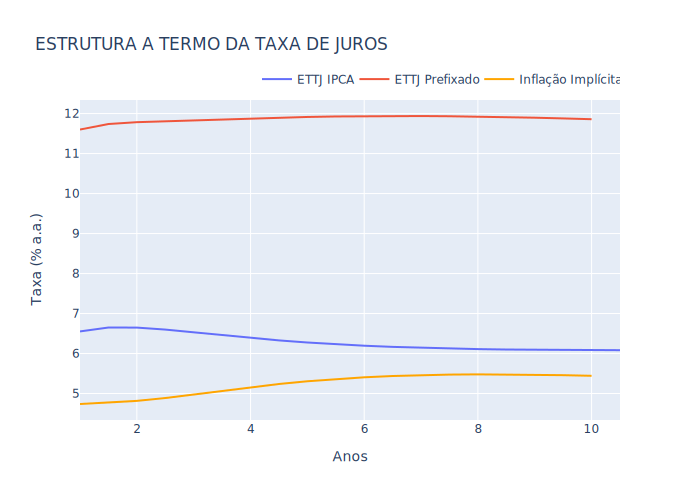

In [195]:
fig=go.Figure()
x = np.array(web['Vertices'][:20]/252)

fig.add_trace(go.Scatter(x=x, y=web['IPCA'][:20], mode='lines', name='ETTJ IPCA'))
fig.add_trace(go.Scatter(x=x, y=web['PRE'][:20], mode='lines', name='ETTJ Prefixado'))
fig.add_trace(go.Scatter(x=x, y=web['II'][:20], mode='lines', name='Inflação Implícita',
                         line=dict(color='orange')))

fig.update_layout(title='ESTRUTURA A TERMO DA TAXA DE JUROS',
                   xaxis_title='Anos',
                   yaxis_title='Taxa (% a.a.)',
                   legend=dict(orientation="h",
                              yanchor="bottom",
                              y=1.02,
                              xanchor="right",
                              x=1
))

fig.show()

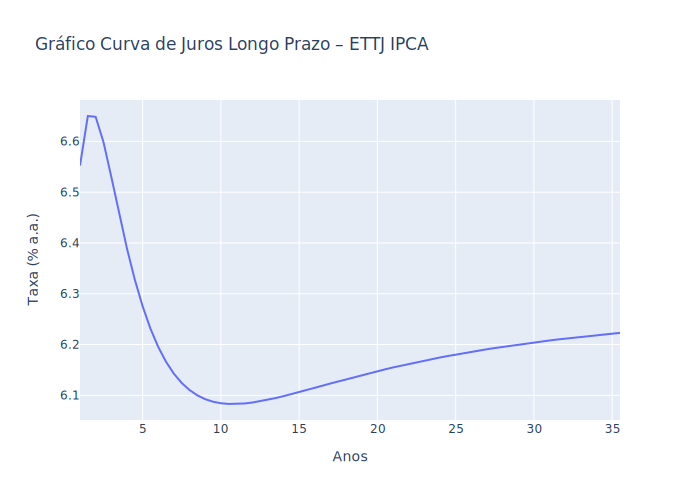

In [196]:
fig=go.Figure()
x = np.array(web['Vertices']/252)
fig.add_trace(go.Scatter(x=x, y=web['IPCA'], mode='lines', name='Juros reais',))
fig.update_layout(title='Gráfico Curva de Juros Longo Prazo – ETTJ IPCA',
                   xaxis_title='Anos',
                   yaxis_title='Taxa (% a.a.)')
fig.show()

[Empirical properties of asset returns:
stylized facts and statistical issues](https://http://finance.martinsewell.com/stylized-facts/dependence/Cont2001.pdf)